# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [4]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


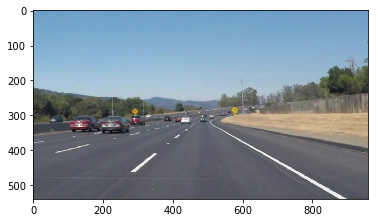

In [5]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [6]:
def intersection_x_coord(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def get_linear_regression_line(coef, intercept, intersection_x, imshape=[540,960]):
    
    # Get starting and ending points of regression line.
    line = []
    
    print (' ===== reg ==== ')
    print("Coef: ", coef, "Intercept: ", intercept, "intersection_x: ", intersection_x)
    
    line.append(int(intersection_x))
    line.append(int(intersection_x * coef + intercept))
    
    if coef > 0:
        line.append(imshape[1])
        line.append(int(imshape[1] * coef + intercept))
    elif coef < 0:
        line.append(0)
        line.append(int(0 * coef + intercept))
      
    print("line: ", line )
    print (' ===== reg ==== ')
    
    return line 

from scipy import stats

def draw_lines_reg(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    left_lines = []
    right_lines = []
    positive_x = []
    positive_y = []
    negative_x = []
    negative_y = []
    
    imshape = img.shape
    
    # Get the left lines and right lines out of the line set
    for line in lines:
        for x1,x2,y1,y2 in line:
            slope = (y2 - y1) / (x2 - x1)
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if not math.isnan(slope):
                # consider line with length greater then 50
                if (length > 50):
                    if (slope > 0):
                        positive_x.append(x1)
                        positive_x.append(x2)
                        positive_y.append(y1)
                        positive_y.append(y2)
                        right_lines.append([slope, y1 - slope * x1])
                    if (slope < 0):
                        negative_x.append(x1)
                        negative_x.append(x2)
                        negative_y.append(y1)
                        negative_y.append(y2)
                        left_lines.append([slope, y1 - slope * x1])
    
    if not left_lines:
        for line in lines:
            for x1,x2,y1,y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                if not math.isnan(slope):
                    if (slope < 0):
                        negative_x.append(x1)
                        negative_x.append(x2)
                        negative_y.append(y1)
                        negative_y.append(y2)
                        left_lines.append([slope, y1 - slope * x1])
                        
    if not right_lines:
        for line in lines:
            for x1,x2,y1,y2 in line:
                slope = (y2 - y1) / (x2 - x1)
                if not math.isnan(slope):
                    if (slope > 0):
                        positive_x.append(x1)
                        positive_x.append(x2)
                        positive_y.append(y1)
                        positive_y.append(y2)
                        right_lines.append([slope, y1 - slope * x1])   
    
    if not left_lines:
            print('No left lane')
    
    if not right_lines:
            print ('No right lane')
                  
                  
    # Average out the left and right lines
    positive_slope, positive_intercept, _, _, _ = stats.linregress(positive_x, positive_y)
    #print (positive_slope, positive_intercept)
    
    negative_slope, negative_intercept, _, _, _ = stats.linregress(negative_x, negative_y)
    #print (negative_slope, negative_intercept)
    
    # Get intersection point
    intersection_x = intersection_x_coord(positive_slope, positive_intercept, negative_slope, negative_intercept)
    
    lines = []
    
    #print (get_linear_regression_line(positive_slope, positive_intercept, intersection_x, imshape))
    #print (get_linear_regression_line(negative_slope, negative_intercept, intersection_x, imshape))
    
    lines.append([get_linear_regression_line(positive_slope, positive_intercept, intersection_x, imshape)])
    lines.append([get_linear_regression_line(negative_slope, negative_intercept, intersection_x, imshape)])
                 
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


In [28]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    print (intercept2, intercept1, coef1, coef2)
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=4):
    
    # Get starting and ending points of regression line, ints.
    print (' ===== avg ==== ')
    print("Coef: ", coef, "Intercept: ", intercept, "intersection_x: ", intersection_x)
    
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("line ", point_one, point_two)
    print (' ===== avg ==== ')
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
    
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
        
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    return slope, intercept

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    
    # Initialise arrays
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_intercept:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_intercept:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_intercept.append([slope, y1-slope*x1])

    if not positive_slope_intercept:
        print("positive_slope_intercept still empty")
        return
    if not negative_slope_intercept:
        print("negative_slope_intercept still empty")
        return

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)
    
    if math.isnan(pos_coef) or math.isnan(neg_coef) or math.isnan(pos_intercept) or math.isnan(neg_intercept):
        return
    
    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    if math.isnan(intersection_x_coord):
        return
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image   
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines_reg(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines_reg(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
        
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [9]:
import os
images = os.listdir("test_images/")
print (images)

test_images = []
for image in images:
     test_images.append(mpimg.imread("test_images/" + image))


['solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

(540, 960, 3)
639.167663645 9.53484571758 0.622801115063 -0.693868460506
 ===== avg ==== 
Coef:  0.622801115063 Intercept:  9.53484571758 intersection_x:  478.201083712
line  (478, 307) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.693868460506 Intercept:  639.167663645 intersection_x:  478.201083712
line  (478, 307) (0, 639)
 ===== avg ==== 
(540, 960, 3)
672.034071081 39.8131581624 0.570163496594 -0.73928692507
 ===== avg ==== 
Coef:  0.570163496594 Intercept:  39.8131581624 intersection_x:  482.81393664
line  (482, 315) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73928692507 Intercept:  672.034071081 intersection_x:  482.81393664
line  (482, 315) (0, 672)
 ===== avg ==== 
(540, 960, 3)
686.684079911 32.7631372836 0.568088107675 -0.787767112377
 ===== avg ==== 
Coef:  0.568088107675 Intercept:  32.7631372836 intersection_x:  482.294077536
line  (482, 306) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.787767112377 Intercept:  686.684079911 intersection_x: 

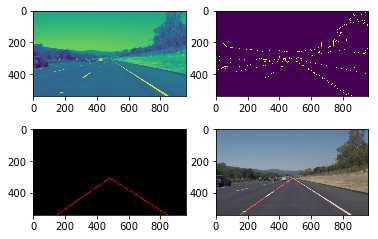

In [35]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
def draw_lanes(img):
    
    AVERAGE = 1
    
    # Get the shape of the image
    imshape = img.shape
    print (imshape)
    
    # Step 1: Convert image to Gray Scale
    gray_img = grayscale(img)
    plt.subplot(2,2,1)
    plt.imshow(gray_img)
    
    # Step 2: do the Gaussian blur on the Gray image with kernel size = 5
    blur_img = gaussian_blur(gray_img, kernel_size = 5)
    
    # Step 3: Detect edges in image using Canny Edge Detection
    edge_img = canny(blur_img, low_threshold = 50, high_threshold = 150)
    plt.subplot(2,2,2)
    plt.imshow(edge_img)
    
    # Step 4: Make region of interest
    x_size = 10
    vertices = np.array([[(0,imshape[0]),(int(imshape[1]/2 - x_size), int(imshape[0]/2 + imshape[0]*0.1)), (int(imshape[1]/2), int(imshape[0]/2 + imshape[0]*0.1)), (imshape[1],imshape[0])]], dtype=np.int32)
    edge_mask_img = region_of_interest(edge_img, vertices)
    
    # Step 5: Define hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 45      # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40   # minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    
    # Step 6: Run Hough on edge detected image
    hough_img = hough_lines(edge_mask_img, rho, theta, threshold, min_line_len, max_line_gap)
    plt.subplot(2,2,3)
    plt.imshow(hough_img)
    
    # Step 6: Run Hough on edge detected image
    if AVERAGE == 0:
        hough_img_reg = hough_lines_reg(edge_mask_img, rho, theta, threshold, min_line_len, max_line_gap)
        # Step 7: Combine lines image with original image
        final_img_reg = weighted_img(hough_img_reg, img)
        ## Plot final image
        plt.subplot(1,1,1)
        plt.imshow(final_img_reg)
    
    # Step 7: Combine lines image with original image
    final_img = weighted_img(hough_img, img)
    ## Plot final image
    plt.subplot(2,2,4)
    plt.imshow(final_img)
    #return final_image
    return final_img
    
a = draw_lanes(test_images[0])
a = draw_lanes(test_images[1])
a = draw_lanes(test_images[2])
a = draw_lanes(test_images[3])
a = draw_lanes(test_images[4])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = draw_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

(540, 960, 3)
655.834697447 1.36121320607 0.628992019938 -0.73716248049
 ===== avg ==== 
Coef:  0.628992019938 Intercept:  1.36121320607 intersection_x:  479.062568718
line  (479, 302) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73716248049 Intercept:  655.834697447 intersection_x:  479.062568718
line  (479, 302) (0, 655)
 ===== avg ==== 
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4




  0%|          | 0/222 [00:00<?, ?it/s]

(540, 960, 3)
655.834697447 1.36121320607 0.628992019938 -0.73716248049
 ===== avg ==== 
Coef:  0.628992019938 Intercept:  1.36121320607 intersection_x:  479.062568718
line  (479, 302) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73716248049 Intercept:  655.834697447 intersection_x:  479.062568718
line  (479, 302) (0, 655)
 ===== avg ==== 
(540, 960, 3)
653.775883274 7.52502318052 0.61716189317 -0.732734234714
 ===== avg ==== 
Coef:  0.61716189317 Intercept:  7.52502318052 intersection_x:  478.741176261
line  (478, 302) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.732734234714 Intercept:  653.775883274 intersection_x:  478.741176261
line  (478, 302) (0, 653)
 ===== avg ==== 




  1%|▏         | 3/222 [00:00<00:08, 24.95it/s]

(540, 960, 3)
657.252240285 26.454611921 0.590978147877 -0.738585448057
 ===== avg ==== 
Coef:  0.590978147877 Intercept:  26.454611921 intersection_x:  474.439605818
line  (474, 306) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738585448057 Intercept:  657.252240285 intersection_x:  474.439605818
line  (474, 306) (0, 657)
 ===== avg ==== 
(540, 960, 3)
655.062455035 14.9151716932 0.606393741596 -0.734293967788
 ===== avg ==== 
Coef:  0.606393741596 Intercept:  14.9151716932 intersection_x:  477.476804524
line  (477, 304) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.734293967788 Intercept:  655.062455035 intersection_x:  477.476804524
line  (477, 304) (0, 655)
 ===== avg ==== 
(540, 960, 3)
645.365900383 16.8757763975 0.603726708075 -0.706458675424
 ===== avg ==== 
Coef:  0.603726708075 Intercept:  16.8757763975 intersection_x:  479.695569727
line  (479, 306) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706458675424 Intercept:  645.365900383 intersection_x

646.374626866 17.5855090758 0.605570503283 -0.711940298507
 ===== avg ==== 
Coef:  0.605570503283 Intercept:  17.5855090758 intersection_x:  477.255379565
line  (477, 306) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711940298507 Intercept:  646.374626866 intersection_x:  477.255379565
line  (477, 306) (0, 646)
 ===== avg ==== 




  3%|▎         | 7/222 [00:00<00:08, 26.62it/s]

(540, 960, 3)
646.843920925 13.2358321596 0.609383928691 -0.712689482732
 ===== avg ==== 
Coef:  0.609383928691 Intercept:  13.2358321596 intersection_x:  479.253332902
line  (479, 305) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712689482732 Intercept:  646.843920925 intersection_x:  479.253332902
line  (479, 305) (0, 646)
 ===== avg ==== 
(540, 960, 3)
655.409124755 11.1219937933 0.608356460376 -0.737764841264
 ===== avg ==== 
Coef:  0.608356460376 Intercept:  11.1219937933 intersection_x:  478.624868484
line  (478, 302) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737764841264 Intercept:  655.409124755 intersection_x:  478.624868484
line  (478, 302) (0, 655)
 ===== avg ==== 
(540, 960, 3)
643.73984636 9.91785443915 0.617446860855 -0.706595096013
 ===== avg ==== 
Coef:  0.617446860855 Intercept:  9.91785443915 intersection_x:  478.702346729
line  (478, 305) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706595096013 Intercept:  643.73984636 intersection_x



  5%|▍         | 11/222 [00:00<00:07, 29.11it/s]

(540, 960, 3)
649.215929626 12.5726666667 0.617666666667 -0.716828729072
 ===== avg ==== 
Coef:  0.617666666667 Intercept:  12.5726666667 intersection_x:  477.066661296
line  (477, 307) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716828729072 Intercept:  649.215929626 intersection_x:  477.066661296
line  (477, 307) (0, 649)
 ===== avg ==== 
(540, 960, 3)
656.662704517 16.1440710508 0.614479461332 -0.727362352926
 ===== avg ==== 
Coef:  0.614479461332 Intercept:  16.1440710508 intersection_x:  477.342878021
line  (477, 309) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727362352926 Intercept:  656.662704517 intersection_x:  477.342878021
line  (477, 309) (0, 656)
 ===== avg ==== 
(540, 960, 3)
661.57297465 15.7157394527 0.616568028196 -0.740772602499
 ===== avg ==== 
Coef:  0.616568028196 Intercept:  15.7157394527 intersection_x:  475.825463845
line  (475, 309) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740772602499 Intercept:  661.57297465 intersection_x



  6%|▋         | 14/222 [00:00<00:07, 27.17it/s]

(540, 960, 3)
657.332271053 -1.57498210009 0.64053508497 -0.740068489297
 ===== avg ==== 
Coef:  0.64053508497 Intercept:  -1.57498210009 intersection_x:  477.260283425
line  (477, 304) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740068489297 Intercept:  657.332271053 intersection_x:  477.260283425
line  (477, 304) (0, 657)
 ===== avg ==== 
(540, 960, 3)
641.167339385 5.49670630721 

0.631188280046 -0.701590047615
 ===== avg ==== 
Coef:  0.631188280046 Intercept:  5.49670630721 intersection_x:  476.951507902
line  (476, 306) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701590047615 Intercept:  641.167339385 intersection_x:  476.951507902
line  (476, 306) (0, 641)
 ===== avg ==== 
(540, 960, 3)
637.453926389 -12.8798838323 0.655471556081 -0.696439944198
 ===== avg ==== 
Coef:  0.655471556081 Intercept:  -12.8798838323 intersection_x:  481.047620415
line  (481, 302) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696439944198 Intercept:  637.453926389 intersection_x:  481.047620415
line  (481, 302) (0, 637)
 ===== avg ==== 
(540, 960, 3)




  8%|▊         | 17/222 [00:00<00:08, 24.72it/s]

636.268364504 -5.23074191197 0.644814873074 -0.692394177226
 ===== avg ==== 
Coef:  0.644814873074 Intercept:  -5.23074191197 intersection_x:  479.729856953
line  (479, 304) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692394177226 Intercept:  636.268364504 intersection_x:  479.729856953
line  (479, 304) (0, 636)
 ===== avg ==== 
(540, 960, 3)


628.079962246 -15.5684016072 0.659234672496 -0.666754569466
 ===== avg ==== 
Coef:  0.659234672496 Intercept:  -15.5684016072 intersection_x:  485.409944127
line  (485, 304) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.666754569466 Intercept:  628.079962246 intersection_x:  485.409944127
line  (485, 304) (0, 628)
 ===== avg ==== 
(540, 960, 3)
626.079514825 -0.118666350039 0.638167677187 -0.658580413297
 ===== avg ==== 
Coef:  0.638167677187 Intercept:  -0.118666350039 intersection_x:  482.898865069
line  (482, 308) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.658580413297 Intercept:  626.079514825 intersection_x:  482.898865069
line  (482, 308) (0, 626)
 ===== avg ==== 




  9%|▉         | 20/222 [00:00<00:07, 25.38it/s]

(540, 960, 3)
653.590882256 -10.8703962158 0.655236887805 -0.72638843777
 ===== avg ==== 
Coef:  0.655236887805 Intercept:  -10.8703962158 intersection_x:  480.92725732
line  (480, 304) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.72638843777 Intercept:  653.590882256 intersection_x:  480.92725732
line  (480, 304) (0, 653)
 ===== avg ==== 
(540, 960, 3)
654.428630452 2.14401925566 0.637246965737 -0.725751635839
 ===== avg ==== 
Coef:  0.637246965737 Intercept:  2.14401925566 intersection_x:  478.565869725
line  (478, 307) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725751635839 Intercept:  654.428630452 intersection_x:  478.565869725
line  (478, 307) (0, 654)
 ===== avg ==== 
(540, 960, 3)
637.751697883 -3.79175531654 0.645934491953 -0.681583353116
 ===== avg ==== 
Coef:  0.645934491953 Intercept:  -3.79175531654 intersection_x:  483.265408132
line  (483, 308) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681583353116 Intercept:  637.751697883 intersection

(540, 960, 3)
638.343681319 -0.607776403349 0.641032997744 -0.68427960928
 ===== avg ==== 
Coef:  0.641032997744 Intercept:  -0.607776403349 intersection_x:  482.113770243
line  (482, 308) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68427960928 Intercept:  638.343681319 intersection_x:  482.113770243
line  (482, 308) (0, 638)
 ===== avg ==== 




 10%|█         | 23/222 [00:00<00:07, 25.52it/s]

(540, 960, 3)
644.346182816 -1.42392146457 0.643376640429 -0.701072122278
 ===== avg ==== 
Coef:  0.643376640429 Intercept:  -1.42392146457 intersection_x:  480.323328187
line  (480, 307) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701072122278 Intercept:  644.346182816 intersection_x:  480.323328187
line  (480, 307) (0, 644)
 ===== avg ==== 
(540, 960, 3)
646.642297919 -2.18931994981 0.643218642732 -0.703868633057
 ===== avg ==== 
Coef:  0.643218642732 Intercept:  -2.18931994981 intersection_x:  481.655219769
line  (481, 307) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.703868633057 Intercept:  646.642297919 intersection_x:  481.655219769
line  (481, 307) (0, 646)
 ===== avg ==== 




 12%|█▏        | 26/222 [00:00<00:08, 24.22it/s]

(540, 960, 3)
643.92074706 0.402219023288 0.638191417508 -0.700368697608
 ===== avg ==== 
Coef:  0.638191417508 Intercept:  0.402219023288 intersection_x:  480.754297674
line  (480, 307) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.700368697608 Intercept:  643.92074706 intersection_x:  480.754297674
line  (480, 307) (0, 643)
 ===== avg ==== 
(540, 960, 3)
646.081233289 1.18733600092 0.636581122455 -0.702261166713
 ===== avg ==== 
Coef:  0.636581122455 Intercept:  1.18733600092 intersection_x:  481.680256521
line  (481, 307) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.702261166713 Intercept:  646.081233289 intersection_x:  481.680256521
line  (481, 307) (0, 646)
 ===== avg ==== 


(540, 960, 3)
660.339707649 1.17198634593 0.634269442789 -0.74352556401
 ===== avg ==== 
Coef:  0.634269442789 Intercept:  1.17198634593 intersection_x:  478.422202179
line  (478, 304) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.74352556401 Intercept:  660.339707649 intersection_x:  478.422202179
line  (478, 304) (0, 660)
 ===== avg ==== 




 14%|█▎        | 30/222 [00:01<00:07, 26.30it/s]

(540, 960, 3)
644.816828787 -3.57973939541 0.640473010993 -0.701674833614
 ===== avg ==== 
Coef:  0.640473010993 Intercept:  -3.57973939541 intersection_x:  483.103683985
line  (483, 305) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701674833614 Intercept:  644.816828787 intersection_x:  483.103683985
line  (483, 305) (0, 644)
 ===== avg ==== 
(540, 960, 3)
653.386686567 1.6201030028 0.636495573211 -0.726746268657
 ===== avg ==== 
Coef:  0.636495573211 Intercept:  1.6201030028 intersection_x:  478.100483383
line  (478, 305) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726746268657 Intercept:  653.386686567 intersection_x:  478.100483383
line  (478, 305) (0, 653)
 ===== avg ==== 
(540, 960, 3)
649.422936311 -2.4102407189 0.641235190153 -0.715988420182
 ===== avg ==== 
Coef:  0.641235190153 Intercept:  -2.4102407189 intersection_x:  480.269553275
line  (480, 305) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715988420182 Intercept:  649.422936311 intersection



 15%|█▌        | 34/222 [00:01<00:06, 29.13it/s]

(540, 960, 3)
643.946553694 9.160694145 0.61947252294 -0.708231784717
 ===== avg ==== 
Coef:  0.61947252294 Intercept:  9.160694145 intersection_x:  478.107855709
line  (478, 305) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708231784717 Intercept:  643.946553694 intersection_x:  478.107855709
line  (478, 305) (0, 643)
 ===== avg ==== 
(540, 960, 3)
649.60537322 9.32208271978 0.616782918701 -0.716293584928
 ===== avg ==== 
Coef:  0.616782918701 Intercept:  9.32208271978 intersection_x:  480.304985316
line  (480, 305) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716293584928 Intercept:  649.60537322 intersection_x:  480.304985316
line  (480, 305) (0, 649)
 ===== avg ==== 
(540, 960, 3)
671.100620155 1.77713745487 0.629645274517 -0.770981912145
 ===== avg ==== 
Coef:  0.629645274517 Intercept:  1.77713745487 intersection_x:  477.874118876
line  (477, 302) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.770981912145 Intercept:  671.100620155 intersection_x:  477



 17%|█▋        | 38/222 [00:01<00:05, 31.32it/s]

(540, 960, 3)
640.854404962 8.07666471309 0.627313817289 -0.690320888186
 ===== avg ==== 
Coef:  0.627313817289 Intercept:  8.07666471309 intersection_x:  480.237608815
line  (480, 309) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690320888186 Intercept:  640.854404962 intersection_x:  480.237608815
line  (480, 309) (0, 640)
 ===== avg ==== 
(540, 960, 3)
649.890512049 -2.07421471999 0.644555714197 -0.713953584803
 ===== avg ==== 
Coef:  0.644555714197 Intercept:  -2.07421471999 intersection_x:  479.911861663
line  (479, 307) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713953584803 Intercept:  649.890512049 intersection_x:  479.911861663
line  (479, 307) (0, 649)
 ===== avg ==== 
(540, 960, 3)
654.877930938 -0.238047147029 0.640624962237 -0.726849483299
 ===== avg ==== 
Coef:  0.640624962237 Intercept:  -0.238047147029 intersection_x:  479.069996681
line  (479, 306) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726849483299 Intercept:  654.877930938 inters

648.771103396 -4.32367460993 0.647436024432 -0.71162373089
 ===== avg ==== 
Coef:  0.647436024432 Intercept:  -4.32367460993 intersection_x:  480.548979137
line  (480, 306) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71162373089 Intercept:  648.771103396 intersection_x:  480.548979137
line  (480, 306) (0, 648)
 ===== avg ==== 
(540, 960, 3)
640.964840837 -6.74133037527 0.64952964283 -0.698331054667
 ===== avg ==== 
Coef:  0.64952964283 Intercept:  -6.74133037527 intersection_x:  480.543851761
line  (480, 305) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698331054667 Intercept:  640.964840837 intersection_x:  480.543851761
line  (480, 305) (0, 640)
 ===== avg ==== 
(540, 960, 3)
666.258474576 -5.69337185528 0.646734442451 -0.764830508475
 ===== avg ==== 
Coef:  0.646734442451 Intercept:  -5.69337185528 intersection_x:  476.03324664
line  (476, 302) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.764830508475 Intercept:  666.258474576 intersection_x:  476.0332



 19%|█▉        | 42/222 [00:01<00:05, 31.43it/s]

(540, 960, 3)
646.35025979 -17.7834056179 0.667176562861 -0.715984349848
 ===== avg ==== 
Coef:  0.667176562861 Intercept:  -17.7834056179 intersection_x:  480.156472978
line  (480, 302) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715984349848 Intercept:  646.35025979 intersection_x:  480.156472978
line  (480, 302) (0, 646)
 ===== avg ==== 




 21%|██        | 46/222 [00:01<00:05, 32.09it/s]

(540, 960, 3)
651.174994023 -12.2166718869 0.656051228947 -0.727468324169
 ===== avg ==== 
Coef:  0.656051228947 Intercept:  -12.2166718869 intersection_x:  479.495692284
line  (479, 302) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727468324169 Intercept:  651.174994023 intersection_x:  479.495692284
line  (479, 302) (0, 651)
 ===== avg ==== 
(540, 960, 3)
651.901624971 -13.6880279161 0.657261730922 -0.729307926116
 ===== avg ==== 
Coef:  0.657261730922 Intercept:  -13.6880279161 intersection_x:  480.026120223
line  (480, 301) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.729307926116 Intercept:  651.901624971 intersection_x:  480.026120223
line  (480, 301) (0, 651)
 ===== avg ==== 
(540, 960, 3)
646.098438956 -23.4933524716 0.674428092797 -0.714391115253
 ===== avg ==== 
Coef:  0.674428092797 Intercept:  -23.4933524716 intersection_x:  482.130278402
line  (482, 301) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714391115253 Intercept:  646.098438956 inters

(540, 960, 3)
662.477685076 -19.7018511492 0.668073807651 -0.763607937786
 ===== avg ==== 
Coef:  0.668073807651 Intercept:  -19.7018511492 intersection_x:  476.488254739
line  (476, 298) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.763607937786 Intercept:  662.477685076 intersection_x:  476.488254739
line  (476, 298) (0, 662)
 ===== avg ==== 
(540, 960, 3)
649.571856287 -14.5291196352 0.65852324047 -0.725299401198
 ===== avg ==== 
Coef:  0.65852324047 Intercept:  -14.5291196352 intersection_x:  479.90324477
line  (479, 301) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725299401198 Intercept:  649.571856287 intersection_x:  479.90324477
line  (479, 301) (0, 649)
 ===== avg ==== 
(540, 960, 3)
649.277169801 -16.4259243026 0.665022681514 -0.720631622535
 ===== avg ==== 
Coef:  0.665022681514 Intercept:  -16.4259243026 intersection_x:  480.425090268
line  (480, 303) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.720631622535 Intercept:  649.277169801 intersecti



 23%|██▎       | 50/222 [00:01<00:05, 30.13it/s]

(540, 960, 3)
650.537255069 -12.9065917925 0.654057105406 -0.731834931031
 ===== avg ==== 
Coef:  0.654057105406 Intercept:  -12.9065917925 intersection_x:  478.712503873
line  (478, 300) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.731834931031 Intercept:  650.537255069 intersection_x:  478.712503873
line  (478, 300) (0, 650)
 ===== avg ==== 
(540, 960, 3)
660.855107954 -7.87269508682 0.649033942713 -0.759472657598
 ===== avg ==== 
Coef:  0.649033942713 Intercept:  -7.87269508682 intersection_x:  474.777898019
line  (474, 300) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.759472657598 Intercept:  660.855107954 intersection_x:  474.777898019
line  (474, 300) (0, 660)
 ===== avg ==== 
(540, 960, 3)
634.269042089 -16.5522565026 0.658194098276 -0.682853489675
 ===== avg ==== 
Coef:  0.658194098276 Intercept:  -16.5522565026 intersection_x:  485.308131076
line  (485, 302) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682853489675 Intercept:  634.269042089 inters



 24%|██▍       | 54/222 [00:01<00:05, 31.16it/s]

(540, 960, 3)
651.009091565 13.7434111227 0.60948566121 -0.737942952415
 ===== avg ==== 
Coef:  0.60948566121 Intercept:  13.7434111227 intersection_x:  472.949493575
line  (472, 301) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737942952415 Intercept:  651.009091565 intersection_x:  472.949493575
line  (472, 301) (0, 651)
 ===== avg ==== 
(540, 960, 3)
642.968126386 1.56064733081 0.635160151324 -0.714061345159
 ===== avg ==== 
Coef:  0.635160151324 Intercept:  1.56064733081 intersection_x:  475.390794415
line  (475, 303) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714061345159 Intercept:  642.968126386 intersection_x:  475.390794415
line  (475, 303) (0, 642)
 ===== avg ==== 
(540, 960, 3)
630.852158431 -5.21921362245 0.645159799488 -0.682614512171
 ===== avg ==== 
Coef:  0.645159799488 Intercept:  -5.21921362245 intersection_x:  479.050819456
line  (479, 303) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682614512171 Intercept:  630.852158431 intersection



 26%|██▌       | 58/222 [00:01<00:04, 32.97it/s]

636.890707351 -8.44968515362 0.653306154798 -0.691231314532
 ===== avg ==== 
Coef:  0.653306154798 Intercept:  -8.44968515362 intersection_x:  479.972040367
line  (479, 305) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691231314532 Intercept:  636.890707351 intersection_x:  479.972040367
line  (479, 305) (0, 636)
 ===== avg ==== 
(540, 960, 3)
634.974325317 -11.1893753544 0.660384630627 -0.688098998788
 ===== avg ==== 
Coef:  0.660384630627 Intercept:  -11.1893753544 intersection_x:  479.17800897
line  (479, 305) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688098998788 Intercept:  634.974325317 intersection_x:  479.17800897
line  (479, 305) (0, 634)
 ===== avg ==== 
(540, 960, 3)
649.903751295 5.41317443176 0.633618794122 -0.724331977776
 ===== avg ==== 
Coef:  0.633618794122 Intercept:  5.41317443176 intersection_x:  474.605258305
line  (474, 306) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.724331977776 Intercept:  649.903751295 intersection_x:  474.605



 28%|██▊       | 62/222 [00:02<00:04, 33.09it/s]

(540, 960, 3)
638.511323758 -8.72967489188 0.653014294364 -0.698937403407
 ===== avg ==== 
Coef:  0.653014294364 Intercept:  -8.72967489188 intersection_x:  478.745653204
line  (478, 303) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698937403407 Intercept:  638.511323758 intersection_x:  478.745653204
line  (478, 303) (0, 638)
 ===== avg ==== 
(540, 960, 3)
632.898838672 -8.05488144282 0.650738985832 -0.682350661214
 ===== avg ==== 
Coef:  0.650738985832 Intercept:  -8.05488144282 intersection_x:  480.80316394
line  (480, 304) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682350661214 Intercept:  632.898838672 intersection_x:  480.80316394
line  (480, 304) (0, 632)
 ===== avg ==== 
(540, 960, 3)
637.672910919 -9.76755169824 0.65552815902 -0.691121604371
 ===== avg ==== 
Coef:  0.65552815902 Intercept:  -9.76755169824 intersection_x:  480.778655459
line  (480, 305) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691121604371 Intercept:  637.672910919 intersecti

(540, 960, 3)
635.10753813 -9.54544748711 0.655087291274 -0.690030458601
 ===== avg ==== 
Coef:  0.655087291274 Intercept:  -9.54544748711 intersection_x:  479.253943142
line  (479, 304) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690030458601 Intercept:  635.10753813 intersection_x:  479.253943142
line  (479, 304) (0, 635)
 ===== avg ==== 
(540, 960, 3)
629.452510137 -10.1091550959 0.658463488469 -0.671865862679
 ===== avg ==== 
Coef:  0.658463488469 Intercept:  -10.1091550959 intersection_x:  480.754382124
line  (480, 306) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.671865862679 Intercept:  629.452510137 intersection_x:  480.754382124
line  (480, 306) (0, 629)
 ===== avg ==== 
(540, 960, 3)
623.377856886 -0.654459469025 0.644167344681 -0.659536915161
 ===== avg ==== 
Coef:  0.644167344681 Intercept:  -0.654459469025 intersection_x:  478.660947561
line  (478, 307) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659536915161 Intercept:  623.377856886 inters



 30%|██▉       | 66/222 [00:02<00:04, 32.73it/s]

(540, 960, 3)
631.501971326 -5.89670783985 0.646096757985 -0.68519265233
 ===== avg ==== 
Coef:  0.646096757985 Intercept:  -5.89670783985 intersection_x:  478.782956003
line  (478, 303) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68519265233 Intercept:  631.501971326 intersection_x:  478.782956003
line  (478, 303) (0, 631)
 ===== avg ==== 
(540, 960, 3)
626.445209175 -10.4876061886 0.65480293857 -0.672766646298
 ===== avg ==== 
Coef:  0.65480293857 Intercept:  -10.4876061886 intersection_x:  479.773582209
line  (479, 303) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.672766646298 Intercept:  626.445209175 intersection_x:  479.773582209
line  (479, 303) (0, 626)
 ===== avg ==== 
(540, 960, 3)
626.851639969 12.6381779345 0.619113441318 -0.674866514111
 ===== avg ==== 
Coef:  0.619113441318 Intercept:  12.6381779345 intersection_x:  474.669997366
line  (474, 306) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.674866514111 Intercept:  626.851639969 intersection



 32%|███▏      | 70/222 [00:02<00:04, 33.17it/s]

(540, 960, 3)
636.842553801 -11.4714144455 0.660161325764 -0.697971497117
 ===== avg ==== 
Coef:  0.660161325764 Intercept:  -11.4714144455 intersection_x:  477.356822045
line  (477, 303) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.697971497117 Intercept:  636.842553801 intersection_x:  477.356822045
line  (477, 303) (0, 636)
 ===== avg ==== 
(540, 960, 3)


628.009128651 -21.7609917242 0.677937431481 -0.672393957583
 ===== avg ==== 
Coef:  0.677937431481 Intercept:  -21.7609917242 intersection_x:  481.193080186
line  (481, 304) (960, 629)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.672393957583 Intercept:  628.009128651 intersection_x:  481.193080186
line  (481, 304) (0, 628)
 ===== avg ==== 
(540, 960, 3)
636.422726532 -10.0431674324 0.657086743966 -0.698676213401
 ===== avg ==== 
Coef:  0.657086743966 Intercept:  -10.0431674324 intersection_x:  476.828113979
line  (476, 303) (960, 620)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698676213401 Intercept:  636.422726532 intersection_x:  476.828113979
line  (476, 303) (0, 636)
 ===== avg ==== 
(540, 960, 3)
626.293797399 -12.5206822187 0.663932939833 -0.668126646275
 ===== avg ==== 
Coef:  0.663932939833 Intercept:  -12.5206822187 intersection_x:  479.568996972
line  (479, 305) (960, 624)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.668126646275 Intercept:  626.293797399 intersection_x:  47



 33%|███▎      | 74/222 [00:02<00:04, 33.81it/s]

(540, 960, 3)
627.774415235 -11.5592883678 0.656796572295 -0.67239545224
 ===== avg ==== 
Coef:  0.656796572295 Intercept:  -11.5592883678 intersection_x:  480.994236951
line  (480, 304) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.67239545224 Intercept:  627.774415235 intersection_x:  480.994236951
line  (480, 304) (0, 627)
 ===== avg ==== 
(540, 960, 3)
638.328941809 -11.4985328931 0.660910266963 -0.70090345688
 ===== avg ==== 
Coef:  0.660910266963 Intercept:  -11.4985328931 intersection_x:  477.177945357
line  (477, 303) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70090345688 Intercept:  638.328941809 intersection_x:  477.177945357
line  (477, 303) (0, 638)
 ===== avg ==== 
(540, 960, 3)
626.568138686 -5.27140581305 0.652233483667 -0.671709041215
 ===== avg ==== 
Coef:  0.652233483667 Intercept:  -5.27140581305 intersection_x:  477.240916901
line  (477, 306) (960, 620)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.671709041215 Intercept:  626.568138686 intersecti

(540, 960, 3)
624.681696315 -6.87014738083 0.658682408446 -0.671276029
 ===== avg ==== 
Coef:  0.658682408446 Intercept:  -6.87014738083 intersection_x:  474.865849875
line  (474, 305) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.671276029 Intercept:  624.681696315 intersection_x:  474.865849875
line  (474, 305) (0, 624)
 ===== avg ==== 




 35%|███▌      | 78/222 [00:02<00:04, 31.35it/s]

(540, 960, 3)
638.023561301 -13.3738751788 0.67065731169 -0.708976230192
 ===== avg ==== 
Coef:  0.67065731169 Intercept:  -13.3738751788 intersection_x:  472.152507681
line  (472, 303) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708976230192 Intercept:  638.023561301 intersection_x:  472.152507681
line  (472, 303) (0, 638)
 ===== avg ==== 
(540, 960, 3)
607.988957055 -24.123584898 0.68510515197 -0.625153374233
 ===== avg ==== 
Coef:  0.68510515197 Intercept:  -24.123584898 intersection_x:  482.433450584
line  (482, 306) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.625153374233 Intercept:  607.988957055 intersection_x:  482.433450584
line  (482, 306) (0, 607)
 ===== avg ==== 


(540, 960, 3)
621.042917891 -11.4956678981 0.664618537121 -0.656760124024
 ===== avg ==== 
Coef:  0.664618537121 Intercept:  -11.4956678981 intersection_x:  478.695929024
line  (478, 306) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.656760124024 Intercept:  621.042917891 intersection_x:  478.695929024
line  (478, 306) (0, 621)
 ===== avg ==== 
(540, 960, 3)
619.226776751 -9.3986475871 0.660331445799 -0.658332848809
 ===== avg ==== 
Coef:  0.660331445799 Intercept:  -9.3986475871 intersection_x:  476.713767794
line  (476, 305) (960, 624)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.658332848809 Intercept:  619.226776751 intersection_x:  476.713767794
line  (476, 305) (0, 619)
 ===== avg ==== 
(540, 960, 3)
619.72125675 -19.4658740817 0.674800804336 -0.656897398135
 ===== avg ==== 
Coef:  0.674800804336 Intercept:  -19.4658740817 intersection_x:  479.978969444
line  (479, 304) (960, 628)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.656897398135 Intercept:  619.72125675 intersecti



 37%|███▋      | 82/222 [00:02<00:04, 31.45it/s]

(540, 960, 3)
616.565793651 -13.1877970281 0.668104090168 -0.648968253968
 ===== avg ==== 
Coef:  0.668104090168 Intercept:  -13.1877970281 intersection_x:  478.14654486
line  (478, 306) (960, 628)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.648968253968 Intercept:  616.565793651 intersection_x:  478.14654486
line  (478, 306) (0, 616)
 ===== avg ==== 
(540, 960, 3)




 39%|███▊      | 86/222 [00:02<00:04, 32.82it/s]

620.326290496 -23.2637875057 0.680646686914 -0.659902396389
 ===== avg ==== 
Coef:  0.680646686914 Intercept:  -23.2637875057 intersection_x:  480.094377757
line  (480, 303) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659902396389 Intercept:  620.326290496 intersection_x:  480.094377757
line  (480, 303) (0, 620)
 ===== avg ==== 
(540, 960, 3)
622.035484636 -28.9627070418 0.691756517596 -0.657432223766
 ===== avg ==== 
Coef:  0.691756517596 Intercept:  -28.9627070418 intersection_x:  482.510839084
line  (482, 304) (960, 635)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.657432223766 Intercept:  622.035484636 intersection_x:  482.510839084
line  (482, 304) (0, 622)
 ===== avg ==== 
(540, 960, 3)
627.619976821 -23.4723428142 0.68068512361 -0.677890142985
 ===== avg ==== 
Coef:  0.68068512361 Intercept:  -23.4723428142 intersection_x:  479.246410298
line  (479, 302) (960, 629)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.677890142985 Intercept:  627.619976821 intersection_x:  479.2

626.385784577 -10.8257403517 0.664556878307 -0.674719830081
 ===== avg ==== 
Coef:  0.664556878307 Intercept:  -10.8257403517 intersection_x:  475.78780467
line  (475, 305) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.674719830081 Intercept:  626.385784577 intersection_x:  475.78780467
line  (475, 305) (0, 626)
 ===== avg ==== 
(540, 960, 3)
634.385654184 -17.2976795157 0.675510771687 -0.691997194792
 ===== avg ==== 
Coef:  0.675510771687 Intercept:  -17.2976795157 intersection_x:  476.548107707
line  (476, 304) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691997194792 Intercept:  634.385654184 intersection_x:  476.548107707
line  (476, 304) (0, 634)
 ===== avg ==== 
(540, 960, 3)
631.761176876 -19.1015583357 0.676334532657 -0.68693253649
 ===== avg ==== 
Coef:  0.676334532657 Intercept:  -19.1015583357 intersection_x:  477.428634449
line  (477, 303) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68693253649 Intercept:  631.761176876 intersection_x:  477.428



 41%|████      | 90/222 [00:02<00:03, 34.36it/s]

(540, 960, 3)
607.739263804 -24.7309810551 0.689527808529 -0.6168200409
 ===== avg ==== 
Coef:  0.689527808529 Intercept:  -24.7309810551 intersection_x:  484.151480125
line  (484, 309) (960, 637)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6168200409 Intercept:  607.739263804 intersection_x:  484.151480125
line  (484, 309) (0, 607)
 ===== avg ==== 


(540, 960, 3)
624.294971447 -23.2679308077 0.684281720438 -0.660810596447
 ===== avg ==== 
Coef:  0.684281720438 Intercept:  -23.2679308077 intersection_x:  481.426363177
line  (481, 306) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.660810596447 Intercept:  624.294971447 intersection_x:  481.426363177
line  (481, 306) (0, 624)
 ===== avg ==== 
(540, 960, 3)
622.677226755 -28.6749910176 0.694914172076 -0.659833908655
 ===== avg ==== 
Coef:  0.694914172076 Intercept:  -28.6749910176 intersection_x:  480.79213179
line  (480, 305) (960, 638)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659833908655 Intercept:  622.677226755 intersection_x:  480.79213179
line  (480, 305) (0, 622)
 ===== avg ==== 
(540, 960, 3)
623.013614893 -27.0612636345 0.69278313924 -0.658516254515
 ===== avg ==== 
Coef:  0.69278313924 Intercept:  -27.0612636345 intersection_x:  481.073906739
line  (481, 306) (960, 638)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.658516254515 Intercept:  623.013614893 intersecti



 43%|████▎     | 95/222 [00:03<00:03, 35.75it/s]

615.841762288 -14.315105635 0.668326095384 -0.640021610776
 ===== avg ==== 
Coef:  0.668326095384 Intercept:  -14.315105635 intersection_x:  481.643270329
line  (481, 307) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.640021610776 Intercept:  615.841762288 intersection_x:  481.643270329
line  (481, 307) (0, 615)
 ===== avg ==== 
(540, 960, 3)
630.377280615 -26.4916842518 0.68797338935 -0.684086975175
 ===== avg ==== 
Coef:  0.68797338935 Intercept:  -26.4916842518 intersection_x:  478.746403475
line  (478, 302) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684086975175 Intercept:  630.377280615 intersection_x:  478.746403475
line  (478, 302) (0, 630)
 ===== avg ==== 
(540, 960, 3)
622.546476026 -33.1612387925 0.697157435535 -0.659813760578
 ===== avg ==== 
Coef:  0.697157435535 Intercept:  -33.1612387925 intersection_x:  483.214173372
line  (483, 303) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659813760578 Intercept:  622.546476026 intersection_x:  483.214



 45%|████▍     | 99/222 [00:03<00:03, 34.89it/s]

(540, 960, 3)
626.444912741 -34.6193671218 0.695952392781 -0.682003147181
 ===== avg ==== 
Coef:  0.695952392781 Intercept:  -34.6193671218 intersection_x:  479.742822385
line  (479, 299) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682003147181 Intercept:  626.444912741 intersection_x:  479.742822385
line  (479, 299) (0, 626)
 ===== avg ==== 
(540, 960, 3)
609.129967056 -31.9509507349 0.692094747123 -0.620563042827
 ===== avg ==== 
Coef:  0.692094747123 Intercept:  -31.9509507349 intersection_x:  488.383890073
line  (488, 306) (960, 632)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.620563042827 Intercept:  609.129967056 intersection_x:  488.383890073
line  (488, 306) (0, 609)
 ===== avg ==== 




 46%|████▋     | 103/222 [00:03<00:03, 33.91it/s]

(540, 960, 3)
634.678602784 -37.9554035097 0.703695554658 -0.686880722438
 ===== avg ==== 
Coef:  0.703695554658 Intercept:  -37.9554035097 intersection_x:  483.708817253
line  (483, 302) (960, 637)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686880722438 Intercept:  634.678602784 intersection_x:  483.708817253
line  (483, 302) (0, 634)
 ===== avg ==== 
(540, 960, 3)
617.045436508 -7.31959353418 0.654354930564 -0.638293650794
 ===== avg ==== 
Coef:  0.654354930564 Intercept:  -7.31959353418 intersection_x:  483.012196081
line  (483, 308) (960, 620)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.638293650794 Intercept:  617.045436508 intersection_x:  483.012196081
line  (483, 308) (0, 617)
 ===== avg ==== 
(540, 960, 3)
637.206488126 -25.6813576779 0.684508344676 -0.68813816442
 ===== avg ==== 
Coef:  0.684508344676 Intercept:  -25.6813576779 intersection_x:  482.926843445
line  (482, 304) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68813816442 Intercept:  637.206488126 intersec

(540, 960, 3)
637.877534 -31.0758294249 0.689964513253 -0.690872169016
 ===== avg ==== 
Coef:  0.689964513253 Intercept:  -31.0758294249 intersection_x:  484.455093071
line  (484, 303) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690872169016 Intercept:  637.877534 intersection_x:  484.455093071
line  (484, 303) (0, 637)
 ===== avg ==== 




 48%|████▊     | 107/222 [00:03<00:03, 34.98it/s]

(540, 960, 3)
632.10231272 -15.5193426821 0.663387591811 -0.67446155468
 ===== avg ==== 
Coef:  0.663387591811 Intercept:  -15.5193426821 intersection_x:  484.076741463
line  (484, 305) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.67446155468 Intercept:  632.10231272 intersection_x:  484.076741463
line  (484, 305) (0, 632)
 ===== avg ==== 
(540, 960, 3)
640.464696772 -33.2022297867 0.692427808029 -0.699406986346
 ===== avg ==== 
Coef:  0.692427808029 Intercept:  -33.2022297867 intersection_x:  484.013569197
line  (484, 301) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699406986346 Intercept:  640.464696772 intersection_x:  484.013569197
line  (484, 301) (0, 640)
 ===== avg ==== 
(540, 960, 3)




 50%|█████     | 111/222 [00:03<00:03, 35.90it/s]

633.77557879 -27.1764826515 0.681137994489 -0.681754626172
 ===== avg ==== 
Coef:  0.681137994489 Intercept:  -27.1764826515 intersection_x:  484.962682622
line  (484, 303) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681754626172 Intercept:  633.77557879 intersection_x:  484.962682622
line  (484, 303) (0, 633)
 ===== avg ==== 
(540, 960, 3)
635.394794632 -21.2703543329 0.671318638865 -0.684997088691
 ===== avg ==== 
Coef:  0.671318638865 Intercept:  -21.2703543329 intersection_x:  484.153604963
line  (484, 303) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684997088691 Intercept:  635.394794632 intersection_x:  484.153604963
line  (484, 303) (0, 635)
 ===== avg ==== 
(540, 960, 3)
641.806622517 -29.297364469 0.687711063272 -0.699668874172
 ===== avg ==== 
Coef:  0.687711063272 Intercept:  -29.297364469 intersection_x:  483.720406266
line  (483, 303) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699668874172 Intercept:  641.806622517 intersection_x:  483.720



 52%|█████▏    | 115/222 [00:03<00:02, 36.33it/s]

(540, 960, 3)
633.462989104 -34.5850175968 0.6860231272 -0.682508593087
 ===== avg ==== 
Coef:  0.6860231272 Intercept:  -34.5850175968 intersection_x:  488.149450099
line  (488, 300) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682508593087 Intercept:  633.462989104 intersection_x:  488.149450099
line  (488, 300) (0, 633)
 ===== avg ==== 
(540, 960, 3)
634.659278301 -23.9453244925 0.671642488191 -0.687004882465
 ===== avg ==== 
Coef:  0.671642488191 Intercept:  -23.9453244925 intersection_x:  484.75021335
line  (484, 301) (960, 620)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687004882465 Intercept:  634.659278301 intersection_x:  484.75021335
line  (484, 301) (0, 634)
 ===== avg ==== 




 54%|█████▍    | 120/222 [00:03<00:02, 37.23it/s]

(540, 960, 3)
632.931299294 -12.2855739851 0.653985319209 -0.684101286841
 ===== avg ==== 
Coef:  0.653985319209 Intercept:  -12.2855739851 intersection_x:  482.193656496
line  (482, 303) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684101286841 Intercept:  632.931299294 intersection_x:  482.193656496
line  (482, 303) (0, 632)
 ===== avg ==== 
(540, 960, 3)
634.741968436 -20.5029908492 0.668511212063 -0.69366914289
 ===== avg ==== 
Coef:  0.668511212063 Intercept:  -20.5029908492 intersection_x:  481.026581321
line  (481, 301) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69366914289 Intercept:  634.741968436 intersection_x:  481.026581321
line  (481, 301) (0, 634)
 ===== avg ==== 
(540, 960, 3)
626.338547793 -14.3412680823 0.65902199914 -0.66230789523
 ===== avg ==== 
Coef:  0.65902199914 Intercept:  -14.3412680823 intersection_x:  484.874987394
line  (484, 305) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.66230789523 Intercept:  626.338547793 intersection

(540, 960, 3)
638.544278203 -16.0067829769 0.657979883262 -0.692721471078
 ===== avg ==== 
Coef:  0.657979883262 Intercept:  -16.0067829769 intersection_x:  484.600877223
line  (484, 302) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692721471078 Intercept:  638.544278203 intersection_x:  484.600877223
line  (484, 302) (0, 638)
 ===== avg ==== 
(540, 960, 3)
630.990362574 21.0446872161 0.600932837507 -0.66475929312
 ===== avg ==== 
Coef:  0.600932837507 Intercept:  21.0446872161 intersection_x:  481.906824415
line  (481, 310) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.66475929312 Intercept:  630.990362574 intersection_x:  481.906824415
line 



 56%|█████▌    | 124/222 [00:03<00:02, 35.32it/s]

 (481, 310) (0, 630)
 ===== avg ==== 
(540, 960, 3)
645.548869921 -14.8215748769 0.659232300368 -0.708389482422
 ===== avg ==== 
Coef:  0.659232300368 Intercept:  -14.8215748769 intersection_x:  482.860431961
line  (482, 303) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708389482422 Intercept:  645.548869921 intersection_x:  482.860431961
line  (482, 303) (0, 645)
 ===== avg ==== 
(540, 960, 3)
635.198585667 -8.05205128205 0.648974358974 -0.680355428993
 ===== avg ==== 
Coef:  0.648974358974 Intercept:  -8.05205128205 intersection_x:  483.890937201
line  (483, 305) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.680355428993 Intercept:  635.198585667 intersection_x:  483.890937201
line  (483, 305) (0, 635)
 ===== avg ==== 
(540, 960, 3)
626.564200754 -1.50502194545 0.63704471079 -0.6510234698
 ===== avg ==== 
Coef:  0.63704471079 Intercept:  -1.50502194545 intersection_x:  487.605572565
line  (487, 309) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6510234698 



 58%|█████▊    | 128/222 [00:03<00:02, 33.78it/s]

(540, 960, 3)
643.194922195 -6.31044279257 0.64379817424 -0.696723996724
 ===== avg ==== 
Coef:  0.64379817424 Intercept:  -6.31044279257 intersection_x:  484.516689881
line  (484, 305) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696723996724 Intercept:  643.194922195 intersection_x:  484.516689881
line  (484, 305) (0, 643)
 ===== avg ==== 
(540, 960, 3)




 59%|█████▉    | 132/222 [00:04<00:02, 32.29it/s]

643.545677142 3.60351237727 0.627073296764 -0.698283492193
 ===== avg ==== 
Coef:  0.627073296764 Intercept:  3.60351237727 intersection_x:  482.845200701
line  (482, 306) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698283492193 Intercept:  643.545677142 intersection_x:  482.845200701
line  (482, 306) (0, 643)
 ===== avg ==== 
(540, 960, 3)
649.866666667 0.567233857131 0.634405970094 -0.713333333333
 ===== avg ==== 
Coef:  0.634405970094 Intercept:  0.567233857131 intersection_x:  481.769308915
line  (481, 306) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713333333333 Intercept:  649.866666667 intersection_x:  481.769308915
line  (481, 306) (0, 649)
 ===== avg ==== 
(540, 960, 3)
651.289577644 19.0550274022 0.603998738015 -0.712752444865
 ===== avg ==== 
Coef:  0.603998738015 Intercept:  19.0550274022 intersection_x:  480.147318994
line  (480, 309) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712752444865 Intercept:  651.289577644 intersection_x:  480.147

642.460792574 -1.64403898222 0.63625029148 -0.693101314017
 ===== avg ==== 
Coef:  0.63625029148 Intercept:  -1.64403898222 intersection_x:  484.52556035
line  (484, 306) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.693101314017 Intercept:  642.460792574 intersection_x:  484.52556035
line  (484, 306) (0, 642)
 ===== avg ==== 
(540, 960, 3)
655.469552337 -2.12097130606 0.637145401723 -0.736438446346
 ===== avg ==== 
Coef:  0.637145401723 Intercept:  -2.12097130606 intersection_x:  478.740722357
line  (478, 302) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.736438446346 Intercept:  655.469552337 intersection_x:  478.740722357
line  (478, 302) (0, 655)
 ===== avg ==== 
(540, 960, 3)
644.344571532 -3.57790498343 0.639481198898 -0.709005083515
 ===== avg ==== 
Coef:  0.639481198898 Intercept:  -3.57790498343 intersection_x:  480.481325591
line  (480, 303) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709005083515 Intercept:  644.344571532 intersection_x:  480.481



 61%|██████▏   | 136/222 [00:04<00:02, 31.83it/s]

 63%|██████▎   | 140/222 [00:04<00:02, 33.54it/s]

(540, 960, 3)
650.507168676 -6.13502309459 0.634147819077 -0.720595153817
 ===== avg ==== 
Coef:  0.634147819077 Intercept:  -6.13502309459 intersection_x:  484.698725078
line  (484, 301) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.720595153817 Intercept:  650.507168676 intersection_x:  484.698725078
line  (484, 301) (0, 650)
 ===== avg ==== 
(540, 960, 3)
646.64656941 4.70433148709 0.622620850945 -0.712255907606
 ===== avg ==== 
Coef:  0.622620850945 Intercept:  4.70433148709 intersection_x:  480.900003547
line  (480, 304) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712255907606 Intercept:  646.64656941 intersection_x:  480.900003547
line  (480, 304) (0, 646)
 ===== avg ==== 
(540, 960, 3)
646.034210526 20.3649805156 0.597369604317 -0.706954887218
 ===== avg ==== 
Coef:  0.597369604317 Intercept:  20.3649805156 intersection_x:  479.688324548
line  (479, 306) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706954887218 Intercept:  646.034210526 intersection

-3.6073904053 0.639348121128 -0.713556075761
 ===== avg ==== 
Coef:  0.639348121128 Intercept:  -3.6073904053 intersection_x:  484.193001223
line  (484, 305) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713556075761 Intercept:  651.459353054 intersection_x:  484.193001223
line  (484, 305) (0, 651)
 ===== avg ==== 
(540, 960, 3)
649.808053691 -4.58750586699 0.64164458212 -0.707931009598
 ===== avg ==== 
Coef:  0.64164458212 Intercept:  -4.58750586699 intersection_x:  484.889889513
line  (484, 306) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.707931009598 Intercept:  649.808053691 intersection_x:  484.889889513
line  (484, 306) (0, 649)
 ===== avg ==== 
(540, 960, 3)




 65%|██████▍   | 144/222 [00:04<00:02, 33.66it/s]

661.923702028 1.56872396228 0.636129438161 -0.73878349146
 ===== avg ==== 
Coef:  0.636129438161 Intercept:  1.56872396228 intersection_x:  480.288579617
line  (480, 307) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73878349146 Intercept:  661.923702028 intersection_x:  480.288579617
line  (480, 307) (0, 661)
 ===== avg ==== 
(540, 960, 3)
651.620365981 3.11196173775 0.629665322434 -0.711663664233
 ===== avg ==== 
Coef:  0.629665322434 Intercept:  3.11196173775 intersection_x:  483.481987409
line  (483, 307) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711663664233 Intercept:  651.620365981 intersection_x:  483.481987409
line  (483, 307) (0, 651)
 ===== avg ==== 
(540, 960, 3)
652.673349318 -5.43751592936 0.639659758524 -0.712713646623
 ===== avg ==== 
Coef:  0.639659758524 Intercept:  -5.43751592936 intersection_x:  486.633989357
line  (486, 305) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712713646623 Intercept:  652.673349318 intersection_x:  486.63398



 67%|██████▋   | 148/222 [00:04<00:02, 32.94it/s]

(540, 960, 3)
667.015404633 -3.63875905487 0.634536138229 -0.755211189458
 ===== avg ==== 
Coef:  0.634536138229 Intercept:  -3.63875905487 intersection_x:  482.572731263
line  (482, 302) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.755211189458 Intercept:  667.015404633 intersection_x:  482.572731263
line  (482, 302) (0, 667)
 ===== avg ==== 
(540, 960, 3)




 68%|██████▊   | 152/222 [00:04<00:02, 29.36it/s]

652.239911907 0.0487866908782 0.628131678925 -0.71511793123
 ===== avg ==== 
Coef:  0.628131678925 Intercept:  0.0487866908782 intersection_x:  485.532339102
line  (485, 305) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71511793123 Intercept:  652.239911907 intersection_x:  485.532339102
line  (485, 305) (0, 652)
 ===== avg ==== 
(540, 960, 3)
652.26722973 8.97256565731 0.614740390185 -0.713851351351
 ===== avg ==== 
Coef:  0.614740390185 Intercept:  8.97256565731 intersection_x:  484.192881802
line  (484, 306) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713851351351 Intercept:  652.26722973 intersection_x:  484.192881802
line  (484, 306) (0, 652)
 ===== avg ==== 
(540, 960, 3)
660.923604225 3.93450223876 0.622797480995 -0.735068574836
 ===== avg ==== 
Coef:  0.622797480995 Intercept:  3.93450223876 intersection_x:  483.839403132
line  (483, 305) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.735068574836 Intercept:  660.923604225 intersection_x:  483.83940



 70%|███████   | 156/222 [00:04<00:02, 30.45it/s]

(540, 960, 3)
653.034284842 -6.42505518349 0.630395095739 -0.719056176514
 ===== avg ==== 
Coef:  0.630395095739 Intercept:  -6.42505518349 intersection_x:  488.687034193
line  (488, 301) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.719056176514 Intercept:  653.034284842 intersection_x:  488.687034193
line  (488, 301) (0, 653)
 ===== avg ==== 
(540, 960, 3)
658.372377525 -6.5207316013 0.632289127758 -0.731783459862
 ===== avg ==== 
Coef:  0.632289127758 Intercept:  -6.5207316013 intersection_x:  487.432351592
line  (487, 301) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.731783459862 Intercept:  658.372377525 intersection_x:  487.432351592
line  (487, 301) (0, 658)
 ===== avg ==== 
(540, 960, 3)
666.779929729 -3.52060003321 0.623658706163 -0.75103955269
 ===== avg ==== 
Coef:  0.623658706163 Intercept:  -3.52060003321 intersection_x:  487.598296895
line  (487, 300) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.75103955269 Intercept:  666.779929729 intersecti



 72%|███████▏  | 160/222 [00:05<00:02, 28.45it/s]

(540, 960, 3)
663.113755996 4.35912907153 0.616848643232 -0.740200249598
 ===== avg ==== 
Coef:  0.616848643232 Intercept:  4.35912907153 intersection_x:  485.431755927
line  (485, 303) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740200249598 Intercept:  663.113755996 intersection_x:  485.431755927
line  (485, 303) (0, 663)
 ===== avg ==== 
(540, 960, 3)




 73%|███████▎  | 163/222 [00:05<00:02, 26.22it/s]

657.840285457 3.0083423829 0.615308919245 -0.724899906197
 ===== avg ==== 
Coef:  0.615308919245 Intercept:  3.0083423829 intersection_x:  488.604410479
line  (488, 303) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.724899906197 Intercept:  657.840285457 intersection_x:  488.604410479
line  (488, 303) (0, 657)
 ===== avg ==== 
(540, 960, 3)
665.486461538 6.5496678317 0.610515597606 -0.740923076923
 ===== avg ==== 
Coef:  0.610515597606 Intercept:  6.5496678317 intersection_x:  487.581720226
line  (487, 304) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740923076923 Intercept:  665.486461538 intersection_x:  487.581720226
line  (487, 304) (0, 665)
 ===== avg ==== 
(540, 960, 3)
665.059371069 6.6384566957 0.609056898998 -0.738301886792
 ===== avg ==== 
Coef:  0.609056898998 Intercept:  6.6384566957 intersection_x:  488.675266987
line  (488, 304) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738301886792 Intercept:  665.059371069 intersection_x:  488.675266987
l

(540, 960, 3)
669.990258924 22.2483617525 0.589442071871 -0.749937154349
 ===== avg ==== 
Coef:  0.589442071871 Intercept:  22.2483617525 intersection_x:  483.61351624
line  (483, 307) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.749937154349 Intercept:  669.990258924 intersection_x:  483.61351624
line  (483, 307) (0, 669)
 ===== avg ==== 




 75%|███████▍  | 166/222 [00:05<00:02, 26.00it/s]

 77%|███████▋  | 170/222 [00:05<00:01, 27.75it/s]

(540, 960, 3)
668.42090937 19.7520843953 0.592630776448 -0.744538658474
 ===== avg ==== 
Coef:  0.592630776448 Intercept:  19.7520843953 intersection_x:  485.105932004
line  (485, 307) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.744538658474 Intercept:  668.42090937 intersection_x:  485.105932004
line  (485, 307) (0, 668)
 ===== avg ==== 
(540, 960, 3)
673.204023535 23.4374092775 0.589652551062 -0.75233519211
 ===== avg ==== 
Coef:  0.589652551062 Intercept:  23.4374092775 intersection_x:  484.182227121
line  (484, 308) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.75233519211 Intercept:  673.204023535 intersection_x:  484.182227121
line  (484, 308) (0, 673)
 ===== avg ==== 
(540, 960, 3)
680.495690129 25.0201164824 0.58674836417 -0.774171614814
 ===== avg ==== 
Coef:  0.58674836417 Intercept:  25.0201164824 intersection_x:  481.641524681
line  (481, 307) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.774171614814 Intercept:  680.495690129 intersection_x:  4



 78%|███████▊  | 174/222 [00:05<00:01, 28.96it/s]

 80%|████████  | 178/222 [00:05<00:01, 30.94it/s]

697.160213055 26.4039762204 0.58302570749 -0.818988338191
 ===== avg ==== 
Coef:  0.58302570749 Intercept:  26.4039762204 intersection_x:  478.423335986
line  (478, 305) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.818988338191 Intercept:  697.160213055 intersection_x:  478.423335986
line  (478, 305) (0, 697)
 ===== avg ==== 
(540, 960, 3)
687.141347654 25.0201164824 0.58674836417 -0.791575624638
 ===== avg ==== 
Coef:  0.58674836417 Intercept:  25.0201164824 intersection_x:  480.381417249
line  (480, 306) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.791575624638 Intercept:  687.141347654 intersection_x:  480.381417249
line  (480, 306) (0, 687)
 ===== avg ==== 
(540, 960, 3)
690.554347826 22.3466043683 0.592246283551 -0.798748353096
 ===== avg ==== 
Coef:  0.592246283551 Intercept:  22.3466043683 intersection_x:  480.381250835
line  (480, 306) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.798748353096 Intercept:  690.554347826 intersection_x:  480.381250835



 82%|████████▏ | 182/222 [00:05<00:01, 32.01it/s]

(540, 960, 3)
692.9594826 19.7760642822 0.593468821344 -0.8092366117
 ===== avg ==== 
Coef:  0.593468821344 Intercept:  19.7760642822 intersection_x:  479.917880447
line  (479, 304) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.8092366117 Intercept:  692.9594826 intersection_x:  479.917880447
line  (479, 304) (0, 692)
 ===== avg ==== 
(540, 960, 3)
695.549212444 23.1166185855 0.585158230615 -0.81011590307
 ===== avg ==== 
Coef:  0.585158230615 Intercept:  23.1166185855 intersection_x:  481.93582725
line  (481, 305) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.81011590307 Intercept:  695.549212444 intersection_x:  481.93582725
line  (481, 305) (0, 695)
 ===== avg ==== 
(540, 960, 3)
697.26716015 22.405965824 0.586069504049 -0.819657382596
 ===== avg ==== 
Coef:  0.586069504049 Intercept:  22.405965824 intersection_x:  480.079879483
line  (480, 303) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.819657382596 Intercept:  697.26716015 intersection_x:  480.0798794



 84%|████████▍ | 186/222 [00:05<00:01, 33.07it/s]

line  (479, 305) (0, 687)
 ===== avg ==== 
(540, 960, 3)
688.175535846 29.6157482173 0.576659301093 -0.79748706578
 ===== avg ==== 
Coef:  0.576659301093 Intercept:  29.6157482173 intersection_x:  479.250102831
line  (479, 305) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.79748706578 Intercept:  688.175535846 intersection_x:  479.250102831
line  (479, 305) (0, 688)
 ===== avg ==== 




 86%|████████▌ | 190/222 [00:05<00:00, 34.69it/s]

(540, 960, 3)
685.450128741 22.1510733998 0.584055215975 -0.792621670677
 ===== avg ==== 
Coef:  0.584055215975 Intercept:  22.1510733998 intersection_x:  481.811717602
line  (481, 303) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.792621670677 Intercept:  685.450128741 intersection_x:  481.811717602
line  (481, 303) (0, 685)
 ===== avg ==== 
(540, 960, 3)
699.567726989 16.7190976416 0.589233480845 -0.831631471086
 ===== avg ==== 
Coef:  0.589233480845 Intercept:  16.7190976416 intersection_x:  480.586581026
line  (480, 299) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.831631471086 Intercept:  699.567726989 intersection_x:  480.586581026
line  (480, 299) (0, 699)
 ===== avg ==== 
(540, 960, 3)
673.461581406 20.1560130037 0.578853398871 -0.77176179459
 ===== avg ==== 
Coef:  0.578853398871 Intercept:  20.1560130037 intersection_x:  483.709624744
line  (483, 300) (960, 575)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.77176179459 Intercept:  673.461581406 intersection_x



 87%|████████▋ | 194/222 [00:06<00:00, 34.59it/s]

(540, 960, 3)
689.726553423 27.6117875914 0.577953957041 -0.796410888607
 ===== avg ==== 
Coef:  0.577953957041 Intercept:  27.6117875914 intersection_x:  481.760551376
line  (481, 306) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.796410888607 Intercept:  689.726553423 intersection_x:  481.760551376
line  (481, 306) (0, 689)
 ===== avg ==== 
(540, 960, 3)




 89%|████████▉ | 198/222 [00:06<00:00, 32.49it/s]

685.599199528 23.1169190509 0.58382413786 -0.781940401657
 ===== avg ==== 
Coef:  0.58382413786 Intercept:  23.1169190509 intersection_x:  485.063318976
line  (485, 306) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781940401657 Intercept:  685.599199528 intersection_x:  485.063318976
line  (485, 306) (0, 685)
 ===== avg ==== 
(540, 960, 3)
681.782602584 21.2145708875 0.59178594641 -0.772862473074
 ===== avg ==== 
Coef:  0.59178594641 Intercept:  21.2145708875 intersection_x:  484.057301694
line  (484, 307) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.772862473074 Intercept:  681.782602584 intersection_x:  484.057301694
line  (484, 307) (0, 681)
 ===== avg ==== 
(540, 960, 3)
685.600280626 21.223487824 0.589846818539 -0.788599962708
 ===== avg ==== 
Coef:  0.589846818539 Intercept:  21.223487824 intersection_x:  481.974931379
line  (481, 305) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.788599962708 Intercept:  685.600280626 intersection_x:  481.974931379
l

(540, 960, 3)
695.245988909 20.7098709582 0.589395712486 -0.810327766489
 ===== avg ==== 
Coef:  0.589395712486 Intercept:  20.7098709582 intersection_x:  481.906696632
line  (481, 304) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.810327766489 Intercept:  695.245988909 intersection_x:  481.906696632
line  (481, 304) (0, 695)
 ===== avg ==== 




 91%|█████████ | 202/222 [00:06<00:00, 31.74it/s]

(540, 960, 3)
703.843589988 29.6759043497 0.575528684793 -0.835708469486
 ===== avg ==== 
Coef:  0.575528684793 Intercept:  29.6759043497 intersection_x:  477.713957285
line  (477, 304) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.835708469486 Intercept:  703.843589988 intersection_x:  477.713957285
line  (477, 304) (0, 703)
 ===== avg ==== 
(540, 960, 3)
696.73246481 35.3016264873 0.569340618657 -0.818498552461
 ===== avg ==== 
Coef:  0.569340618657 Intercept:  35.3016264873 intersection_x:  476.590409096
line  (476, 306) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.818498552461 Intercept:  696.73246481 intersection_x:  476.590409096
line  (476, 306) (0, 696)
 ===== avg ==== 
(540, 960, 3)
691.709792838 32.883660844 0.571954015176 -0.805780640817
 ===== avg ==== 
Coef:  0.571954015176 Intercept:  32.883660844 intersection_x:  478.19522368
line  (478, 306) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.805780640817 Intercept:  691.709792838 intersection_x:  



 93%|█████████▎| 206/222 [00:06<00:00, 33.38it/s]

(540, 960, 3)
682.617458364 32.9213719418 0.567191071168 -0.788357108045
 ===== avg ==== 
Coef:  0.567191071168 Intercept:  32.9213719418 intersection_x:  479.286606249
line  (479, 304) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.788357108045 Intercept:  682.617458364 intersection_x:  479.286606249
line  (479, 304) (0, 682)
 ===== avg ==== 
(540, 960, 3)
689.657029154 29.6780024953 0.571607990983 -0.805094092707
 ===== avg ==== 
Coef:  0.571607990983 Intercept:  29.6780024953 intersection_x:  479.391318193
line  (479, 303) 



 95%|█████████▍| 210/222 [00:06<00:00, 34.66it/s]

(960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.805094092707 Intercept:  689.657029154 intersection_x:  479.391318193
line  (479, 303) (0, 689)
 ===== avg ==== 
(540, 960, 3)
697.966730407 31.4966843951 0.568888452944 -0.830259307547
 ===== avg ==== 
Coef:  0.568888452944 Intercept:  31.4966843951 intersection_x:  476.340001272
line  (476, 302) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.830259307547 Intercept:  697.966730407 intersection_x:  476.340001272
line  (476, 302) (0, 697)
 ===== avg ==== 
(540, 960, 3)
680.237974582 32.4375569427 0.565152673202 -0.779363646394
 ===== avg ==== 
Coef:  0.565152673202 Intercept:  32.4375569427 intersection_x:  481.809263448
line  (481, 304) (960, 574)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.779363646394 Intercept:  680.237974582 intersection_x:  481.809263448
line  (481, 304) (0, 680)
 ===== avg ==== 
(540, 960, 3)
685.341991342 30.6972402267 0.565106735695 -0.794913419913
 ===== avg ==== 
Coef:  0.565106735695 Intercept:  



 96%|█████████▋| 214/222 [00:06<00:00, 34.87it/s]

(960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.760214978995 Intercept:  674.406698392 intersection_x:  481.639162698
line  (481, 308) (0, 674)
 ===== avg ==== 
(540, 960, 3)
676.432789687 37.202513705 0.561724294692 -0.765120928701
 ===== avg ==== 
Coef:  0.561724294692 Intercept:  37.202513705 intersection_x:  481.767025054
line  (481, 307) (960, 576)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.765120928701 Intercept:  676.432789687 intersection_x:  481.767025054
line  (481, 307) (0, 676)
 ===== avg ==== 




 98%|█████████▊| 218/222 [00:06<00:00, 35.83it/s]

100%|█████████▉| 221/222 [00:06<00:00, 32.06it/s]

(540, 960, 3)
693.388425515 37.0485816778 0.56483468735 -0.806250036246
 ===== avg ==== 
Coef:  0.56483468735 Intercept:  37.0485816778 intersection_x:  478.701157224
line  (478, 307) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.806250036246 Intercept:  693.388425515 intersection_x:  478.701157224
line  (478, 307) (0, 693)
 ===== avg ==== 
(540, 960, 3)
690.556068284 37.6802791803 0.564523314523 -0.802846764634
 ===== avg ==== 
Coef:  0.564523314523 Intercept:  37.6802791803 intersection_x:  477.46824291
line  (477, 307) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.802846764634 Intercept:  690.556068284 intersection_x:  477.46824291
line  (477, 307) (0, 690)
 ===== avg ==== 
(540, 960, 3)
686.009766924 39.7048731497 0.565368645974 -0.788246589196
 ===== avg ==== 
Coef:  0.565368645974 Intercept:  39.7048731497 intersection_x:  477.465735448
line  (477, 309) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.788246589196 Intercept:  686.009766924 intersection_x: 

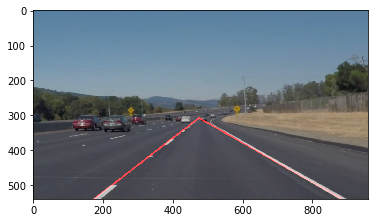

In [17]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

(540, 960, 3)
609.243743852 -16.7038403377 0.669397383438 -0.615089506544
 ===== avg ==== 
Coef:  0.669397383438 Intercept:  -16.7038403377 intersection_x:  487.313330382
line  (487, 309) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.615089506544 Intercept:  609.243743852 intersection_x:  487.313330382
line  (487, 309) (0, 609)
 ===== avg ==== 
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4





  0%|          | 0/682 [00:00<?, ?it/s]

(540, 960, 3)
609.243743852 -16.7038403377 0.669397383438 -0.615089506544
 ===== avg ==== 
Coef:  0.669397383438 Intercept:  -16.7038403377 intersection_x:  487.313330382
line  (487, 309) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.615089506544 Intercept:  609.243743852 intersection_x:  487.313330382
line  (487, 309) (0, 609)
 ===== avg ==== 
(540, 960, 3)
606.400435201 -24.9441273423 0.683137541205 -0.608132619589
 ===== avg ==== 
Coef:  0.683137541205 Intercept:  -24.9441273423 intersection_x:  488.932976005
line  (488, 309) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.608132619589 Intercept:  606.400435201 intersection_x:  488.932976005
line  (488, 309) (0, 606)
 ===== avg ==== 





  0%|          | 2/682 [00:00<00:39, 17.33it/s]

(540, 960, 3)
614.211493985 -15.196479177 0.665469008692 -0.624538360985
 ===== avg ==== 
Coef:  0.665469008692 Intercept:  -15.196479177 intersection_x:  487.910370093
line  (487, 309) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.624538360985 Intercept:  614.211493985 intersection_x:  487.910370093
line  (487, 309) (0, 614)
 ===== avg ==== 
(540, 960, 3)
622.187471302 -20.8815201192 0.674273472429 -0.650716177535
 ===== avg ==== 
Coef:  0.674273472429 Intercept:  -20.8815201192 intersection_x:  485.338879015
line  (485, 306) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.650716177535 Intercept:  622.187471302 intersection_x:  485.338879015
line  (485, 306) 

(0, 622)
 ===== avg ==== 
(540, 960, 3)
616.089816064 -19.7612386634 0.671771972642 -0.635550299176
 ===== avg ==== 
Coef:  0.671771972642 Intercept:  -19.7612386634 intersection_x:  486.376671181




  1%|          | 5/682 [00:00<00:34, 19.49it/s]


line  (486, 306) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.635550299176 Intercept:  616.089816064 intersection_x:  486.376671181
line  (486, 306) (0, 616)
 ===== avg ==== 
(540, 960, 3)
621.349745407 -33.7286821705 0.693798449612 -0.640067377472
 ===== avg ==== 
Coef:  0.693798449612 Intercept:  -33.7286821705 intersection_x:  491.112684856
line  (491, 307) (960, 632)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.640067377472 Intercept:  621.349745407 intersection_x:  491.112684856
line  (491, 307) (0, 621)
 ===== avg ==== 
(540, 960, 3)
618.233607646 -12.6708737864 0.657678729038 -0.632005378839
 ===== avg ==== 
Coef:  0.657678729038 Intercept:  -12.6708737864 intersection_x:  489.193033844
line  (489, 309) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.632005378839 Intercept:  618.233607646 intersection_x:  489.193033844
line  (489, 309) (0, 618)
 ===== avg ==== 
(540, 960, 3)
622.281994543 -19.0489934514 0.664402942841 -0.640522927522
 ===== avg ==== 
Coef:  0.66




  1%|          | 8/682 [00:00<00:31, 21.44it/s]

(540, 960, 3)
620.70830189 -30.6626664506 0.684388083083 -0.638998120517
 ===== avg ==== 
Coef:  0.684388083083 Intercept:  -30.6626664506 intersection_x:  492.200210769
line  (492, 306) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.638998120517 Intercept:  620.70830189 intersection_x:  492.200210769
line  (492, 306) (0, 620)
 ===== avg ==== 
(540, 960, 3)
631.910392282 -16.4109147361 0.65942202054 -0.670926671224
 ===== avg ==== 
Coef:  0.65942202054 Intercept:  -16.4109147361 intersection_x:  487.331863467
line  (487, 304) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.670926671224 Intercept:  631.910392282 intersection_x:  487.331863467
line  (487, 304) (0, 631)
 ===== avg ==== 
(540, 960, 3)
627.55073877 -18.6254317111 0.662323390895 -0.65829782153
 ===== avg ==== 
Coef:  0.662323390895 Intercept:  -18.6254317111 intersection_x:  489.297131079
line  (489, 305) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.65829782153 Intercept:  627.55073877 intersection_x




  2%|▏         | 12/682 [00:00<00:27, 24.18it/s]

 ===== avg ==== 
(540, 960, 3)
626.696286823 -10.5142046051 0.651513242422 -0.661505561541
 ===== avg ==== 
Coef:  0.651513242422 Intercept:  -10.5142046051 intersection_x:  485.301878012
line  (485, 305) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.661505561541 Intercept:  626.696286823 intersection_x:  485.301878012
line  (485, 305) (0, 626)
 ===== avg ==== 
(540, 960, 3)
625.795308187 0.26991099602 0.631654652494 -0.654374820807
 ===== avg ==== 
Coef:  0.631654652494 Intercept:  0.26991099602 intersection_x:  486.400514279
line  (486, 307) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.654374820807 Intercept:  625.795308187 intersection_x:  486.400514279
line  (486, 307) (0, 625)
 ===== avg ==== 
(540, 960, 3)
626.250526557 -21.6302887464 0.665988870159 -0.653553545725
 ===== avg ==== 
Coef:  0.665988870159 Intercept:  -21.6302887464 intersection_x:  490.989003085
line  (490, 305) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.653553545725 Intercept:  626.2




  2%|▏         | 16/682 [00:00<00:24, 27.03it/s]

638.972574491 -0.178231515777 0.631157500742 -0.688986982051
 ===== avg ==== 
Coef:  0.631157500742 Intercept:  -0.178231515777 intersection_x:  484.152162386
line  (484, 305) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688986982051 Intercept:  638.972574491 intersection_x:  484.152162386
line  (484, 305) (0, 638)
 ===== avg ==== 
(540, 960, 3)
635.998808699 31.8970303637 0.586840173507 -0.674742754669
 ===== avg ==== 
Coef:  0.586840173507 Intercept:  31.8970303637 intersection_x:  478.844287477
line  (478, 312) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.674742754669 Intercept:  635.998808699 intersection_x:  478.844287477
line  (478, 312) (0, 635)
 ===== avg ==== 
(540, 960, 3)
636.156058724 -11.5862068966 0.655172413793 -0.679166503515
 ===== avg ==== 
Coef:  0.655172413793 Intercept:  -11.5862068966 intersection_x:  485.44058576
line  (485, 306) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679166503515 Intercept:  636.156058724 intersection_x:  485.




  3%|▎         | 20/682 [00:00<00:22, 29.92it/s]

(540, 960, 3)
637.594109985 -1.28244274809 0.634351145038 -0.681822935189
 ===== avg ==== 
Coef:  0.634351145038 Intercept:  -1.28244274809 intersection_x:  485.404295929
line  (485, 306) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681822935189 Intercept:  637.594109985 intersection_x:  485.404295929
line  (485, 306) (0, 637)
 ===== avg ==== 
(540, 960, 3)
639.0220039 -7.25088864624 0.642535758815 -0.696412537806
 ===== avg ==== 
Coef:  0.642535758815 Intercept:  -7.25088864624 intersection_x:  482.672030113
line  (482, 302) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696412537806 Intercept:  639.0220039 intersection_x:  482.672030113
line  (482, 302) (0, 639)
 ===== avg ==== 
(540, 960, 3)
639.053686637 -2.48958333333 0.632916666667 -0.692156802979
 ===== avg ==== 
Coef:  0.632916666667 Intercept:  -2.48958333333 intersection_x:  484.156754072
line  (484, 303) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692156802979 Intercept:  639.053686637 intersecti




  4%|▎         | 24/682 [00:00<00:20, 32.33it/s]

632.082208492 -10.0932753561 0.647580820904 -0.674236435668
 ===== avg ==== 
Coef:  0.647580820904 Intercept:  -10.0932753561 intersection_x:  485.827735003
line  (485, 304) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.674236435668 Intercept:  632.082208492 intersection_x:  485.827735003
line  (485, 304) (0, 632)
 ===== avg ==== 
(540, 960, 3)
637.018576678 -1.8202764977 0.633256528418 -0.687877017883
 ===== avg ==== 
Coef:  0.633256528418 Intercept:  -1.8202764977 intersection_x:  483.553577883
line  (483, 304) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687877017883 Intercept:  637.018576678 intersection_x:  483.553577883
line  (483, 304) (0, 637)
 ===== avg ==== 
(540, 960, 3)
649.843857369 13.614965819 0.611955138298 -0.710969213741
 ===== avg ==== 
Coef:  0.611955138298 Intercept:  13.614965819 intersection_x:  480.926131996
line  (480, 307) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.710969213741 Intercept:  649.843857369 intersection_x:  480.92613




  4%|▍         | 28/682 [00:00<00:19, 33.69it/s]

(540, 960, 3)
645.075236659 2.17006761117 0.626112244836 -0.700085040641
 ===== avg ==== 
Coef:  0.626112244836 Intercept:  2.17006761117 intersection_x:  484.77340143
line  (484, 305) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.700085040641 Intercept:  645.075236659 intersection_x:  484.77340143
line  (484, 305) (0, 645)
 ===== avg ==== 
(540, 960, 3)
662.497006192 17.6766232696 0.601348879367 -0.749022870382
 ===== avg ==== 
Coef:  0.601348879367 Intercept:  17.6766232696 intersection_x:  477.513235183
line  (477, 304) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.749022870382 Intercept:  662.497006192 intersection_x:  477.513235183
line  (477, 304) (0, 662)
 ===== avg ==== 
(540, 960, 3)
652.521668395 -6.68888888889 0.622222222222 -0.7231621519
 ===== avg ==== 
Coef:  0.622222222222 Intercept:  -6.68888888889 intersection_x:  489.97934714
line  (489, 298) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.7231621519 Intercept:  652.521668395 intersection_x:  




  5%|▍         | 32/682 [00:00<00:18, 34.30it/s]

(540, 960, 3)
652.007473085 1.72173913043 0.626086956522 -0.720397878161
 ===== avg ==== 
Coef:  0.626086956522 Intercept:  1.72173913043 intersection_x:  482.950655815
line  (482, 304) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.720397878161 Intercept:  652.007473085 intersection_x:  482.950655815
line  (482, 304) (0, 652)
 ===== avg ==== 
(540, 960, 3)
656.601143641 16.8 0.6 -0.733027472008
 ===== avg ==== 
Coef:  0.6 Intercept:  16.8 intersection_x:  479.960958852
line  (479, 304) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.733027472008 Intercept:  656.601143641 intersection_x:  479.960958852
line  (479, 304) (0, 656)
 ===== avg ==== 
(540, 960, 3)
654.447883873 12.652173913 0.608695652174 -0.73738780257
 ===== avg ==== 
Coef:  0.608695652174 Intercept:  12.652173913 intersection_x:  476.787458978
line  (476, 302) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73738780257 Intercept:  654.447883873 intersection_x:  476.787458978
line  (476, 302) (0, 654)




  5%|▌         | 36/682 [00:01<00:18, 35.68it/s]

(540, 960, 3)
655.973239708 13.5833333333 0.602272727273 -0.735618715274
 ===== avg ==== 
Coef:  0.602272727273 Intercept:  13.5833333333 intersection_x:  480.150994278
line  (480, 302) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.735618715274 Intercept:  655.973239708 intersection_x:  480.150994278
line  (480, 302) (0, 655)
 ===== avg ==== 
(540, 960, 3)
659.265239952 19.0238590651 0.595158829241 -0.747706120629
 ===== avg ==== 
Coef:  0.595158829241 Intercept:  19.0238590651 intersection_x:  476.772724576
line  (476, 302) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.747706120629 Intercept:  659.265239952 intersection_x:  476.772724576
line  (476, 302) (0, 659)
 ===== avg ==== 
(540, 960, 3)
656.651173012 40.0953577265 0.561607484546 -0.745619955442
 ===== avg ==== 
Coef:  0.561607484546 Intercept:  40.0953577265 intersection_x:  471.651524765
line  (471, 304) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.745619955442 Intercept:  656.651173012 intersection




  6%|▌         | 40/682 [00:01<00:17, 36.85it/s]

(540, 960, 3)
651.435501821 24.4145077326 0.586884521824 -0.728320879914
 ===== avg ==== 
Coef:  0.586884521824 Intercept:  24.4145077326 intersection_x:  476.747581222
line  (476, 304) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.728320879914 Intercept:  651.435501821 intersection_x:  476.747581222
line  (476, 304) (0, 651)
 ===== avg ==== 
(540, 960, 3)
649.996767101 2.94534007415 0.616199528143 -0.727670784758
 ===== avg ==== 
Coef:  0.616199528143 Intercept:  2.94534007415 intersection_x:  481.483533653
line  (481, 299) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727670784758 Intercept:  649.996767101 intersection_x:  481.483533653
line  (481, 299) (0, 649)
 ===== avg ==== 
(540, 960, 3)
650.858096007 58.1138653065 0.543182056388 -0.728222216772
 ===== avg ==== 
Coef:  0.543182056388 Intercept:  58.1138653065 intersection_x:  466.212237298
line  (466, 311) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.728222216772 Intercept:  650.858096007 intersection




  7%|▋         | 45/682 [00:01<00:16, 37.49it/s]

(540, 960, 3)
positive_slope_intercept still empty
(540, 960, 3)
658.32572519 33.1007194245 0.575539568345 -0.746964010492
 ===== avg ==== 
Coef:  0.575539568345 Intercept:  33.1007194245 intersection_x:  472.758649406
line  (472, 305) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.746964010492 Intercept:  658.32572519 intersection_x:  472.758649406
line  (472, 305) (0, 658)
 ===== avg ==== 
(540, 960, 3)
650.600550705 19.2 0.6 -0.727961720323
 ===== avg ==== 
Coef:  0.6 Intercept:  19.2 intersection_x:  475.465927249
line  (475, 304) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727961720323 Intercept:  650.600550705 intersection_x:  475.465927249
line  (475, 304) (0, 650)
 ===== avg ==== 
(540, 960, 3)
651.208390623 9.35950727884 0.611170834889 -0.723775628747
 ===== avg ==== 
Coef:  0.611170834889 Intercept:  9.35950727884 intersection_x:  480.804961718
line  (480, 303) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723775628747 Intercept:  651.208390623 int




  7%|▋         | 49/682 [00:01<00:16, 37.51it/s]

(540, 960, 3)
652.314773141 8.38230976266 0.612210803904 -0.730700413047
 ===== avg ==== 
Coef:  0.612210803904 Intercept:  8.38230976266 intersection_x:  479.504866182
line  (479, 301) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730700413047 Intercept:  652.314773141 intersection_x:  479.504866182
line  (479, 301) (0, 652)
 ===== avg ==== 
(540, 960, 3)
647.02027413 15.9114157447 0.601811768478 -0.721408739177
 ===== avg ==== 
Coef:  0.601811768478 Intercept:  15.9114157447 intersection_x:  476.949121279
line  (476, 302) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.721408739177 Intercept:  647.02027413 intersection_x:  476.949121279
line  (476, 302) (0, 647)
 ===== avg ==== 
(540, 960, 3)
652.300726545 3.51579986833 0.618499012508 -0.740389366143
 ===== avg ==== 
Coef:  0.618499012508 Intercept:  3.51579986833 intersection_x:  477.437983037
line  (477, 298) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740389366143 Intercept:  652.300726545 intersection_x




  8%|▊         | 53/682 [00:01<00:17, 36.93it/s]

(540, 960, 3)
652.922693745 22.3611365702 0.593860568264 -0.740356359147
 ===== avg ==== 
Coef:  0.593860568264 Intercept:  22.3611365702 intersection_x:  472.607972677
line  (472, 303) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740356359147 Intercept:  652.922693745 intersection_x:  472.607972677
line  (472, 303) (0, 652)
 ===== avg ==== 
(540, 960, 3)
649.997341769 26.8083267126 0.588643920669 -0.725711958897
 ===== avg ==== 
Coef:  0.588643920669 Intercept:  26.8083267126 intersection_x:  474.140242187
line  (474, 305) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725711958897 Intercept:  649.997341769 intersection_x:  474.140242187
line  (474, 305) (0, 649)
 ===== avg ==== 
(540, 960, 3)
649.29604541 22.5436173071 0.597458843677 -0.723768192536
 ===== avg ==== 
Coef:  0.597458843677 Intercept:  22.5436173071 intersection_x:  474.371482663
line  (474, 305) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723768192536 Intercept:  649.29604541 intersection_x




  8%|▊         | 57/682 [00:01<00:16, 37.00it/s]

647.496749213 17.4145816221 0.599497693814 -0.717539210503
 ===== avg ==== 
Coef:  0.599497693814 Intercept:  17.4145816221 intersection_x:  478.408893119
line  (478, 304) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717539210503 Intercept:  647.496749213 intersection_x:  478.408893119
line  (478, 304) (0, 647)
 ===== avg ==== 
(540, 960, 3)
646.502296467 48.5 0.554347826087 -0.716449709024
 ===== avg ==== 
Coef:  0.554347826087 Intercept:  48.5 intersection_x:  470.572439705
line  (470, 309) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716449709024 Intercept:  646.502296467 intersection_x:  470.572439705
line  (470, 309) (0, 646)
 ===== avg ==== 
(540, 960, 3)
positive_slope_intercept still empty
(540, 960, 3)
647.584544215 20.0274647887 0.599295774648 -0.71482409094
 ===== avg ==== 
Coef:  0.599295774648 Intercept:  20.0274647887 intersection_x:  477.549343754
line  (477, 306) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71482409094 Intercept:  647.58454




  9%|▉         | 61/682 [00:01<00:16, 37.01it/s]

651.347137995 32.3354037267 0.579192546584 -0.730288534802
 ===== avg ==== 
Coef:  0.579192546584 Intercept:  32.3354037267 intersection_x:  472.715293919
line  (472, 306) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730288534802 Intercept:  651.347137995 intersection_x:  472.715293919
line  (472, 306) (0, 651)
 ===== avg ==== 
(540, 960, 3)
646.039852888 15.826007326 0.607509157509 -0.713262698883
 ===== avg ==== 
Coef:  0.607509157509 Intercept:  15.826007326 intersection_x:  477.155719599
line  (477, 305) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713262698883 Intercept:  646.039852888 intersection_x:  477.155719599
line  (477, 305) (0, 646)
 ===== avg ==== 
(540, 960, 3)
648.740010741 13.781329203 0.609828217404 -0.719132399732
 ===== avg ==== 
Coef:  0.609828217404 Intercept:  13.781329203 intersection_x:  477.785927853
line  (477, 305) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.719132399732 Intercept:  648.740010741 intersection_x:  477.785927853

(540, 960, 3)
642.370701382 4.87103820434 0.624195408559 -0.712921732084
 ===== avg ==== 
Coef:  0.624195408559 Intercept:  4.87103820434 intersection_x:  476.771738092
line  (476, 302) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712921732084 Intercept:  642.370701382 intersection_x:  476.771738092
line  (476, 302) (0, 642)
 ===== avg ==== 
(540, 960, 3)
640.969634171 16.2962199313 0.607903780069 -0.711835760903
 ===== avg ==== 
Coef:  0.607903780069 Intercept:  16.2962199313 intersection_x:  473.330831461
line  (473, 304) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711835760903 Intercept:  640.969634171 intersection_x:  473.330831461
line  (473, 304) (0, 640)
 ===== avg ==== 
(540, 960, 3)
639.126749406 6.32034023888 0.622453394979 -0.700252686626
 ===== avg ==== 
Coef:  0.622453394979 Intercept:  6.32034023888 intersection_x:  478.41800833
line  (478, 304) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.700252686626 Intercept:  639.126749406 intersection_




 10%|▉         | 65/682 [00:01<00:16, 36.73it/s]

(540, 960, 3)
640.347326212 20.3847151323 0.599405717457 -0.706901479284
 ===== avg ==== 
Coef:  0.599405717457 Intercept:  20.3847151323 intersection_x:  474.59174429
line  (474, 304) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706901479284 Intercept:  640.347326212 intersection_x:  474.59174429
line  (474, 304) (0, 640)
 ===== avg ==== 





 10%|█         | 69/682 [00:01<00:16, 36.40it/s]

(540, 960, 3)
645.697258071 28.2049557045 0.590342160732 -0.716576889986
 ===== avg ==== 
Coef:  0.590342160732 Intercept:  28.2049557045 intersection_x:  472.479379673
line  (472, 307) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716576889986 Intercept:  645.697258071 intersection_x:  472.479379673
line  (472, 307) (0, 645)
 ===== avg ==== 
(540, 960, 3)
644.105671429 0.717052432688 0.632262635805 -0.714657222189
 ===== avg ==== 
Coef:  0.632262635805 Intercept:  0.717052432688 intersection_x:  477.674016889
line  (477, 302) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714657222189 Intercept:  644.105671429 intersection_x:  477.674016889
line  (477, 302) (0, 644)
 ===== avg ==== 
(540, 960, 3)
638.679285566 31.1067753002 0.583533447684 -0.693496554281
 ===== avg ==== 
Coef:  0.583533447684 Intercept:  31.1067753002 intersection_x:  475.769957895
line  (475, 308) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.693496554281 Intercept:  638.679285566 intersecti

642.644533603 28.7242424242 0.587878787879 -0.709444815985
 ===== avg ==== 
Coef:  0.587878787879 Intercept:  28.7242424242 intersection_x:  473.220628493
line  (473, 306) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709444815985 Intercept:  642.644533603 intersection_x:  473.220628493
line  (473, 306) (0, 642)
 ===== avg ==== 
(540, 960, 3)
642.466497073 33.0222222222 0.577777777778 -0.701458858115
 ===== avg ==== 
Coef:  0.577777777778 Intercept:  33.0222222222 intersection_x:  476.412461738
line  (476, 308) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701458858115 Intercept:  642.466497073 intersection_x:  476.412461738
line  (476, 308) (0, 642)
 ===== avg ==== 
(540, 960, 3)
645.428416864 16.9971651311 0.607370659107 -0.708832074946
 ===== avg ==== 
Coef:  0.607370659107 Intercept:  16.9971651311 intersection_x:  477.457792386
line  (477, 306) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708832074946 Intercept:  645.428416864 intersection_x:  477.45779




 11%|█         | 73/682 [00:02<00:16, 36.54it/s]

 33.1101937851 intersection_x:  474.146090695
line  (474, 309) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714906796734 Intercept:  648.353058419 intersection_x:  474.146090695
line  (474, 309) (0, 648)
 ===== avg ==== 
(540, 960, 3)
649.579273537 -0.756889962909 0.636798920985 -0.717962066199
 ===== avg ==== 
Coef:  0.636798920985 Intercept:  -0.756889962909 

intersection_x:  480.037563565
line  (480, 304) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717962066199 Intercept:  649.579273537 intersection_x:  480.037563565
line  (480, 304) (0, 649)
 ===== avg ==== 
(540, 960, 3)
642.528733392 20.6534193821 0.605558611934 -0.703606602938
 ===== avg ==== 
Coef:  0.605558611934 Intercept:  20.6534193821 intersection_x:  475.016680053
line  (475, 308) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.703606602938 Intercept:  642.528733392 intersection_x:  475.016680053
line  (475, 308) (0, 642)
 ===== avg ==== 
(540, 960, 3)
643.597537879 18.546379215 0.608181315644 -0.704717964529
 ===== avg ==== 
Coef:  0.608181315644 Intercept:  18.546379215 intersection_x:  476.084622867
line  (476, 308) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.704717964529 Intercept:  643.597537879 intersection_x:  476.084622867
line  (476, 308) (0, 643)
 ===== avg ==== 
(540, 960, 3)
642.162741122 -1.24869791667 0.63888677168 -0.697805005263
 ====




 11%|█▏        | 77/682 [00:02<00:16, 36.25it/s]

(540, 960, 3)
650.591084203 -3.6160981163 0.641957183986 -0.72237107201
 ===== avg ==== 
Coef:  0.641957183986 Intercept:  -3.6160981163 intersection_x:  479.508636902
line  (479, 304) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.72237107201 Intercept:  650.591084203 intersection_x:  479.508636902
line  (479, 304) (0, 650)
 ===== avg ==== 
(540, 960, 3)
643.806387841 3.48011655686 0.633356676802 -0.709803872757
 ===== avg ==== 
Coef:  0.633356676802 Intercept:  3.48011655686 intersection_x:  476.730999503
line  (476, 305) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709803872757 Intercept:  643.806387841 intersection_x:  476.730999503
line  (476, 305) (0, 643)
 ===== avg ==== 
(540, 960, 3)


644.729189208 9.69402241363 0.624743910345 -0.710939678578
 ===== avg ==== 
Coef:  0.624743910345 Intercept:  9.69402241363 intersection_x:  475.438323912
line  (475, 306) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.710939678578 Intercept:  644.729189208 intersection_x:  475.438323912
line  (475, 306) (0, 644)
 ===== avg ==== 
(540, 960, 3)





 12%|█▏        | 81/682 [00:02<00:16, 35.44it/s]

646.547666934 6.18690783807 0.627304048234 -0.715211255285
 ===== avg ==== 
Coef:  0.627304048234 Intercept:  6.18690783807 intersection_x:  476.985817158
line  (476, 305) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715211255285 Intercept:  646.547666934 intersection_x:  476.985817158
line  (476, 305) (0, 646)
 ===== avg ==== 
(540, 960, 3)
637.72608582 15.568233945 0.610665137615 -0.696248209323
 ===== avg ==== 
Coef:  0.610665137615 Intercept:  15.568233945 intersection_x:  476.051341379
line  (476, 306) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696248209323 Intercept:  637.72608582 intersection_x:  476.051341379
line  (476, 306) (0, 637)
 ===== avg ==== 
(540, 960, 3)
643.770642897 -12.6355013067 0.655339748159 -0.708431470237
 ===== avg ==== 
Coef:  0.655339748159 Intercept:  -12.6355013067 intersection_x:  481.316906641
line  (481, 302) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708431470237 Intercept:  643.770642897 intersection_x:  481.3169066




 12%|█▏        | 85/682 [00:02<00:16, 35.81it/s]

(540, 960, 3)
639.884166707 -5.71495726496 0.647094017094 -0.700662134677
 ===== avg ==== 
Coef:  0.647094017094 Intercept:  -5.71495726496 intersection_x:  479.017753415
line  (479, 304) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.700662134677 Intercept:  639.884166707 intersection_x:  479.017753415
line  (479, 304) (0, 639)
 ===== avg ==== 
(540, 960, 3)
645.399087898 0.418939393939 0.637121212121 -0.715189979884
 ===== avg ==== 
Coef:  0.637121212121 Intercept:  0.418939393939 intersection_x:  476.946543308
line  (476, 304) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715189979884 Intercept:  645.399087898 intersection_x:  476.946543308
line  (476, 304) (0, 645)
 ===== avg ==== 
(540, 960, 3)
638.29736558 3.08272599412 0.629550477652 -0.691459015534
 ===== avg ==== 
Coef:  0.629550477652 Intercept:  3.08272599412 intersection_x:  480.855469141
line  (480, 305) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691459015534 Intercept:  638.29736558 intersecti




 13%|█▎        | 89/682 [00:02<00:16, 35.10it/s]

(540, 960, 3)
634.956682005 16.7917907897 0.611845791087 -0.68743521504
 ===== avg ==== 
Coef:  0.611845791087 Intercept:  16.7917907897 intersection_x:  475.774592487
line  (475, 307) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68743521504 Intercept:  634.956682005 intersection_x:  475.774592487
line  (475, 307) (0, 634)
 ===== avg ==== 
(540, 960, 3)
634.026215895 -2.91431442732 0.639725226897 -0.679020411729
 ===== avg ==== 
Coef:  0.639725226897 Intercept:  -2.91431442732 intersection_x:  482.98967721
line  (482, 306) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679020411729 Intercept:  634.026215895 intersection_x:  482.98967721
line  (482, 306) (0, 634)
 ===== avg ==== 
(540, 960, 3)
634.04172802 -0.530328030848 0.639318767661 -0.685805143097
 ===== avg ==== 
Coef:  0.639318767661 Intercept:  -0.530328030848 intersection_x:  478.877523
line  (478, 305) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.685805143097 Intercept:  634.04172802 intersection_x:




 14%|█▎        | 93/682 [00:02<00:16, 35.26it/s]

 -0.6836039567 Intercept:  634.491405375 intersection_x:  479.86168524
line  (479, 306) (0, 634)
 ===== avg ==== 
(540, 960, 3)
633.321735386 7.19490913142 0.631997051753 -0.678625381666
 ===== avg ==== 
Coef:  0.631997051753 Intercept:  7.19490913142 intersection_x:  477.732419566
line  (477, 309) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.678625381666 Intercept:  633.321735386 intersection_x:  477.732419566
line  (477, 309) (0, 633)
 ===== avg ==== 
(540, 960, 3)
638.349351698 -26.0454545455 0.6875 -0.687638177237
 ===== avg ==== 
Coef:  0.6875 Intercept:  -26.0454545455 intersection_x:  483.147669988
line  (483, 306) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687638177237 Intercept:  638.349351698 intersection_x:  483.147669988
line  (483, 306) (0, 638)
 ===== avg ==== 
(540, 960, 3)
636.589606593 23.3894717054 0.603686443792 -0.676427614544
 ===== avg ==== 
Coef:  0.603686443792 Intercept:  23.3894717054 intersection_x:  479.019920838
line  (479, 312) (960, 




 14%|█▍        | 97/682 [00:02<00:16, 35.76it/s]

(540, 960, 3)
641.01749858 -2.52083333333 0.645833333333 -0.692340934201
 ===== avg ==== 
Coef:  0.645833333333 Intercept:  -2.52083333333 intersection_x:  480.907716974
line  (480, 308) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692340934201 Intercept:  641.01749858 intersection_x:  480.907716974
line  (480, 308) (0, 641)
 ===== avg ==== 
(540, 960, 3)
642.119091357 0.571804770027 0.641739234521 -0.694491285948
 ===== avg ==== 
Coef:  0.641739234521 Intercept:  0.571804770027 intersection_x:  480.117222858
line  (480, 308) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.694491285948 Intercept:  642.119091357 intersection_x:  480.117222858
line  (480, 308) (0, 642)
 ===== avg ==== 
(540, 960, 3)
641.386266083 -6.28409090909 0.650189393939 -0.686818451687
 ===== avg ==== 
Coef:  0.650189393939 Intercept:  -6.28409090909 intersection_x:  484.41776846
line  (484, 308) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686818451687 Intercept:  641.386266083 intersect




 15%|█▍        | 101/682 [00:02<00:15, 36.89it/s]

(540, 960, 3)
640.891726853 9.19214493202 0.62327873173 -0.691498453338
 ===== avg ==== 
Coef:  0.62327873173 Intercept:  9.19214493202 intersection_x:  480.461320059
line  (480, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691498453338 Intercept:  640.891726853 intersection_x:  480.461320059
line  (480, 308) (0, 640)
 ===== avg ==== 
(540, 960, 3)
639.392988958 12.4549947571 0.618886888874 -0.687420078445
 ===== avg ==== 
Coef:  0.618886888874 Intercept:  12.4549947571 intersection_x:  479.931600983
line  (479, 309) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687420078445 Intercept:  639.392988958 intersection_x:  479.931600983
line  (479, 309) (0, 639)
 ===== avg ==== 
(540, 960, 3)
646.166108441 4.97163130371 0.630312812111 -0.709593276083
 ===== avg ==== 
Coef:  0.630312812111 Intercept:  4.97163130371 intersection_x:  478.536878656
line  (478, 306) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709593276083 Intercept:  646.166108441 intersection_x




 15%|█▌        | 105/682 [00:02<00:16, 34.91it/s]

Intercept:  13.2848485127 intersection_x:  476.844137175
line  (476, 307) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698684105749 Intercept:  641.029955009 intersection_x:  476.844137175
line  (476, 307) (0, 641)
 ===== avg ==== 
(540, 960, 3)
636.710031046 14.3149736293 0.614760320996 -0.6857404924
 ===== avg ==== 
Coef:  0.614760320996 Intercept:  14.3149736293 intersection_x:  478.5810597
line  (478, 308) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6857404924 Intercept:  636.710031046 intersection_x:  478.5810597
line  (478, 308) (0, 636)
 ===== avg ==== 
(540, 960, 3)
640.620658101 -4.63077889402 0.645055883765 -0.695984693468
 ===== avg ==== 
Coef:  0.645055883765 Intercept:  -4.63077889402 intersection_x:  481.157280361
line  (481, 305) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.695984693468 Intercept:  640.620658101 intersection_x:  481.157280361
line  (481, 305) (0, 640)
 ===== avg ==== 





 16%|█▌        | 109/682 [00:03<00:15, 35.81it/s]

(540, 960, 3)
632.877460938 -2.30263157895 0.63976136578 -0.676774667015
 ===== avg ==== 
Coef:  0.63976136578 Intercept:  -2.30263157895 intersection_x:  482.463128008
line  (482, 306) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.676774667015 Intercept:  632.877460938 intersection_x:  482.463128008
line  (482, 306) (0, 632)
 ===== avg ==== 
(540, 960, 3)
636.272332487 30.7112676056 0.588732394366 -0.686883554779
 ===== avg ==== 
Coef:  0.588732394366 Intercept:  30.7112676056 intersection_x:  474.720518575
line  (474, 310) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686883554779 Intercept:  636.272332487 intersection_x:  474.720518575
line  (474, 310) (0, 636)
 ===== avg ==== 
(540, 960, 3)
636.733628357 18.0313115603 0.608746894379 -0.68479710895
 ===== avg ==== 
Coef:  0.608746894379 Intercept:  18.0313115603 intersection_x:  478.300170078
line  (478, 309) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68479710895 Intercept:  636.733628357 intersection_x




 17%|█▋        | 113/682 [00:03<00:15, 36.80it/s]

(540, 960, 3)
645.092249897 0.489300085599 0.640682874537 -0.701076069665
 ===== avg ==== 
Coef:  0.640682874537 Intercept:  0.489300085599 intersection_x:  480.416361371
line  (480, 308) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701076069665 Intercept:  645.092249897 intersection_x:  480.416361371
line  (480, 308) (0, 645)
 ===== avg ==== 
(540, 960, 3)
639.48423579 9.6756368734 0.624868307721 -0.6872132483
 ===== avg ==== 
Coef:  0.624868307721 Intercept:  9.6756368734 intersection_x:  480.007203841
line  (480, 309) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6872132483 Intercept:  639.48423579 intersection_x:  480.007203841
line  (480, 309) (0, 639)
 ===== avg ==== 
(540, 960, 3)
640.425180185 -5.23287303598 0.647210637192 -0.691686347621
 ===== avg ==== 
Coef:  0.647210637192 Intercept:  -5.23287303598 intersection_x:  482.23131469
line  (482, 306) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691686347621 Intercept:  640.425180185 intersection_x:  

(540, 960, 3)
637.111741654 -4.77187814195 0.645797062103 -0.681749747605
 ===== avg ==== 
Coef:  0.645797062103 Intercept:  -4.77187814195 intersection_x:  483.511101155
line  (483, 307) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681749747605 Intercept:  637.111741654 intersection_x:  483.511101155
line  (483, 307) (0, 637)
 ===== avg ==== 
(540, 960, 3)
653.220102373 5.20099883749 0.621979013705 -0.723710634076
 ===== avg ==== 
Coef:  0.621979013705 Intercept:  5.20099883749 intersection_x:  481.551674714
line  (481, 304) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723710634076 Intercept:  653.220102373 intersection_x:  481.551674714
line  (481, 304) (0, 653)
 ===== avg ==== 
(540, 960, 3)
636.294388011 14.3962422189 0.61558155566 -0.679470522958
 ===== avg ==== 
Coef:  0.61558155566 Intercept:  14.3962422189 intersection_x:  480.210916657
line  (480, 310) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679470522958 Intercept:  636.294388011 intersection




 17%|█▋        | 117/682 [00:03<00:16, 35.28it/s]

 (480, 310) (0, 636)
 ===== avg ==== 
(540, 960, 3)
654.009963306 20.2924123447 0.603348396568 -0.727386275338
 ===== avg ==== 
Coef:  0.603348396568 Intercept:  20.2924123447 intersection_x:  476.216306932
line  (476, 307) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727386275338 Intercept:  654.009963306 intersection_x:  476.216306932
line  (476, 307) (0, 654)
 ===== avg ==== 


(540, 960, 3)
644.23832965 -2.62742049793 0.641619609367 -0.696178100175
 ===== avg ==== 
Coef:  0.641619609367 Intercept:  -2.62742049793 intersection_x:  483.530316679
line  (483, 307) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696178100175 Intercept:  644.23832965 intersection_x:  483.530316679
line  (483, 307) (0, 644)
 ===== avg ==== 
(540, 960, 3)
656.397762518 1.09349593496 0.634727061556 -0.730038844876
 ===== avg ==== 
Coef:  0.634727061556 Intercept:  1.09349593496 intersection_x:  480.158731614
line  (480, 305) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730038844876 Intercept:  656.397762518 intersection_x:  480.158731614
line  (480, 305) (0, 656)
 ===== avg ==== 
(540, 960, 3)
640.474275799 4.07618504797 0.631794433362 -0.690081903841
 ===== avg ==== 
Coef:  0.631794433362 Intercept:  4.07618504797 intersection_x:  481.435420879
line  (481, 308) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690081903841 Intercept:  640.474275799 intersection




 18%|█▊        | 121/682 [00:03<00:16, 34.82it/s]

(540, 960, 3)
644.03547249 -13.9689735552 0.660376979342 -0.699248091833
 ===== avg ==== 
Coef:  0.660376979342 Intercept:  -13.9689735552 intersection_x:  483.960218148
line  (483, 305) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699248091833 Intercept:  644.03547249 intersection_x:  483.960218148
line  (483, 305) (0, 644)
 ===== avg ==== 
(540, 960, 3)
646.26358082 -2.94916485113 0.640885984023 -0.70733393868
 ===== avg ==== 
Coef:  0.640885984023 Intercept:  -2.94916485113 intersection_x:  481.53326823
line  (481, 305) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70733393868 Intercept:  646.26358082 intersection_x:  481.53326823
line  (481, 305) (0, 646)
 ===== avg ==== 
(540, 960, 3)





 18%|█▊        | 125/682 [00:03<00:16, 34.54it/s]

642.276019602 -4.86102584371 0.646755813188 -0.698668723227
 ===== avg ==== 
Coef:  0.646755813188 Intercept:  -4.86102584371 intersection_x:  480.99096451
line  (480, 306) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698668723227 Intercept:  642.276019602 intersection_x:  480.99096451
line  (480, 306) (0, 642)
 ===== avg ==== 
(540, 960, 3)
643.986624047 22.1049166044 0.601505354856 -0.695383259278
 ===== avg ==== 
Coef:  0.601505354856 Intercept:  22.1049166044 intersection_x:  479.518210481
line  (479, 310) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.695383259278 Intercept:  643.986624047 intersection_x:  479.518210481
line  (479, 310) (0, 643)
 ===== avg ==== 
(540, 960, 3)


643.241335513 7.91934803452 0.624870565676 -0.69657959217
 ===== avg ==== 
Coef:  0.624870565676 Intercept:  7.91934803452 intersection_x:  480.776352938
line  (480, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69657959217 Intercept:  643.241335513 intersection_x:  480.776352938
line  (480, 308) (0, 643)
 ===== avg ==== 
(540, 960, 3)
642.539702708 4.63450484841 0.631850291782 -0.695240303653
 ===== avg ==== 
Coef:  0.631850291782 Intercept:  4.63450484841 intersection_x:  480.679465331
line  (480, 308) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.695240303653 Intercept:  642.539702708 intersection_x:  480.679465331
line  (480, 308) (0, 642)
 ===== avg ==== 
(540, 960, 3)
650.133432973 24.9014708269 0.60038815179 -0.708781677852
 ===== avg ==== 
Coef:  0.60038815179 Intercept:  24.9014708269 intersection_x:  477.578957282
line  (477, 311) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708781677852 Intercept:  650.133432973 intersection_x:  477.578957282




 19%|█▉        | 129/682 [00:03<00:15, 35.28it/s]

640.318110572 7.8529603218 0.624790822889 -0.688043192141
 ===== avg ==== 
Coef:  0.624790822889 Intercept:  7.8529603218 intersection_x:  481.755608866
line  (481, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688043192141 Intercept:  640.318110572 intersection_x:  481.755608866
line  (481, 308) (0, 640)
 ===== avg ==== 
(540, 960, 3)
646.078029103 5.47409145691 0.629189985537 -0.704266584188
 ===== avg ==== 
Coef:  0.629189985537 Intercept:  5.47409145691 intersection_x:  480.408550373
line  (480, 307) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.704266584188 Intercept:  646.078029103 intersection_x:  480.408550373
line  (480, 307) (0, 646)
 ===== avg ==== 
(540, 960, 3)
646.383662454 -11.3857415107 0.65407977908 -0.701389922278
 ===== avg ==== 
Coef:  0.65407977908 Intercept:  -11.3857415107 intersection_x:  485.270458872
line  (485, 306) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701389922278 Intercept:  646.383662454 intersection_x:  485.2704588

(540, 960, 3)
653.704983276 2.66386326641 0.633839754024 -0.720300910751
 ===== avg ==== 
Coef:  0.633839754024 Intercept:  2.66386326641 intersection_x:  480.778058694
line  (480, 307) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.720300910751 Intercept:  653.704983276 intersection_x:  480.778058694
line  (480, 307) (0, 653)
 ===== avg ==== 
(540, 960, 3)
647.229180849 0.946605468234 0.634361378946




 20%|█▉        | 133/682 [00:03<00:15, 34.44it/s]

 -0.70467586098
 ===== avg ==== 
Coef:  0.634361378946 Intercept:  0.946605468234 intersection_x:  482.647200623
line  (482, 307) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70467586098 Intercept:  647.229180849 intersection_x:  482.647200623
line  (482, 307) (0, 647)
 ===== avg ==== 
(540, 960, 3)
643.702774348 -14.3588582677 0.659645669291 -0.69544825751
 ===== avg ==== 
Coef:  0.659645669291 Intercept:  -14.3588582677 intersection_x:  485.620678833
line  (485, 305) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69544825751 Intercept:  643.702774348 intersection_x:  485.620678833
line  (485, 305) (0, 643)
 ===== avg ==== 
(540, 960, 3)
645.478348754 12.3328226388 0.617970439798 -0.69711200567
 ===== avg ==== 
Coef:  0.617970439798 Intercept:  12.3328226388 intersection_x:  481.449302511
line  (481, 309) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69711200567 Intercept:  645.478348754 intersection_x:  481.449302511
line  (481, 309) (0, 645)
 ===== avg ===




 20%|██        | 137/682 [00:03<00:15, 35.16it/s]

 0.625030829942 Intercept:  8.89761376249 intersection_x:  480.773411797
line  (480, 309) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.700008869368 Intercept:  645.941470766 intersection_x:  480.773411797
line  (480, 309) (0, 645)
 ===== avg ==== 
(540, 960, 3)
650.046103611 21.3765591398 0.603010752688 -0.708913220842
 ===== avg ==== 
Coef:  0.603010752688 Intercept:  21.3765591398 intersection_x:  479.196628125
line  (479, 310) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708913220842 Intercept:  650.046103611 intersection_x:  479.196628125
line  (479, 310) (0, 650)
 ===== avg ==== 
(540, 960, 3)
646.025924532 10.2980769231 0.621794871795 -0.702436944626
 ===== avg ==== 
Coef:  0.621794871795 Intercept:  10.2980769231 intersection_x:  480.072929623
line  (480, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.702436944626 Intercept:  646.025924532 intersection_x:  480.072929623
line  (480, 308) (0, 646)
 ===== avg ==== 


(540, 960, 3)
654.210004125 9.01604278075 0.622994652406 -0.722987761596
 ===== avg ==== 
Coef:  0.622994652406 Intercept:  9.01604278075 intersection_x:  479.347987487
line  (479, 307) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722987761596 Intercept:  654.210004125 intersection_x:  479.347987487
line  (479, 307) (0, 654)
 ===== avg ==== 
(540, 960, 3)
648.46625008 8.9723249963 0.623603300281 -0.708996857732
 ===== avg ==== 
Coef:  0.623603300281 Intercept:  8.9723249963 intersection_x:  479.88432332
line  (479, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708996857732 Intercept:  648.46625008 intersection_x:  479.88432332
line  (479, 308) (0, 648)
 ===== avg ==== 





 21%|██        | 141/682 [00:04<00:15, 34.62it/s]

(540, 960, 3)
647.760327498 6.11794830955 0.62902738264 -0.714195981165
 ===== avg ==== 
Coef:  0.62902738264 Intercept:  6.11794830955 intersection_x:  477.688518885
line  (477, 306) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714195981165 Intercept:  647.760327498 intersection_x:  477.688518885
line  (477, 306) (0, 647)
 ===== avg ==== 
(540, 960, 3)
642.081816246 30.1351172944 0.597724107398 -0.690585215107
 ===== avg ==== 
Coef:  0.597724107398 Intercept:  30.1351172944 intersection_x:  474.999822063
line  (474, 314) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690585215107 Intercept:  642.081816246 intersection_x:  474.999822063
line  (474, 314) (0, 642)
 ===== avg ==== 


(540, 960, 3)
644.028044213 3.94486964742 0.633306471796 -0.701853467051
 ===== avg ==== 
Coef:  0.633306471796 Intercept:  3.94486964742 intersection_x:  479.405617216
line  (479, 307) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701853467051 Intercept:  644.028044213 intersection_x:  479.405617216
line  (479, 307) (0, 644)
 ===== avg ==== 
(540, 960, 3)
647.66727398 3.88754578755 0.631501831502 -0.70759911666
 ===== avg ==== 
Coef:  0.631501831502 Intercept:  3.88754578755 intersection_x:  480.755188081
line  (480, 307) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70759911666 Intercept:  647.66727398 intersection_x:  480.755188081
line  (480, 307) (0, 647)
 ===== avg ==== 
(540, 960, 3)





 21%|██▏       | 145/682 [00:04<00:16, 31.70it/s]

639.459675524 -4.65886699507 0.645730706076 -0.68518352854
 ===== avg ==== 
Coef:  0.645730706076 Intercept:  -4.65886699507 intersection_x:  483.966979814
line  (483, 307) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68518352854 Intercept:  639.459675524 intersection_x:  483.966979814
line  (483, 307) (0, 639)
 ===== avg ==== 
(540, 960, 3)
641.117850793 8.90459303398 0.623691281833 -0.691018537544
 ===== avg ==== 
Coef:  0.623691281833 Intercept:  8.90459303398 intersection_x:  480.876653114
line  (480, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691018537544 Intercept:  641.117850793 intersection_x:  480.876653114
line  (480, 308) (0, 641)
 ===== avg ==== 
(540, 960, 3)


625.744929305 16.2613559322 0.611525423729 -0.653795345127
 ===== avg ==== 
Coef:  0.611525423729 Intercept:  16.2613559322 intersection_x:  481.683054901
line  (481, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.653795345127 Intercept:  625.744929305 intersection_x:  481.683054901
line  (481, 310) (0, 625)
 ===== avg ==== 
(540, 960, 3)
640.036153117 12.6997377622 0.616695804196 -0.68799350446
 ===== avg ==== 
Coef:  0.616695804196 Intercept:  12.6997377622 intersection_x:  480.832035024
line  (480, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68799350446 Intercept:  640.036153117 intersection_x:  480.832035024
line  (480, 309) (0, 640)
 ===== avg ==== 
(540, 960, 3)
641.083017742 5.24842235745 0.630549921118 -0.689438541885
 ===== avg ==== 
Coef:  0.630549921118 Intercept:  5.24842235745 intersection_x:  481.697085395
line  (481, 308) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689438541885 Intercept:  641.083017742 intersection_x:  481.6970853




 22%|██▏       | 150/682 [00:04<00:15, 33.94it/s]

(540, 960, 3)
650.107833608 15.9096731649 0.612584308612 -0.711082347394
 ===== avg ==== 
Coef:  0.612584308612 Intercept:  15.9096731649 intersection_x:  479.122260552
line  (479, 309) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711082347394 Intercept:  650.107833608 intersection_x:  479.122260552
line  (479, 309) (0, 650)
 ===== avg ==== 
(540, 960, 3)
644.355427462 28.2651897122 0.59273745862 -0.691525753455
 ===== avg ==== 
Coef:  0.59273745862 Intercept:  28.2651897122 intersection_x:  479.722717241
line  (479, 312) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691525753455 Intercept:  644.355427462 intersection_x:  479.722717241
line  (479, 312) (0, 644)
 ===== avg ==== 
(540, 960, 3)
646.390466525 19.4439275071 0.605154929149 -0.698528214321
 ===== avg ==== 
Coef:  0.605154929149 Intercept:  19.4439275071 intersection_x:  480.904077159
line  (480, 310) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698528214321 Intercept:  646.390466525 intersection_x

645.892371019 19.1840511821 0.608578444408 -0.699170869438
 ===== avg ==== 
Coef:  0.608578444408 Intercept:  19.1840511821 intersection_x:  479.2266478
line  (479, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699170869438 Intercept:  645.892371019 intersection_x:  479.2266478
line  (479, 310) (0, 645)
 ===== avg ==== 
(540, 960, 3)
654.485827082 12.549187319 0.618169424275 -0.722453911644
 ===== avg ==== 
Coef:  0.618169424275 Intercept:  12.549187319 intersection_x:  478.83445153
line  (478, 308) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722453911644 Intercept:  654.485827082 intersection_x:  478.83445153
line  (478, 308) (0, 654)
 ===== avg ==== 





 23%|██▎       | 154/682 [00:04<00:15, 33.78it/s]

(540, 960, 3)
655.540983288 13.770721547 0.614466726425 -0.722877313586
 ===== avg ==== 
Coef:  0.614466726425 Intercept:  13.770721547 intersection_x:  479.884190261
line  (479, 308) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722877313586 Intercept:  655.540983288 intersection_x:  479.884190261
line  (479, 308) (0, 655)
 ===== avg ==== 
(540, 960, 3)
648.922467197 32.5634115542 0.587768445929 -0.693367613028
 ===== avg ==== 
Coef:  0.587768445929 Intercept:  32.5634115542 intersection_x:  481.103510696
line  (481, 315) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.693367613028 Intercept:  648.922467197 intersection_x:  481.103510696
line  (481, 315) (0, 648)
 ===== avg ==== 
(540, 960, 3)
648.068462843 37.078503937 0.577401574803 -0.691176013718




 23%|██▎       | 158/682 [00:04<00:14, 35.32it/s]


 ===== avg ==== 
Coef:  0.577401574803 Intercept:  37.078503937 intersection_x:  481.633890141
line  (481, 315) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691176013718 Intercept:  648.068462843 intersection_x:  481.633890141
line  (481, 315) (0, 648)
 ===== avg ==== 
(540, 960, 3)
647.083898394 44.6439974457 0.565293742018 -0.69063654368
 ===== avg ==== 
Coef:  0.565293742018 Intercept:  44.6439974457 intersection_x:  479.676227103
line  (479, 315) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69063654368 Intercept:  647.083898394 intersection_x:  479.676227103
line  (479, 315) (0, 647)
 ===== avg ==== 
(540, 960, 3)
658.666177986 19.3838606615 0.607339726853 -0.723899970848
 ===== avg ==== 
Coef:  0.607339726853 Intercept:  19.3838606615 intersection_x:  480.215785654
line  (480, 311) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723899970848 Intercept:  658.666177986 intersection_x:  480.215785654
line  (480, 311) (0, 658)
 ===== avg ==== 
(540, 960, 3)

646.362623931 36.9154312668 0.578672506739 -0.687547127852
 ===== avg ==== 
Coef:  0.578672506739 Intercept:  36.9154312668 intersection_x:  481.31238532
line  (481, 315) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687547127852 Intercept:  646.362623931 intersection_x:  481.31238532
line  (481, 315) (0, 646)
 ===== avg ==== 
(540, 960, 3)
658.09925876 41.0881496881 0.571001771002 -0.712800270858
 ===== avg ==== 
Coef:  0.571001771002 Intercept:  41.0881496881 intersection_x:  480.612344391
line  (480, 315) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712800270858 Intercept:  658.09925876 intersection_x:  480.612344391
line  (480, 315) (0, 658)
 ===== avg ==== 
(540, 960, 3)
664.424314698 18.2008497372 0.608137112015 -0.734318070585
 ===== avg ==== 
Coef:  0.608137112015 Intercept:  18.2008497372 intersection_x:  481.374330657
line  (481, 310) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.734318070585 Intercept:  664.424314698 intersection_x:  481.374330657




 24%|██▍       | 162/682 [00:04<00:14, 35.37it/s]

(540, 960, 3)
653.695386334 20.3513952564 0.602652591845 -0.708128139799
 ===== avg ==== 
Coef:  0.602652591845 Intercept:  20.3513952564 intersection_x:  483.180730223
line  (483, 311) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708128139799 Intercept:  653.695386334 intersection_x:  483.180730223
line  (483, 311) (0, 653)
 ===== avg ==== 
(540, 960, 3)
661.448391825 26.8713970014 0.591791490992 -0.726528870095
 ===== avg ==== 
Coef:  0.591791490992 Intercept:  26.8713970014 intersection_x:  481.35264656
line  (481, 311) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726528870095 Intercept:  661.448391825 intersection_x:  481.35264656
line  (481, 311) (0, 661)
 ===== avg ==== 
(540, 960, 3)
654.788525111 24.2535607393 0.592878326155 -0.71011958854
 ===== avg ==== 
Coef:  0.592878326155 Intercept:  24.2535607393




 24%|██▍       | 166/682 [00:04<00:14, 36.05it/s]

 intersection_x:  483.910954316
line  (483, 311) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71011958854 Intercept:  654.788525111 intersection_x:  483.910954316
line  (483, 311) (0, 654)
 ===== avg ==== 
(540, 960, 3)
656.908613323 15.3594027048 0.607797140334 -0.716573819946
 ===== avg ==== 
Coef:  0.607797140334 Intercept:  15.3594027048 intersection_x:  484.418059486
line  (484, 309) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716573819946 Intercept:  656.908613323 intersection_x:  484.418059486
line  (484, 309) (0, 656)
 ===== avg ==== 
(540, 960, 3)
646.210036423 34.5154190554 0.577261807262 -0.689158477053
 ===== avg ==== 
Coef:  0.577261807262 Intercept:  34.5154190554 intersection_x:  483.010754758
line  (483, 313) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689158477053 Intercept:  646.210036423 intersection_x:  483.010754758
line  (483, 313) (0, 646)
 ===== avg ==== 


(540, 960, 3)
655.801265354 27.1276914333 0.588344590902 -0.71355658647
 ===== avg ==== 
Coef:  0.588344590902 Intercept:  27.1276914333 intersection_x:  482.888858884
line  (482, 311) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71355658647 Intercept:  655.801265354 intersection_x:  482.888858884
line  (482, 311) (0, 655)
 ===== avg ==== 
(540, 960, 3)
661.860264544 21.6831331896 0.59452918406 -0.717181242985
 ===== avg ==== 
Coef:  0.59452918406 Intercept:  21.6831331896 intersection_x:  488.047604224
line  (488, 311) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717181242985 Intercept:  661.860264544 intersection_x:  488.047604224
line  (488, 311) (0, 661)
 ===== avg ==== 
(540, 960, 3)
661.123932715 34.6330275229 0.577981651376 -0.722431441287
 ===== avg ==== 
Coef:  0.577981651376 Intercept:  34.6330275229 intersection_x:  481.76299418
line  (481, 313) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722431441287 Intercept:  661.123932715 intersection_x:  




 25%|██▍       | 170/682 [00:04<00:13, 36.75it/s]

(540, 960, 3)
661.011341859 32.9926059043 0.575427092479 -0.71867780844
 ===== avg ==== 
Coef:  0.575427092479 Intercept:  32.9926059043 intersection_x:  485.291984838
line  (485, 312) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71867780844 Intercept:  661.011341859 intersection_x:  485.291984838
line  (485, 312) (0, 661)
 ===== avg ==== 
(540, 960, 3)
668.308752047 32.8947368421 0.578947368421 -0.734291022299
 ===== avg ==== 
Coef:  0.578947368421 Intercept:  32.8947368421 intersection_x:  483.852756434
line  (483, 313) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.734291022299 Intercept:  668.308752047 intersection_x:  483.852756434
line  (483, 313) (0, 668)
 ===== avg ==== 


(540, 960, 3)
665.960282602 23.3890122087 0.594783573807 -0.734960210002
 ===== avg ==== 
Coef:  0.594783573807 Intercept:  23.3890122087 intersection_x:  483.229384651
line  (483, 310) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.734960210002 Intercept:  665.960282602 intersection_x:  483.229384651
line  (483, 310) (0, 665)
 ===== avg ==== 
(540, 960, 3)
661.905922251 26.1416572414 0.583339833509 -0.723537882419
 ===== avg ==== 
Coef:  0.583339833509 Intercept:  26.1416572414 intersection_x:  486.475710206
line  (486, 309) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723537882419 Intercept:  661.905922251 intersection_x:  486.475710206
line  (486, 309) (0, 661)
 ===== avg ==== 





 26%|██▌       | 174/682 [00:04<00:14, 34.17it/s]

(540, 960, 3)
669.390783263 22.5368421053 0.589473684211 -0.740805530075
 ===== avg ==== 
Coef:  0.589473684211 Intercept:  22.5368421053 intersection_x:  486.254264677
line  (486, 309) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740805530075 Intercept:  669.390783263 intersection_x:  486.254264677
line  (486, 309) (0, 669)
 ===== avg ==== 
(540, 960, 3)
664.509483595 36.6542681223 0.569160370301 -0.729521775613
 ===== avg ==== 
Coef:  0.569160370301 Intercept:  36.6542681223 intersection_x:  483.455645747
line  (483, 311) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.729521775613 Intercept:  664.509483595 intersection_x:  483.455645747
line  (483, 311) (0, 664)
 ===== avg ==== 
(540, 960, 3)
685.307703424 32.2074419953 0.573072632835 -0.77936929341
 ===== avg ==== 
Coef:  0.573072632835 Intercept:  32.2074419953 intersection_x:  482.904477268
line  (482, 308) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.77936929341 Intercept:  685.307703424 intersection_x




 26%|██▌       | 178/682 [00:05<00:15, 32.22it/s]

(540, 960, 3)
675.8763594 36.0762465996 0.569098788649 -0.75581689546
 ===== avg ==== 
Coef:  0.569098788649 Intercept:  36.0762465996 intersection_x:  482.898738745
line  (482, 310) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.75581689546 Intercept:  675.8763594 intersection_x:  482.898738745
line  (482, 310) (0, 675)
 ===== avg ==== 
(540, 960, 3)
679.729388273 45.067824833 0.555081534453 -0.764928465143
 ===== avg ==== 
Coef:  0.555081534453 Intercept:  45.067824833 intersection_x:  480.800572446
line  (480, 311) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.764928465143 Intercept:  679.729388273 intersection_x:  480.800572446
line  (480, 311) (0, 679)
 ===== avg ==== 
(540, 960, 3)





 27%|██▋       | 182/682 [00:05<00:15, 32.70it/s]

682.316688833 55.931884058 0.538405797101 -0.772936598207
 ===== avg ==== 
Coef:  0.538405797101 Intercept:  55.931884058 intersection_x:  477.666860323
line  (477, 313) (960, 572)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.772936598207 Intercept:  682.316688833 intersection_x:  477.666860323
line  (477, 313) (0, 682)
 ===== avg ==== 
(540, 960, 3)
672.064283657 31.5196078431 0.578431372549 -0.744595865458
 ===== avg ==== 
Coef:  0.578431372549 Intercept:  31.5196078431 intersection_x:  484.150784967
line  (484, 311) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.744595865458 Intercept:  672.064283657 intersection_x:  484.150784967
line  (484, 311) (0, 672)
 ===== avg ==== 
(540, 960, 3)


676.399520244 61.53125 0.53125 -0.763237836042
 ===== avg ==== 
Coef:  0.53125 Intercept:  61.53125 intersection_x:  474.989608341
line  (474, 313) (960, 571)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.763237836042 Intercept:  676.399520244 intersection_x:  474.989608341
line  (474, 313) (0, 676)
 ===== avg ==== 
(540, 960, 3)
681.412515845 38.1020487957 0.564943697216 -0.769588518275
 ===== avg ==== 
Coef:  0.564943697216 Intercept:  38.1020487957 intersection_x:  482.049409959
line  (482, 310) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.769588518275 Intercept:  681.412515845 intersection_x:  482.049409959
line  (482, 310) (0, 681)
 ===== avg ==== 
(540, 960, 3)
678.224045124 53.2954022989 0.543908045977 -0.762404198537
 ===== avg ==== 
Coef:  0.543908045977 Intercept:  53.2954022989 intersection_x:  478.391476042
line  (478, 313) (960, 575)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.762404198537 Intercept:  678.224045124 intersection_x:  478.391476042
line  (478, 313) (0




 27%|██▋       | 186/682 [00:05<00:15, 32.26it/s]

(540, 960, 3)
689.285314036 39.4369659616 0.564784983891 -0.789397909534
 ===== avg ==== 
Coef:  0.564784983891 Intercept:  39.4369659616 intersection_x:  479.882260534
line  (479, 310) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.789397909534 Intercept:  689.285314036 intersection_x:  479.882260534
line  (479, 310) (0, 689)
 ===== avg ==== 
(540, 960, 3)
679.008363871 48.9959011973 0.551450760436 -0.766394314487
 ===== avg ==== 
Coef:  0.551450760436 Intercept:  48.9959011973 intersection_x:  478.062614993
line  (478, 312) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.766394314487 Intercept:  679.008363871 intersection_x:  478.062614993
line  (478, 312) (0, 679)
 ===== avg ==== 
(540, 960, 3)


682.868387758 40.7227096511 0.562844317486 -0.774606382367
 ===== avg ==== 
Coef:  0.562844317486 Intercept:  40.7227096511 intersection_x:  480.126615641
line  (480, 310) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.774606382367 Intercept:  682.868387758 intersection_x:  480.126615641
line  (480, 310) (0, 682)
 ===== avg ==== 
(540, 960, 3)
679.27644626 46.368066005 0.551555208652 -0.767771547137
 ===== avg ==== 
Coef:  0.551555208652 Intercept:  46.368066005 intersection_x:  479.720719282
line  (479, 310) (960, 575)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.767771547137 Intercept:  679.27644626 intersection_x:  479.720719282
line  (479, 310) (0, 679)
 ===== avg ==== 
(540, 960, 3)
679.593536942 




 28%|██▊       | 190/682 [00:05<00:14, 33.02it/s]

47.5181291133 0.554273389012 -0.767578163683
 ===== avg ==== 
Coef:  0.554273389012 Intercept:  47.5181291133 intersection_x:  478.17427497
line  (478, 312) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.767578163683 Intercept:  679.593536942 intersection_x:  478.17427497
line  (478, 312) (0, 679)
 ===== avg ==== 
(540, 960, 3)
678.280028499 32.2838091693 0.573410845714 -0.762943707486
 ===== avg ==== 
Coef:  0.573410845714 Intercept:  32.2838091693 intersection_x:  483.401817118
line  (483, 309) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.762943707486 Intercept:  678.280028499 intersection_x:  483.401817118
line  (483, 309) (0, 678)
 ===== avg ==== 
(540, 960, 3)
683.574764356 40.6909793542 0.563970680372 -0.775167624432
 ===== avg ==== 
Coef:  0.563970680372 Intercept:  40.6909793542 intersection_x:  480.072732365
line  (480, 311) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.775167624432 Intercept:  683.574764356 intersection_x:  480.072732365
line  (480,




 28%|██▊       | 194/682 [00:05<00:14, 34.02it/s]

(540, 960, 3)
680.084657143 45.2545207651 0.558856774164 -0.768886748954
 ===== avg ==== 
Coef:  0.558856774164 Intercept:  45.2545207651 intersection_x:  478.127082019
line  (478, 312) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.768886748954 Intercept:  680.084657143 intersection_x:  478.127082019
line  (478, 312) (0, 680)
 ===== avg ==== 
(540, 960, 3)
686.007879747 61.9514563107 0.533980582524 -0.7787157173
 ===== avg ==== 
Coef:  0.533980582524 Intercept:  61.9514563107 intersection_x:  475.400458979
line  (475, 315) (960, 574)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.7787157173 Intercept:  686.007879747 intersection_x:  475.400458979
line  (475, 315) (0, 686)
 ===== avg ==== 
(540, 960, 3)
683.613635669 61.5767768162 0.530356674534 -0.781728769466
 ===== avg ==== 
Coef:  0.530356674534 Intercept:  61.5767768162 intersection_x:  474.082584863
line  (474, 313) (960, 570)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781728769466 Intercept:  683.613635669 intersection_x: 




 29%|██▉       | 198/682 [00:05<00:14, 33.88it/s]

(540, 960, 3)
675.992449918 49.0042795892 0.554035546363 -0.759346593553
 ===== avg ==== 
Coef:  0.554035546363 Intercept:  49.0042795892 intersection_x:  477.384419411
line  (477, 313) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.759346593553 Intercept:  675.992449918 intersection_x:  477.384419411
line  (477, 313) (0, 675)
 ===== avg ==== 
(540, 960, 3)
679.153648483 39.061216872 0.56718924972 -0.767941811438
 ===== avg ==== 
Coef:  0.56718924972 Intercept:  39.061216872 intersection_x:  479.422919766
line  (479, 310) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.767941811438 Intercept:  679.153648483 intersection_x:  479.422919766
line  (479, 310) (0, 679)
 ===== avg ==== 
(540, 960, 3)


677.50052354 58.9697168907 0.540028917898 -0.77089115406
 ===== avg ==== 
Coef:  0.540028917898 Intercept:  58.9697168907 intersection_x:  471.82953399
line  (471, 313) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.77089115406 Intercept:  677.50052354 intersection_x:  471.82953399
line  (471, 313) (0, 677)
 ===== avg ==== 
(540, 960, 3)
678.327253906 48.1474331509 0.558995193372 -0.771043154721
 ===== avg ==== 
Coef:  0.558995193372 Intercept:  48.1474331509 intersection_x:  473.805752788
line  (473, 313) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.771043154721 Intercept:  678.327253906 intersection_x:  473.805752788
line  (473, 313) (0, 678)
 ===== avg ==== 
(540, 960, 3)
673.436496742 30.5318514503 0.584566729918 -0.764199151507
 ===== avg ==== 
Coef:  0.584566729918 Intercept:  30.5318514503 intersection_x:  476.661408882
line  (476, 309) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.764199151507 Intercept:  673.436496742 intersection_x:  476.661408882
l




 30%|██▉       | 203/682 [00:05<00:13, 35.71it/s]

(540, 960, 3)
671.894371468 47.3835163676 0.561324957516 -0.760401029925
 ===== avg ==== 
Coef:  0.561324957516 Intercept:  47.3835163676 intersection_x:  472.49646374
line  (472, 312) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.760401029925 Intercept:  671.894371468 intersection_x:  472.49646374
line  (472, 312) (0, 671)
 ===== avg ==== 
(540, 960, 3)
680.146736275 55.5767376649 0.544045575322 -0.781601136946
 ===== avg ==== 
Coef:  0.544045575322 Intercept:  55.5767376649 intersection_x:  471.143625846
line  (471, 311) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781601136946 Intercept:  680.146736275 intersection_x:  471.143625846
line  (471, 311) (0, 680)
 ===== avg ==== 
(540, 960, 3)
673.598355933 43.5429089205 0.567814825117 -0.766741237869
 ===== avg ==== 
Coef:  0.567814825117 Intercept:  43.5429089205 intersection_x:  472.108639335
line  (472, 311) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.766741237869 Intercept:  673.598355933 intersection_x

(540, 960, 3)
667.759950658 46.7577339444 0.560490965673 -0.745654907045
 ===== avg ==== 
Coef:  0.560490965673 Intercept:  46.7577339444 intersection_x:  475.446295613
line  (475, 313) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.745654907045 Intercept:  667.759950658 intersection_x:  475.446295613
line  (475, 313) (0, 667)
 ===== avg ==== 
(540, 960, 3)
668.425474853 53.3986881083 0.55150232755 -0.743499741635
 ===== avg ==== 
Coef:  0.55150232755 Intercept:  53.3986881083 intersection_x:  474.923400803
line  (474, 315) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.743499741635 Intercept:  668.425474853 intersection_x:  474.923400803
line  (474, 315) (0, 668)
 ===== avg ==== 





 30%|███       | 207/682 [00:05<00:13, 34.41it/s]

(540, 960, 3)
666.146609754 31.8473559473 0.586320545104 -0.737654170175
 ===== avg ==== 
Coef:  0.586320545104 Intercept:  31.8473559473 intersection_x:  479.087135492
line  (479, 312) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737654170175 Intercept:  666.146609754 intersection_x:  479.087135492
line  (479, 312) (0, 666)
 ===== avg ==== 
(540, 960, 3)
669.357009701 52.4852427184 0.55213592233 -0.754349856118
 ===== avg ==== 
Coef:  0.55213592233 Intercept:  52.4852427184 intersection_x:  472.161103595
line  (472, 313) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.754349856118 Intercept:  669.357009701 intersection_x:  472.161103595
line  (472, 313) (0, 669)
 ===== avg ==== 





 31%|███       | 211/682 [00:06<00:14, 33.59it/s]

(540, 960, 3)
664.865691012 46.5919877749 0.560895707237 -0.741030701946
 ===== avg ==== 
Coef:  0.560895707237 Intercept:  46.5919877749 intersection_x:  474.891436932
line  (474, 312) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.741030701946 Intercept:  664.865691012 intersection_x:  474.891436932
line  (474, 312) (0, 664)
 ===== avg ==== 
(540, 960, 3)
659.228222167 30.8211620913 0.587664413923 -0.721577941312
 ===== avg ==== 
Coef:  0.587664413923 Intercept:  30.8211620913 intersection_x:  479.977643225
line  (479, 312) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.721577941312 Intercept:  659.228222167 intersection_x:  479.977643225
line  (479, 312) (0, 659)
 ===== avg ==== 
(540, 960, 3)
662.066504391 29.7840277778 0.591435185185 -0.740474224615
 ===== avg ==== 
Coef:  0.591435185185 Intercept:  29.7840277778 intersection_x:  474.718829945
line  (474, 310) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740474224615 Intercept:  662.066504391 intersection

(540, 960, 3)
663.190519719 28.9803143499 0.591649307471 -0.739353329013
 ===== avg ==== 
Coef:  0.591649307471 Intercept:  28.9803143499 intersection_x:  476.49057033
line  (476, 310) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.739353329013 Intercept:  663.190519719 intersection_x:  476.49057033
line  (476, 310) (0, 663)
 ===== avg ==== 
(540, 960, 3)
664.225376941 32.0897647487 0.588870208016 -0.744730279594
 ===== avg ==== 
Coef:  0.588870208016 Intercept:  32.0897647487 intersection_x:  474.006734449
line  (474, 311) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.744730279594 Intercept:  664.225376941 intersection_x:  474.006734449
line  (474, 311) (0, 664)
 ===== avg ==== 
(540, 960, 3)
659.725877911 37.2016594448 0.576200386213 -0.728212986649
 ===== avg ==== 
Coef:  0.576200386213 Intercept:  37.2016594448 intersection_x:  477.244584744
line  (477, 312) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.728212986649 Intercept:  659.725877911 intersection_x




 32%|███▏      | 215/682 [00:06<00:14, 31.84it/s]

(540, 960, 3)
664.875844073 32.5901726996 0.587820135807 -0.742714034847
 ===== avg ==== 
Coef:  0.587820135807 Intercept:  32.5901726996 intersection_x:  475.211900091
line  (475, 311) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.742714034847 Intercept:  664.875844073 intersection_x:  475.211900091
line  (475, 311) (0, 664)
 ===== avg ==== 
(540, 960, 3)
655.98017156 59.1195297196 0.546674320571 -0.723329040069
 ===== avg ==== 
Coef:  0.546674320571 Intercept:  59.1195297196 intersection_x:  469.967765707
line  (469, 316) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723329040069 Intercept:  655.98017156 intersection_x:  469.967765707
line  (469, 316) (0, 655)
 ===== avg ==== 
(540, 960, 3)
659.055773857 37.9309940223 0.581243118408 -0.73217126944
 ===== avg ==== 
Coef:  0.581243118408 Intercept:  37.9309940223 intersection_x:  472.908463301
line  (472, 312) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73217126944 Intercept:  659.055773857 intersection_x: 




 32%|███▏      | 219/682 [00:06<00:15, 30.57it/s]

(540, 960, 3)
665.045582147 39.4885714286 0.577142857143 -0.743673666887
 ===== avg ==== 
Coef:  0.577142857143 Intercept:  39.4885714286 intersection_x:  473.613858805
line  (473, 312) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.743673666887 Intercept:  665.045582147 intersection_x:  473.613858805
line  (473, 312) (0, 665)
 ===== avg ==== 
(540, 960, 3)
659.282097404 31.0342723005 0.591431924883 -0.730938090269
 ===== avg ==== 
Coef:  0.591431924883 Intercept:  31.0342723005 intersection_x:  475.092309947
line  (475, 312) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730938090269 Intercept:  659.282097404 intersection_x:  475.092309947
line  (475, 312) (0, 659)
 ===== avg ==== 





 33%|███▎      | 223/682 [00:06<00:15, 30.15it/s]

(540, 960, 3)
660.691313138 29.5543858388 0.591020161604 -0.73180836689
 ===== avg ==== 
Coef:  0.591020161604 Intercept:  29.5543858388 intersection_x:  477.111669203
line  (477, 311) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73180836689 Intercept:  660.691313138 intersection_x:  477.111669203
line  (477, 311) (0, 660)
 ===== avg ==== 
(540, 960, 3)
656.814844894 18.7771160549 0.610458555644 -0.726014548489
 ===== avg ==== 
Coef:  0.610458555644 Intercept:  18.7771160549 intersection_x:  477.404092058
line  (477, 310) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726014548489 Intercept:  656.814844894 intersection_x:  477.404092058
line  (477, 310) (0, 656)
 ===== avg ==== 
(540, 960, 3)
651.776319261 17.077020202 0.61047979798 -0.708953894559
 ===== avg ==== 
Coef:  0.61047979798 Intercept:  17.077020202 intersection_x:  481.039178132
line  (481, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708953894559 Intercept:  651.776319261 intersection_x:  4

(540, 960, 3)
662.797682068 29.2222847561 0.591347089892 -0.738733831985
 ===== avg ==== 
Coef:  0.591347089892 Intercept:  29.2222847561 intersection_x:  476.343496768
line  (476, 310) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738733831985 Intercept:  662.797682068 intersection_x:  476.343496768
line  (476, 310) (0, 662)
 ===== avg ==== 
(540, 960, 3)





 33%|███▎      | 227/682 [00:06<00:14, 30.86it/s]

659.448537263 32.802919678 0.589775016479 -0.72982826955
 ===== avg ==== 
Coef:  0.589775016479 Intercept:  32.802919678 intersection_x:  474.874247601
line  (474, 312) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.72982826955 Intercept:  659.448537263 intersection_x:  474.874247601
line  (474, 312) (0, 659)
 ===== avg ==== 
(540, 960, 3)
661.012862214 12.5875237271 0.614988117024 -0.736342665069
 ===== avg ==== 
Coef:  0.614988117024 Intercept:  12.5875237271 intersection_x:  479.842054277
line  (479, 307) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.736342665069 Intercept:  661.012862214 intersection_x:  479.842054277
line  (479, 307) (0, 661)
 ===== avg ==== 
(540, 960, 3)





 34%|███▍      | 231/682 [00:06<00:13, 32.50it/s]

651.248077661 40.32110851 0.571032767605 -0.712211921874
 ===== avg ==== 
Coef:  0.571032767605 Intercept:  40.32110851 intersection_x:  476.079873277
line  (476, 312) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712211921874 Intercept:  651.248077661 intersection_x:  476.079873277
line  (476, 312) (0, 651)
 ===== avg ==== 
(540, 960, 3)
661.638417314 19.7036270771 0.60468788278 -0.738919603915
 ===== avg ==== 
Coef:  0.60468788278 Intercept:  19.7036270771 intersection_x:  477.769584193
line  (477, 308) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738919603915 Intercept:  661.638417314 intersection_x:  477.769584193
line  (477, 308) (0, 661)
 ===== avg ==== 
(540, 960, 3)
667.48773541 17.8070284803 0.610853953064 -0.750874043074
 ===== avg ==== 
Coef:  0.610853953064 Intercept:  17.8070284803 intersection_x:  477.100205601
line  (477, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.750874043074 Intercept:  667.48773541 intersection_x:  477.100205601
lin

(540, 960, 3)
651.487248638 18.1969072165 0.609278350515 -0.713787770594
 ===== avg ==== 
Coef:  0.609278350515 Intercept:  18.1969072165 intersection_x:  478.653584516
line  (478, 309) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713787770594 Intercept:  651.487248638 intersection_x:  478.653584516
line  (478, 309) (0, 651)
 ===== avg ==== 
(540, 960, 3)
644.273918221 16.2929615147 0.61206009467 -0.696109419151
 ===== avg ==== 
Coef:  0.61206009467 Intercept:  16.2929615147 intersection_x:  480.045552256
line  (480, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696109419151 Intercept:  644.273918221 intersection_x:  480.045552256
line  (480, 310) (0, 644)
 ===== avg ==== 





 34%|███▍      | 235/682 [00:06<00:13, 34.08it/s]


 35%|███▌      | 239/682 [00:06<00:12, 35.55it/s]

(540, 960, 3)
646.830434803 18.3754701052 0.60710722235 -0.705150066228
 ===== avg ==== 
Coef:  0.60710722235 Intercept:  18.3754701052 intersection_x:  478.911391972
line  (478, 309) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.705150066228 Intercept:  646.830434803 intersection_x:  478.911391972
line  (478, 309) (0, 646)
 ===== avg ==== 
(540, 960, 3)
649.546709179 8.10275229358 0.621100917431 -0.720151529945
 ===== avg ==== 
Coef:  0.621100917431 Intercept:  8.10275229358 intersection_x:  478.242524843
line  (478, 305) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.720151529945 Intercept:  649.546709179 intersection_x:  478.242524843
line  (478, 305) (0, 649)
 ===== avg ==== 
(540, 960, 3)
643.743218672 25.9481478558 0.592293809041 -0.702782735557
 ===== avg ==== 
Coef:  0.592293809041 Intercept:  25.9481478558 intersection_x:  477.033634338
line  (477, 308) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.702782735557 Intercept:  643.743218672 intersection_x

(540, 960, 3)
646.756184068 25.1545816848 0.591412229701 -0.704221115598
 ===== avg ==== 
Coef:  0.591412229701 Intercept:  25.1545816848 intersection_x:  479.766598041
line  (479, 308) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.704221115598 Intercept:  646.756184068 intersection_x:  479.766598041
line  (479, 308) (0, 646)
 ===== avg ==== 
(540, 960, 3)
644.953435477 36.7128042328 0.576402116402 -0.702780168185
 ===== avg ==== 
Coef:  0.576402116402 Intercept:  36.7128042328 intersection_x:  475.491756392
line  (475, 310) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.702780168185 Intercept:  644.953435477 intersection_x:  475.491756392
line  (475, 310) (0, 644)
 ===== avg ==== 





 36%|███▌      | 243/682 [00:07<00:12, 35.71it/s]

(540, 960, 3)
640.409892572 50.9889680795 0.55208886193 -0.685376573203
 ===== avg ==== 
Coef:  0.55208886193 Intercept:  50.9889680795 intersection_x:  476.313040961
line  (476, 313) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.685376573203 Intercept:  640.409892572 intersection_x:  476.313040961
line  (476, 313) (0, 640)
 ===== avg ==== 
(540, 960, 3)
645.397947418 38.8846153846 0.576923076923 -0.697269264063
 ===== avg ==== 
Coef:  0.576923076923 Intercept:  38.8846153846 intersection_x:  475.998255933
line  (475, 313) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.697269264063 Intercept:  645.397947418 intersection_x:  475.998255933
line  (475, 313) (0, 645)
 ===== avg ==== 
(540, 960, 3)
662.613617886 45.262195122 0.565447154472 -0.739136178862
 ===== avg ==== 
Coef:  0.565447154472 Intercept:  45.262195122 intersection_x:  473.217315437
line  (473, 312) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.739136178862 Intercept:  662.613617886 intersection_x: 




 36%|███▌      | 247/682 [00:07<00:12, 35.15it/s]

663.563036437 22.3017347531 0.604921158882 -0.739539320329
 ===== avg ==== 
Coef:  0.604921158882 Intercept:  22.3017347531 intersection_x:  476.965527511
line  (476, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.739539320329 Intercept:  663.563036437 intersection_x:  476.965527511
line  (476, 310) (0, 663)
 ===== avg ==== 
(540, 960, 3)
660.624087035 34.6715686275 0.583333333333 -0.73387746071
 ===== avg ==== 
Coef:  0.583333333333 Intercept:  34.6715686275 intersection_x:  475.21058986
line  (475, 311) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73387746071 Intercept:  660.624087035 intersection_x:  475.21058986
line  (475, 311) (0, 660)
 ===== avg ==== 


(540, 960, 3)
654.51643198 46.2575120192 0.565805288462 -0.719887093793
 ===== avg ==== 
Coef:  0.565805288462 Intercept:  46.2575120192 intersection_x:  473.098330795
line  (473, 313) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.719887093793 Intercept:  654.51643198 intersection_x:  473.098330795
line  (473, 313) (0, 654)
 ===== avg ==== 
(540, 960, 3)
646.038005128 22.9098531765 0.600794114286 -0.696477610404
 ===== avg ==== 
Coef:  0.600794114286 Intercept:  22.9098531765 intersection_x:  480.337418979
line  (480, 311) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696477610404 Intercept:  646.038005128 intersection_x:  480.337418979
line  (480, 311) (0, 646)
 ===== avg ==== 





 37%|███▋      | 251/682 [00:07<00:12, 35.07it/s]

(540, 960, 3)
657.694671124 43.2292570394 0.570661498507 -0.726429154062
 ===== avg ==== 
Coef:  0.570661498507 Intercept:  43.2292570394 intersection_x:  473.725882511
line  (473, 313) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726429154062 Intercept:  657.694671124 intersection_x:  473.725882511
line  (473, 313) (0, 657)
 ===== avg ==== 
(540, 960, 3)
662.135041025 21.3982417509 0.606995597958 -0.740540665609
 ===== avg ==== 
Coef:  0.606995597958 Intercept:  21.3982417509 intersection_x:  475.487611426
line  (475, 310) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740540665609 Intercept:  662.135041025 intersection_x:  475.487611426
line  (475, 310) (0, 662)
 ===== avg ==== 
(540, 960, 3)
646.48350604 31.7598117908 0.58926126607 -0.699548063441
 ===== avg ==== 
Coef:  0.58926126607 Intercept:  31.7598117908 intersection_x:  476.970239254
line  (476, 312) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699548063441 Intercept:  646.48350604 intersection_x: 

650.539494549 44.3267235734 0.575446785838 -0.702767203276
 ===== avg ==== 
Coef:  0.575446785838 Intercept:  44.3267235734 intersection_x:  474.265479911
line  (474, 317) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.702767203276 Intercept:  650.539494549 intersection_x:  474.265479911
line  (474, 317) (0, 650)
 ===== avg ==== 
(540, 960, 3)
660.341054322 22.9437143317 0.604465795258 -0.733292539293
 ===== avg ==== 
Coef:  0.604465795258 Intercept:  22.9437143317 intersection_x:  476.466730595
line  (476, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.733292539293 Intercept:  660.341054322 intersection_x:  476.466730595
line  (476, 310) (0, 660)
 ===== avg ==== 





 37%|███▋      | 255/682 [00:07<00:12, 34.08it/s]

(540, 960, 3)
658.121097968 33.3581621838 0.58647957982 -0.729464222588
 ===== avg ==== 
Coef:  0.58647957982 Intercept:  33.3581621838 intersection_x:  474.76414619
line  (474, 311) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.729464222588 Intercept:  658.121097968 intersection_x:  474.76414619
line  (474, 311) (0, 658)
 ===== avg ==== 
(540, 960, 3)
654.345399074 14.6375072747 0.617929159117 -0.723254820028
 ===== avg ==== 
Coef:  0.617929159117 Intercept:  14.6375072747 intersection_x:  476.972512158
line  (476, 309) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723254820028 Intercept:  654.345399074 intersection_x:  476.972512158
line  (476, 309) (0, 654)
 ===== avg ==== 





 38%|███▊      | 259/682 [00:07<00:12, 34.87it/s]

(540, 960, 3)
658.657610567 11.498495212 0.621842225262 -0.730716896842
 ===== avg ==== 
Coef:  0.621842225262 Intercept:  11.498495212 intersection_x:  478.470112529
line  (478, 309) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730716896842 Intercept:  658.657610567 intersection_x:  478.470112529
line  (478, 309) (0, 658)
 ===== avg ==== 
(540, 960, 3)
656.270411468 35.4256410256 0.582564102564 -0.726257738714
 ===== avg ==== 
Coef:  0.582564102564 Intercept:  35.4256410256 intersection_x:  474.35391958
line  (474, 311) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726257738714 Intercept:  656.270411468 intersection_x:  474.35391958
line  (474, 311) (0, 656)
 ===== avg ==== 
(540, 960, 3)
657.017979238 18.0441901891 0.610578240614 -0.726162429394
 ===== avg ==== 
Coef:  0.610578240614 Intercept:  18.0441901891 intersection_x:  478.008789128
line  (478, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.726162429394 Intercept:  657.017979238 intersection_x: 

657.433291463 17.9467556963 0.61103698126 -0.728340767359
 ===== avg ==== 
Coef:  0.61103698126 Intercept:  17.9467556963 intersection_x:  477.450470135
line  (477, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.728340767359 Intercept:  657.433291463 intersection_x:  477.450470135
line  (477, 309) (0, 657)
 ===== avg ==== 
(540, 960, 3)
660.658849902 20.9949812133 0.60694881198 -0.73419543367
 ===== avg ==== 
Coef:  0.60694881198 Intercept:  20.9949812133 intersection_x:  476.953818177
line  (476, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73419543367 Intercept:  660.658849902 intersection_x:  476.953818177
line  (476, 310) (0, 660)
 ===== avg ==== 
(540, 960, 3)
662.558713692 12.3897658171 0.618061844999 -0.738587551213
 ===== avg ==== 
Coef:  0.618061844999 Intercept:  12.3897658171 intersection_x:  479.246111552
line  (479, 308) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738587551213 Intercept:  662.558713692 intersection_x:  479.246111552
l




 39%|███▊      | 263/682 [00:07<00:11, 35.40it/s]

(540, 960, 3)
653.383806363 26.5704215235 0.594290372874 -0.714403289706
 ===== avg ==== 
Coef:  0.594290372874 Intercept:  26.5704215235 intersection_x:  478.96112189
line  (478, 311) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714403289706 Intercept:  653.383806363 intersection_x:  478.96112189
line  (478, 311) (0, 653)
 ===== avg ==== 





 39%|███▉      | 267/682 [00:07<00:11, 35.09it/s]

(540, 960, 3)
658.667088398 16.3465512978 0.609713969749 -0.731098398291
 ===== avg ==== 
Coef:  0.609713969749 Intercept:  16.3465512978 intersection_x:  479.053260852
line  (479, 308) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.731098398291 Intercept:  658.667088398 intersection_x:  479.053260852
line  (479, 308) (0, 658)
 ===== avg ==== 
(540, 960, 3)
671.494696869 16.2892840638 0.606902628159 -0.765568796126
 ===== avg ==== 
Coef:  0.606902628159 Intercept:  16.2892840638 intersection_x:  477.390932308
line  (477, 306) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.765568796126 Intercept:  671.494696869 intersection_x:  477.390932308
line  (477, 306) (0, 671)
 ===== avg ==== 
(540, 960, 3)
653.290944936 35.2321051029 0.579184891546 -0.721026365721
 ===== avg ==== 
Coef:  0.579184891546 Intercept:  35.2321051029 intersection_x:  475.352629336
line  (475, 310) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.721026365721 Intercept:  653.290944936 intersection

9.38081391172 0.617840182728 -0.70073886302
 ===== avg ==== 
Coef:  0.617840182728 Intercept:  9.38081391172 intersection_x:  482.997203028
line  (482, 307) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70073886302 Intercept:  646.250804979 intersection_x:  482.997203028
line  (482, 307) (0, 646)
 ===== avg ==== 
(540, 960, 3)
652.424257759 14.9102868696 0.610846608633 -0.713090240336
 ===== avg ==== 
Coef:  0.610846608633 Intercept:  14.9102868696 intersection_x:  481.528987871
line  (481, 309) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713090240336 Intercept:  652.424257759 intersection_x:  481.528987871
line  (481, 309) (0, 652)
 ===== avg ==== 
(540, 960, 3)
652.437671921 18.6426470148 0.6044102978 -0.712687677808
 ===== avg ==== 
Coef:  0.6044102978 Intercept:  18.6426470148 intersection_x:  481.205678427
line  (481, 309) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712687677808 Intercept:  652.437671921 intersection_x:  481.205678427
line  (481, 309




 40%|███▉      | 271/682 [00:07<00:11, 34.78it/s]

(540, 960, 3)
651.192376967 35.9060501722 0.574520413182 -0.709637943715
 ===== avg ==== 
Coef:  0.574520413182 Intercept:  35.9060501722 intersection_x:  479.135866297
line  (479, 311) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709637943715 Intercept:  651.192376967 intersection_x:  479.135866297
line  (479, 311) (0, 651)
 ===== avg ==== 
(540, 960, 3)
650.498854264 17.075120917

 0.607738686808 -0.706496008796
 ===== avg ==== 
Coef:  0.607738686808 Intercept:  17.075120917 intersection_x:  481.971550033
line  (481, 309) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706496008796 Intercept:  650.498854264 intersection_x:  481.971550033
line  (481, 309) (0, 650)
 ===== avg ==== 
(540, 960, 3)
656.849204695 32.4902962206 0.58184371808 -0.715375730709
 ===== avg ==== 
Coef:  0.58184371808 Intercept:  32.4902962206 intersection_x:  481.305540907
line  (481, 312) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715375730709 Intercept:  656.849204695 intersection_x:  481.305540907
line  (481, 312) (0, 656)
 ===== avg ==== 
(540, 960, 3)
654.676074176 14.5510204082 0.608418367347 -0.708875891167
 ===== avg ==== 
Coef:  0.608418367347 Intercept:  14.5510204082 intersection_x:  485.939302954
line  (485, 310) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708875891167 Intercept:  654.676074176 intersection_x:  485.939302954
line  (485, 310) (0, 654)




 40%|████      | 275/682 [00:07<00:11, 36.08it/s]

(540, 960, 3)
654.571879046 63.9833333333 0.530324074074 -0.713127263302
 ===== avg ==== 
Coef:  0.530324074074 Intercept:  63.9833333333 intersection_x:  474.959114169
line  (474, 315) (960, 573)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713127263302 Intercept:  654.571879046 intersection_x:  474.959114169
line  (474, 315) (0, 654)
 ===== avg ==== 
(540, 960, 3)
655.915835715 28.4258092654 0.58481748647 -0.71875887248
 ===== avg ==== 
Coef:  0.58481748647 Intercept:  28.4258092654 intersection_x:  481.360391466
line  (481, 309) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71875887248 Intercept:  655.915835715 intersection_x:  481.360391466
line  (481, 309) (0, 655)
 ===== avg ==== 
(540, 960, 3)
659.700850076 16.9661858124 0.605116447338 -0.725537990816
 ===== avg ==== 
Coef:  0.605116447338 Intercept:  16.9661858124 intersection_x:  483.021471115
line  (483, 309) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725537990816 Intercept:  659.700850076 intersection_x: 




 41%|████      | 279/682 [00:08<00:11, 36.55it/s]

(540, 960, 3)
651.185662769 34.4792284663 0.580404907991 -0.708902412013
 ===== avg ==== 
Coef:  0.580404907991 Intercept:  34.4792284663 intersection_x:  478.323844699
line  (478, 312) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.708902412013 Intercept:  651.185662769 intersection_x:  478.323844699
line  (478, 312) (0, 651)
 ===== avg ==== 


(540, 960, 3)
658.985679356 33.2022087054 0.583331456567 -0.722745991576
 ===== avg ==== 
Coef:  0.583331456567 Intercept:  33.2022087054 intersection_x:  479.131977618
line  (479, 312) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722745991576 Intercept:  658.985679356 intersection_x:  479.131977618
line  (479, 312) (0, 658)
 ===== avg ==== 
(540, 960, 3)
658.49998676 32.1266859635 0.586145280075 -0.722418300483
 ===== avg ==== 
Coef:  0.586145280075 Intercept:  32.1266859635 intersection_x:  478.672423796
line  (478, 312) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722418300483 Intercept:  658.49998676 intersection_x:  478.672423796
line  (478, 312) (0, 658)
 ===== avg ==== 





 41%|████▏     | 283/682 [00:08<00:12, 32.22it/s]

(540, 960, 3)
657.894541559 43.247608558 0.568741642926 -0.717608439698
 ===== avg ==== 
Coef:  0.568741642926 Intercept:  43.247608558 intersection_x:  477.82243831
line  (477, 315) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717608439698 Intercept:  657.894541559 intersection_x:  477.82243831
line  (477, 315) (0, 657)
 ===== avg ==== 
(540, 960, 3)
657.120059393 161.462411947 0.379844087536 -0.719389163012
 ===== avg ==== 
Coef:  0.379844087536 Intercept:  161.462411947 intersection_x:  450.912167367
line  (450, 332) (960, 526)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.719389163012 Intercept:  657.120059393 intersection_x:  450.912167367
line  (450, 332) (0, 657)
 ===== avg ==== 
(540, 960, 3)
651.655642583 48.3948490011 0.560768260544 -0.705159775235
 ===== avg ==== 
Coef:  0.560768260544 Intercept:  48.3948490011 intersection_x:  476.536403754
line  (476, 315) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.705159775235 Intercept:  651.655642583 intersection_x: 

(540, 960, 3)
661.032322797 165.332218948 0.379485932623 -0.733778623522
 ===== avg ==== 
Coef:  0.379485932623 Intercept:  165.332218948 intersection_x:  445.26712102
line  (445, 334) (960, 529)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.733778623522 Intercept:  661.032322797 intersection_x:  445.26712102
line  (445, 334) (0, 661)
 ===== avg ==== 
(540, 960, 3)





 42%|████▏     | 287/682 [00:08<00:14, 26.65it/s]

656.107094566 226.78462267 0.28915272166 -0.717060042751
 ===== avg ==== 
Coef:  0.28915272166 Intercept:  226.78462267 intersection_x:  426.671661384
line  (426, 350) (960, 504)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717060042751 Intercept:  656.107094566 intersection_x:  426.671661384
line  (426, 350) (0, 656)
 ===== avg ==== 
(540, 960, 3)
657.561137274 38.7549661648 0.577912860949 -0.723554516647
 ===== avg ==== 
Coef:  0.577912860949 Intercept:  38.7549661648 intersection_x:  475.468061484
line  (475, 313) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723554516647 Intercept:  657.561137274 intersection_x:  475.468061484
line  (475, 313) (0, 657)
 ===== avg ==== 
(540, 960, 3)
658.341667348 205.663781903 0.342284570555 -0.722074870677
 ===== avg ==== 
Coef:  0.342284570555 Intercept:  205.663781903 intersection_x:  425.305463464
line  (425, 351) (960, 534)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722074870677 Intercept:  658.341667348 intersection_x:  425.305463464




 43%|████▎     | 292/682 [00:08<00:13, 29.63it/s]

660.163604223 200.519531255 0.398946591537 -0.727117593769
 ===== avg ==== 
Coef:  0.398946591537 Intercept:  200.519531255 intersection_x:  408.186388454
line  (408, 363) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727117593769 Intercept:  660.163604223 intersection_x:  408.186388454
line  (408, 363) (0, 660)
 ===== avg ==== 
(540, 960, 3)
657.788432332 49.4888640603 0.566550508515 -0.717419254926
 ===== avg ==== 
Coef:  0.566550508515 Intercept:  49.4888640603 intersection_x:  473.764714398
line  (473, 317) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.717419254926 Intercept:  657.788432332 intersection_x:  473.764714398
line  (473, 317) (0, 657)
 ===== avg ==== 





 43%|████▎     | 296/682 [00:08<00:12, 31.83it/s]

(540, 960, 3)
654.22580002 43.4260364411 0.576380668067 -0.713976013274
 ===== avg ==== 
Coef:  0.576380668067 Intercept:  43.4260364411 intersection_x:  473.357306868
line  (473, 316) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713976013274 Intercept:  654.22580002 intersection_x:  473.357306868
line  (473, 316) (0, 654)
 ===== avg ==== 
(540, 960, 3)
663.02689214 47.6710714286 0.566785714286 -0.737630110134
 ===== avg ==== 
Coef:  0.566785714286 Intercept:  47.6710714286 intersection_x:  471.748202675
line  (471, 315) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737630110134 Intercept:  663.02689214 intersection_x:  471.748202675
line  (471, 315) (0, 663)
 ===== avg ==== 
(540, 960, 3)
662.587154925 62.1011684241 0.541227320224 -0.73499991668
 ===== avg ==== 
Coef:  0.541227320224 Intercept:  62.1011684241 intersection_x:  470.516510804
line  (470, 316) (960, 581)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73499991668 Intercept:  662.587154925 intersection_x:  4

(540, 960, 3)
674.085540243 28.2300739782 0.59944986288 -0.758407797704
 ===== avg ==== 
Coef:  0.59944986288 Intercept:  28.2300739782 intersection_x:  475.642981597
line  (475, 313) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.758407797704 Intercept:  674.085540243 intersection_x:  475.642981597
line  (475, 313) (0, 674)
 ===== avg ==== 





 44%|████▍     | 300/682 [00:08<00:12, 31.73it/s]


 45%|████▍     | 304/682 [00:08<00:12, 30.48it/s]

(540, 960, 3)
672.889132555 25.3464158639 0.601774711447 -0.756265751415
 ===== avg ==== 
Coef:  0.601774711447 Intercept:  25.3464158639 intersection_x:  476.821371969
line  (476, 312) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.756265751415 Intercept:  672.889132555 intersection_x:  476.821371969
line  (476, 312) (0, 672)
 ===== avg ==== 
(540, 960, 3)
675.343534924 20.3385252047 0.607462386306 -0.766745468706
 ===== avg ==== 
Coef:  0.607462386306 Intercept:  20.3385252047 intersection_x:  476.641875777
line  (476, 309) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.766745468706 Intercept:  675.343534924 intersection_x:  476.641875777
line  (476, 309) (0, 675)
 ===== avg ==== 
(540, 960, 3)
662.4427365 11.8350877967 0.623534070025 -0.742159860687
 ===== avg ==== 
Coef:  0.623534070025 Intercept:  11.8350877967 intersection_x:  476.393453959
line  (476, 308) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.742159860687 Intercept:  662.4427365 intersection_x: 

(540, 960, 3)
655.249206556 20.4375908526 0.608140135618 -0.723611357764
 ===== avg ==== 
Coef:  0.608140135618 Intercept:  20.4375908526 intersection_x:  476.674228532
line  (476, 310) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723611357764 Intercept:  655.249206556 intersection_x:  476.674228532
line  (476, 310) (0, 655)
 ===== avg ==== 





 45%|████▌     | 308/682 [00:09<00:12, 30.75it/s]

(540, 960, 3)
658.675818181 6.97832207207 0.626407657658 -0.732829349807
 ===== avg ==== 
Coef:  0.626407657658 Intercept:  6.97832207207 intersection_x:  479.458322963
line  (479, 307) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.732829349807 Intercept:  658.675818181 intersection_x:  479.458322963
line  (479, 307) (0, 658)
 ===== avg ==== 
(540, 960, 3)
670.697235725 30.6887323944 0.588732394366 -0.765634298859
 ===== avg ==== 
Coef:  0.588732394366 Intercept:  30.6887323944 intersection_x:  472.551862455
line  (472, 308) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.765634298859 Intercept:  670.697235725 intersection_x:  472.551862455
line  (472, 308) (0, 670)
 ===== avg ==== 
(540, 960, 3)
655.06807103 9.46757774389 0.623383926016 -0.727031845852
 ===== avg ==== 
Coef:  0.623383926016 Intercept:  9.46757774389 intersection_x:  478.075350374
line  (478, 307) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727031845852 Intercept:  655.06807103 intersection_x




 46%|████▌     | 312/682 [00:09<00:11, 32.23it/s]

(540, 960, 3)
655.45540864 15.768907563 0.608035714286 -0.727942572045
 ===== avg ==== 
Coef:  0.608035714286 Intercept:  15.768907563 intersection_x:  478.815043344
line  (478, 306) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.727942572045 Intercept:  655.45540864 intersection_x:  478.815043344
line  (478, 306) (0, 655)
 ===== avg ==== 
(540, 960, 3)
651.465530404 13.5323708844 0.612259021281 -0.718688470353
 ===== avg ==== 
Coef:  0.612259021281 Intercept:  13.5323708844 intersection_x:  479.307533565
line  (479, 306) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.718688470353 Intercept:  651.465530404 intersection_x:  479.307533565
line  (479, 306) (0, 651)
 ===== avg ==== 





 46%|████▋     | 316/682 [00:09<00:11, 33.10it/s]

(540, 960, 3)
650.180209569 15.7526666764 0.610601421889 -0.71412033946
 ===== avg ==== 
Coef:  0.610601421889 Intercept:  15.7526666764 intersection_x:  478.913807716
line  (478, 308) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.71412033946 Intercept:  650.180209569 intersection_x:  478.913807716
line  (478, 308) (0, 650)
 ===== avg ==== 
(540, 960, 3)
640.293105677 14.9639140327 0.612846243261 -0.688867622612
 ===== avg ==== 
Coef:  0.612846243261 Intercept:  14.9639140327 intersection_x:  480.389130083
line  (480, 309) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688867622612 Intercept:  640.293105677 intersection_x:  480.389130083
line  (480, 309) (0, 640)
 ===== avg ==== 
(540, 960, 3)
655.519204545 17.8448952955 0.608228596294 -0.725633116883
 ===== avg ==== 
Coef:  0.608228596294 Intercept:  17.8448952955 intersection_x:  478.066281497
line  (478, 308) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725633116883 Intercept:  655.519204545 intersection_x




 47%|████▋     | 321/682 [00:09<00:10, 35.08it/s]

(540, 960, 3)
655.906669719 30.6029111338 0.588440585632 -0.73171041921
 ===== avg ==== 
Coef:  0.588440585632 Intercept:  30.6029111338 intersection_x:  473.660782965
line  (473, 309) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73171041921 Intercept:  655.906669719 intersection_x:  473.660782965
line  (473, 309) (0, 655)
 ===== avg ==== 
(540, 960, 3)
659.456026066 39.3909668313 0.573747353564 -0.740718737527
 ===== avg ==== 
Coef:  0.573747353564 Intercept:  39.3909668313 intersection_x:  471.72389112
line  (471, 310) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740718737527 Intercept:  659.456026066 intersection_x:  471.72389112
line  (471, 310) (0, 659)
 ===== avg ==== 





 48%|████▊     | 325/682 [00:09<00:09, 36.20it/s]

(540, 960, 3)
644.02582392 22.9675213675 0.599145299145 -0.696919392442
 ===== avg ==== 
Coef:  0.599145299145 Intercept:  22.9675213675 intersection_x:  479.187733902
line  (479, 310) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696919392442 Intercept:  644.02582392 intersection_x:  479.187733902
line  (479, 310) (0, 644)
 ===== avg ==== 
(540, 960, 3)
653.16047568 39.401459854 0.575132141958 -0.719181798979
 ===== avg ==== 
Coef:  0.575132141958 Intercept:  39.401459854 intersection_x:  474.196403526
line  (474, 312) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.719181798979 Intercept:  653.16047568 intersection_x:  474.196403526
line  (474, 312) (0, 653)
 ===== avg ==== 
(540, 960, 3)
652.385617682 37.5411203048 0.579200230284 -0.714691315537
 ===== avg ==== 
Coef:  0.579200230284 Intercept:  37.5411203048 intersection_x:  475.190134261
line  (475, 312) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714691315537 Intercept:  652.385617682 intersection_x:  4




 48%|████▊     | 329/682 [00:09<00:09, 36.14it/s]

(540, 960, 3)
649.334421585 26.1157535882 0.600242558588 -0.706643534433
 ===== avg ==== 
Coef:  0.600242558588 Intercept:  26.1157535882 intersection_x:  476.872981757
line  (476, 312) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.706643534433 Intercept:  649.334421585 intersection_x:  476.872981757
line  (476, 312) (0, 649)
 ===== avg ==== 
(540, 960, 3)
646.808715165 19.1250968429 0.611829352256 -0.712688594709
 ===== avg ==== 
Coef:  0.611829352256 Intercept:  19.1250968429 intersection_x:  473.895895303
line  (473, 309) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712688594709 Intercept: 




 49%|████▉     | 333/682 [00:09<00:09, 37.21it/s]

 646.808715165 intersection_x:  473.895895303
line  (473, 309) (0, 646)
 ===== avg ==== 
(540, 960, 3)
647.642359534 28.3547505126 0.592513480671 -0.725412269762
 ===== avg ==== 
Coef:  0.592513480671 Intercept:  28.3547505126 intersection_x:  469.895674181
line  (469, 306) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.725412269762 Intercept:  647.642359534 intersection_x:  469.895674181
line  (469, 306) (0, 647)
 ===== avg ==== 
(540, 960, 3)
643.680768895 24.0469735183 0.599936948298 -0.712254079131
 ===== avg ==== 
Coef:  0.599936948298 Intercept:  24.0469735183 intersection_x:  472.213101922
line  (472, 307) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712254079131 Intercept:  643.680768895 intersection_x:  472.213101922
line  (472, 307) (0, 643)
 ===== avg ==== 
(540, 960, 3)
642.787455071 18.2899960498 0.609421291724 -0.700652301205
 ===== avg ==== 
Coef:  0.609421291724 Intercept:  18.2899960498 intersection_x:  476.688838239
line  (476, 308) (960, 603)
 =====




 49%|████▉     | 337/682 [00:09<00:09, 37.78it/s]

639.831812399 35.7113827224 0.584727355053 -0.687118498133
 ===== avg ==== 
Coef:  0.584727355053 Intercept:  35.7113827224 intersection_x:  474.995006795
line  (474, 313) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687118498133 Intercept:  639.831812399 intersection_x:  474.995006795
line  (474, 313) (0, 639)
 ===== avg ==== 
(540, 960, 3)
636.830961292 19.4586773764 0.606923415346 -0.682169063331
 ===== avg ==== 
Coef:  0.606923415346 Intercept:  19.4586773764 intersection_x:  478.920088456
line  (478, 310) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682169063331 Intercept:  636.830961292 intersection_x:  478.920088456
line  (478, 310) (0, 636)
 ===== avg ==== 





 50%|█████     | 342/682 [00:09<00:08, 37.87it/s]

(540, 960, 3)
636.148445998 26.9708629889 0.600367222303 -0.682612893642
 ===== avg ==== 
Coef:  0.600367222303 Intercept:  26.9708629889 intersection_x:  474.814516171
line  (474, 312) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682612893642 Intercept:  636.148445998 intersection_x:  474.814516171
line  (474, 312) (0, 636)
 ===== avg ==== 
(540, 960, 3)
637.763612977 16.3015484839 0.614925643569 -0.686002516376
 ===== avg ==== 
Coef:  0.614925643569 Intercept:  16.3015484839 intersection_x:  477.706674072
line  (477, 310) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686002516376 Intercept:  637.763612977 intersection_x:  477.706674072
line  (477, 310) (0, 637)
 ===== avg ==== 
(540, 960, 3)
637.574411081 9.46899896209 0.627307564962 -0.687072604318
 ===== avg ==== 
Coef:  0.627307564962 Intercept:  9.46899896209 intersection_x:  477.871948161
line  (477, 309) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687072604318 Intercept:  637.574411081 intersection

(540, 960, 3)
639.844238485 2.47291435817 0.638279445409 -0.692520845759
 ===== avg ==== 
Coef:  0.638279445409 Intercept:  2.47291435817 intersection_x:  478.938371412
line  (478, 308) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692520845759 Intercept:  639.844238485 intersection_x:  478.938371412
line  (478, 308) (0, 639)
 ===== avg ==== 
(540, 960, 3)
640.657188329 11.3797348133 0.624075311529 -0.691764485951
 ===== avg ==== 
Coef:  0.624075311529 Intercept:  11.3797348133 intersection_x:  478.232574148
line  (478, 309) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691764485951 Intercept:  640.657188329 intersection_x:  478.232574148
line  (478, 309) (0, 640)
 ===== avg ==== 





 51%|█████     | 346/682 [00:10<00:08, 38.18it/s]


 51%|█████▏    | 350/682 [00:10<00:08, 37.92it/s]

(540, 960, 3)
638.691496782 7.86231561521 0.629965407111 -0.684161574933
 ===== avg ==== 
Coef:  0.629965407111 Intercept:  7.86231561521 intersection_x:  480.036701009
line  (480, 310) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684161574933 Intercept:  638.691496782 intersection_x:  480.036701009
line  (480, 310) (0, 638)
 ===== avg ==== 
(540, 960, 3)
638.820778268 12.6566305442 0.62199110702 -0.683841130019
 ===== avg ==== 
Coef:  0.62199110702 Intercept:  12.6566305442 intersection_x:  479.513470386
line  (479, 310) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.683841130019 Intercept:  638.820778268 intersection_x:  479.513470386
line  (479, 310) (0, 638)
 ===== avg ==== 
(540, 960, 3)
641.701681597 24.6629327141 0.601036195587 -0.686251660135
 ===== avg ==== 
Coef:  0.601036195587 Intercept:  24.6629327141 intersection_x:  479.332377867
line  (479, 312) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686251660135 Intercept:  641.701681597 intersection_x

(540, 960, 3)
643.116621898 9.97417913092 0.624761686864 -0.691184479073
 ===== avg ==== 
Coef:  0.624761686864 Intercept:  9.97417913092 intersection_x:  481.130960487
line  (481, 310) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691184479073 Intercept:  643.116621898 intersection_x:  481.130960487
line  (481, 310) (0, 643)
 ===== avg ==== 
(540, 960, 3)





 52%|█████▏    | 354/682 [00:10<00:08, 36.68it/s]


 52%|█████▏    | 358/682 [00:10<00:08, 37.48it/s]

639.826001293 10.5257941897 0.623871616703 -0.686144318323
 ===== avg ==== 
Coef:  0.623871616703 Intercept:  10.5257941897 intersection_x:  480.375994121
line  (480, 310) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686144318323 Intercept:  639.826001293 intersection_x:  480.375994121
line  (480, 310) (0, 639)
 ===== avg ==== 
(540, 960, 3)
640.641438639 16.7563489878 0.614082595899 -0.688095433149
 ===== avg ==== 
Coef:  0.614082595899 Intercept:  16.7563489878 intersection_x:  479.10890503
line  (479, 310) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688095433149 Intercept:  640.641438639 intersection_x:  479.10890503
line  (479, 310) (0, 640)
 ===== avg ==== 
(540, 960, 3)
639.102803899 57.4806818182 0.547159090909 -0.683174230019
 ===== avg ==== 
Coef:  0.547159090909 Intercept:  57.4806818182 intersection_x:  472.735406078
line  (472, 316) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.683174230019 Intercept:  639.102803899 intersection_x:  472.7354060




 53%|█████▎    | 362/682 [00:10<00:09, 34.40it/s]

 (477, 311) (0, 639)
 ===== avg ==== 
(540, 960, 3)
641.10919915 21.3500434131 0.608003788776 -0.691287001512
 ===== avg ==== 
Coef:  0.608003788776 Intercept:  21.3500434131 intersection_x:  476.998036444
line  (476, 311) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691287001512 Intercept:  641.10919915 intersection_x:  476.998036444
line  (476, 311) (0, 641)
 ===== avg ==== 
(540, 960, 3)
646.907699179 11.8319882029 0.623539739761 -0.710799767352
 ===== avg ==== 
Coef:  0.623539739761 Intercept:  11.8319882029 intersection_x:  475.947618721
line  (475, 308) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.710799767352 Intercept:  646.907699179 intersection_x:  475.947618721
line  (475, 308) (0, 646)
 ===== avg ==== 
(540, 960, 3)
654.615621146 16.4590670059 0.61604184337 -0.722735758662
 ===== avg ==== 
Coef:  0.61604184337 Intercept:  16.4590670059 intersection_x:  476.671071559
line  (476, 310) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722735758662 Inte




 54%|█████▎    | 366/682 [00:10<00:09, 34.77it/s]

(540, 960, 3)
657.695557073 10.2081394576 0.622362252321 -0.730382950288
 ===== avg ==== 
Coef:  0.622362252321 Intercept:  10.2081394576 intersection_x:  478.646988632
line  (478, 308) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730382950288 Intercept:  657.695557073 intersection_x:  478.646988632
line  (478, 308) (0, 657)
 ===== avg ==== 
(540, 960, 3)




 54%|█████▍    | 370/682 [00:10<00:09, 34.65it/s]


648.330035248 32.5853658537 0.588617886179 -0.711202731831
 ===== avg ==== 
Coef:  0.588617886179 Intercept:  32.5853658537 intersection_x:  473.71511181
line  (473, 311) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711202731831 Intercept:  648.330035248 intersection_x:  473.71511181
line  (473, 311) (0, 648)
 ===== avg ==== 
(540, 960, 3)
648.591847935 35.6978074547 0.583894757823 -0.714217258592
 ===== avg ==== 
Coef:  0.583894757823 Intercept:  35.6978074547 intersection_x:  472.142644649
line  (472, 311) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714217258592 Intercept:  648.591847935 intersection_x:  472.142644649
line  (472, 311) (0, 648)
 ===== avg ==== 
(540, 960, 3)
657.357216443 33.2470930233 0.587790697674 -0.73824067753
 ===== avg ==== 
Coef:  0.587790697674 Intercept:  33.2470930233 intersection_x:  470.660148085
line  (470, 309) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.73824067753 Intercept:  657.357216443 intersection_x:  470.66014808




 55%|█████▍    | 374/682 [00:10<00:08, 34.47it/s]


 55%|█████▌    | 378/682 [00:10<00:08, 34.95it/s]

(540, 960, 3)
651.75898382 16.6866488451 0.616985088533 -0.72051895007
 ===== avg ==== 
Coef:  0.616985088533 Intercept:  16.6866488451 intersection_x:  474.819003641
line  (474, 309) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.72051895007 Intercept:  651.75898382 intersection_x:  474.819003641
line  (474, 309) (0, 651)
 ===== avg ==== 
(540, 960, 3)
647.283921175 27.89181439 0.599461838513 -0.714723196435
 ===== avg ==== 
Coef:  0.599461838513 Intercept:  27.89181439 intersection_x:  471.312707354
line  (471, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714723196435 Intercept:  647.283921175 intersection_x:  471.312707354
line  (471, 310) (0, 647)
 ===== avg ==== 
(540, 960, 3)
647.594353197 10.1719377994 0.62471906559 -0.714433548063
 ===== avg ==== 
Coef:  0.62471906559 Intercept:  10.1719377994 intersection_x:  475.989374847
line  (475, 307) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.714433548063 Intercept:  647.594353197 intersection_x:  475.9

(540, 960, 3)
643.512917178 64.9256214916 0.537489975942 -0.707218662948
 ===== avg ==== 
Coef:  0.537489975942 Intercept:  64.9256214916 intersection_x:  464.837535154
line  (464, 314) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.707218662948 Intercept:  643.512917178 intersection_x:  464.837535154
line  (464, 314) (0, 643)
 ===== avg ==== 





 56%|█████▌    | 382/682 [00:11<00:08, 33.70it/s]


 57%|█████▋    | 386/682 [00:11<00:08, 34.25it/s]

(540, 960, 3)
642.310035198 27.3572141153 0.599665396412 -0.70069986093
 ===== avg ==== 
Coef:  0.599665396412 Intercept:  27.3572141153 intersection_x:  472.907760039
line  (472, 310) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70069986093 Intercept:  642.310035198 intersection_x:  472.907760039
line  (472, 310) (0, 642)
 ===== avg ==== 
(540, 960, 3)
645.704623235 29.3730620708 0.59622591261 -0.709842086958
 ===== avg ==== 
Coef:  0.59622591261 Intercept:  29.3730620708 intersection_x:  471.898523942
line  (471, 310) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709842086958 Intercept:  645.704623235 intersection_x:  471.898523942
line  (471, 310) (0, 645)
 ===== avg ==== 
(540, 960, 3)
642.085407604 21.0651225837 0.613330975955 -0.701350432761
 ===== avg ==== 
Coef:  0.613330975955 Intercept:  21.0651225837 intersection_x:  472.373215977
line  (472, 310) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701350432761 Intercept:  642.085407604 intersection_x: 




 57%|█████▋    | 390/682 [00:11<00:08, 34.48it/s]


 58%|█████▊    | 394/682 [00:11<00:08, 35.67it/s]

631.592558884 27.064652031 0.599049483727 -0.672947327272
 ===== avg ==== 
Coef:  0.599049483727 Intercept:  27.064652031 intersection_x:  475.258979918
line  (475, 311) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.672947327272 Intercept:  631.592558884 intersection_x:  475.258979918
line  (475, 311) (0, 631)
 ===== avg ==== 
(540, 960, 3)
637.220956005 25.626259135 0.606068223398 -0.687882195533
 ===== avg ==== 
Coef:  0.606068223398 Intercept:  25.626259135 intersection_x:  472.656979682
line  (472, 312) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687882195533 Intercept:  637.220956005 intersection_x:  472.656979682
line  (472, 312) (0, 637)
 ===== avg ==== 
(540, 960, 3)
634.550136462 11.2424249757 0.627551648893 -0.685377849049
 ===== avg ==== 
Coef:  0.627551648893 Intercept:  11.2424249757 intersection_x:  474.74575936
line  (474, 309) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.685377849049 Intercept:  634.550136462 intersection_x:  474.74575936
l




 58%|█████▊    | 398/682 [00:11<00:07, 35.94it/s]


 59%|█████▉    | 402/682 [00:11<00:07, 35.96it/s]

 intersection_x:  476.784367644
line  (476, 311) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679092235103 Intercept:  635.418319547 intersection_x:  476.784367644
line  (476, 311) (0, 635)
 ===== avg ==== 
(540, 960, 3)
637.142794676 12.864513662 0.627436513898 -0.686823516312
 ===== avg ==== 
Coef:  0.627436513898 Intercept:  12.864513662 intersection_x:  475.00362688
line  (475, 310) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686823516312 Intercept:  637.142794676 intersection_x:  475.00362688
line  (475, 310) (0, 637)
 ===== avg ==== 
(540, 960, 3)
633.06520933 19.4005638964 0.617351673023 -0.67583949597
 ===== avg ==== 
Coef:  0.617351673023 Intercept:  19.4005638964 intersection_x:  474.535134594
line  (474, 312) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.67583949597 Intercept:  633.06520933 intersection_x:  474.535134594
line  (474, 312) (0, 633)
 ===== avg ==== 
(540, 960, 3)
632.165649247 3.43372618875 0.643232022788 -0.681570985623
 ===== avg




 60%|█████▉    | 406/682 [00:11<00:07, 37.02it/s]


 60%|██████    | 410/682 [00:11<00:07, 37.25it/s]

(540, 960, 3)
642.125849525 6.99714956405 0.637435725464 -0.697079786851
 ===== avg ==== 
Coef:  0.637435725464 Intercept:  6.99714956405 intersection_x:  475.924553968
line  (475, 310) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.697079786851 Intercept:  642.125849525 intersection_x:  475.924553968
line  (475, 310) (0, 642)
 ===== avg ==== 
(540, 960, 3)
635.92015728 8.58695652174 0.635869565217 -0.678383781693
 ===== avg ==== 
Coef:  0.635869565217 Intercept:  8.58695652174 intersection_x:  477.330495093
line  (477, 312) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.678383781693 Intercept:  635.92015728 intersection_x:  477.330495093
line  (477, 312) (0, 635)
 ===== avg ==== 
(540, 960, 3)
636.228880954 0.962766304822 0.648257302573 -0.682946367532
 ===== avg ==== 
Coef:  0.648257302573 Intercept:  0.962766304822 intersection_x:  477.211811322
line  (477, 310) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682946367532 Intercept:  636.228880954 intersection




 61%|██████    | 414/682 [00:11<00:07, 36.84it/s]


 61%|██████▏   | 418/682 [00:12<00:07, 37.55it/s]


 ===== avg ==== 
Coef:  -0.684382396652 Intercept:  635.769586517 intersection_x:  474.651134593
line  (474, 310) (0, 635)
 ===== avg ==== 
(540, 960, 3)
632.482616721 -0.535773306115 0.642139993939 -0.682543109912
 ===== avg ==== 
Coef:  0.642139993939 Intercept:  -0.535773306115 intersection_x:  477.86401758
line  (477, 306) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682543109912 Intercept:  632.482616721 intersection_x:  477.86401758
line  (477, 306) (0, 632)
 ===== avg ==== 
(540, 960, 3)
632.417871832 3.22988126185 0.638445666383 -0.675997828254
 ===== avg ==== 
Coef:  0.638445666383 Intercept:  3.22988126185 intersection_x:  478.67252806
line  (478, 308) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.675997828254 Intercept:  632.417871832 intersection_x:  478.67252806
line  (478, 308) (0, 632)
 ===== avg ==== 
(540, 960, 3)
637.009685277 4.05378015401 0.636360942183 -0.691466893673
 ===== avg ==== 
Coef:  0.636360942183 Intercept:  4.05378015401 intersection_




 62%|██████▏   | 422/682 [00:12<00:06, 37.81it/s]

(540, 960, 3)
637.9097259 4.90854700855 0.63839031339 -0.686959140849
 ===== avg ==== 
Coef:  0.63839031339 Intercept:  4.90854700855 intersection_x:  477.610774175
line  (477, 309) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686959140849 Intercept:  637.9097259 intersection_x:  477.610774175
line  (477, 309) (0, 637)
 ===== avg ==== 
(540, 960, 3)
636.074912243 19.615035461 0.612695035461 -0.682392721542
 ===== avg ==== 
Coef:  0.612695035461 Intercept:  19.615035461 intersection_x:  475.998536353
line  (475, 311) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682392721542 Intercept:  636.074912243 intersection_x:  475.998536353
line  (475, 311) (0, 636)
 ===== avg ==== 
(540, 960, 3)
634.604950728 11.8427923932 0.625281042311 -0.682697735511
 ===== avg ==== 
Coef:  0.625281042311 Intercept:  11.8427923932 intersection_x:  476.125583147
line  (476, 309) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682697735511 Intercept:  634.604950728 intersection_x:  476




 62%|██████▏   | 426/682 [00:12<00:07, 35.94it/s]

(540, 960, 3)
638.797865316 18.9327436462 0.613601574109 -0.686034725202
 ===== avg ==== 
Coef:  0.613601574109 Intercept:  18.9327436462 intersection_x:  476.952761321
line  (476, 311) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686034725202 Intercept:  638.797865316 intersection_x:  476.952761321
line  (476, 311) (0, 638)
 ===== avg ==== 





 63%|██████▎   | 430/682 [00:12<00:06, 36.02it/s]

(540, 960, 3)
641.31243277 11.6888053684 0.623032158519 -0.691274555309
 ===== avg ==== 
Coef:  0.623032158519 Intercept:  11.6888053684 intersection_x:  479.053801351
line  (479, 310) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691274555309 Intercept:  641.31243277 intersection_x:  479.053801351
line  (479, 310) (0, 641)
 ===== avg ==== 
(540, 960, 3)
641.258596103 -9.05857024279 0.659213529778 -0.691678081877
 ===== avg ==== 
Coef:  0.659213529778 Intercept:  -9.05857024279 intersection_x:  481.398478409
line  (481, 308) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.691678081877 Intercept:  641.258596103 intersection_x:  481.398478409
line  (481, 308) (0, 641)
 ===== avg ==== 
(540, 960, 3)
639.215328498 -24.0114285714 0.683214285714 -0.688588019319
 ===== avg ==== 
Coef:  0.683214285714 Intercept:  -24.0114285714 intersection_x:  483.471091014
line  (483, 306) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688588019319 Intercept:  639.215328498 intersecti




 64%|██████▎   | 434/682 [00:12<00:06, 36.61it/s]

(540, 960, 3)
637.246037562 -3.66321796833 0.648276776989 -0.687820478113
 ===== avg ==== 
Coef:  0.648276776989 Intercept:  -3.66321796833 intersection_x:  479.687577445
line  (479, 307) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687820478113 Intercept:  637.246037562 intersection_x:  479.687577445
line  (479, 307) (0, 637)
 ===== avg ==== 





 64%|██████▍   | 438/682 [00:12<00:06, 36.71it/s]

(540, 960, 3)
638.01039773 12.9368545393 0.621581205288 -0.69148740195
 ===== avg ==== 
Coef:  0.621581205288 Intercept:  12.9368545393 intersection_x:  476.040276757
line  (476, 308) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69148740195 Intercept:  638.01039773 intersection_x:  476.040276757
line  (476, 308) (0, 638)
 ===== avg ==== 
(540, 960, 3)
636.220694242 -4.86576245211 0.647545338442 -0.687495126093
 ===== avg ==== 
Coef:  0.647545338442 Intercept:  -4.86576245211 intersection_x:  480.200019194
line  (480, 306) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.687495126093 Intercept:  636.220694242 intersection_x:  480.200019194
line  (480, 306) (0, 636)
 ===== avg ==== 
(540, 960, 3)
636.624421135 18.7069714645 0.611449745465 -0.686939941464
 ===== avg ==== 
Coef:  0.611449745465 Intercept:  18.7069714645 intersection_x:  475.910626748
line  (475, 309) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686939941464 Intercept:  636.624421135 intersection_x




 65%|██████▍   | 442/682 [00:12<00:06, 36.72it/s]

(540, 960, 3)
628.310440831 4.74765453457 0.633042783951 -0.671072606086
 ===== avg ==== 
Coef:  0.633042783951 Intercept:  4.74765453457 intersection_x:  478.150009623
line  (478, 307) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.671072606086 Intercept:  628.310440831 intersection_x:  478.150009623
line  (478, 307) (0, 628)
 ===== avg ==== 





 65%|██████▌   | 446/682 [00:12<00:06, 37.14it/s]

(540, 960, 3)
631.016680448 13.2366624733 0.62138434931 -0.676402315083
 ===== avg ==== 
Coef:  0.62138434931 Intercept:  13.2366624733 intersection_x:  476.025863823
line  (476, 309) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.676402315083 Intercept:  631.016680448 intersection_x:  476.025863823
line  (476, 309) (0, 631)
 ===== avg ==== 
(540, 960, 3)
636.171286224 26.4915171129 0.599539080122 -0.690716523986
 ===== avg ==== 
Coef:  0.599539080122 Intercept:  26.4915171129 intersection_x:  472.5263484
line  (472, 309) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.690716523986 Intercept:  636.171286224 intersection_x:  472.5263484
line  (472, 309) (0, 636)
 ===== avg ==== 
(540, 960, 3)
630.791800855 16.5458545786 0.619489199498 -0.671767736336
 ===== avg ==== 
Coef:  0.619489199498 Intercept:  16.5458545786 intersection_x:  475.696144764
line  (475, 311) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.671767736336 Intercept:  630.791800855 intersection_x:  4




 66%|██████▌   | 450/682 [00:12<00:06, 35.52it/s]

(540, 960, 3)
631.685374588 6.42332456759 0.630811392573 -0.68172330679
 ===== avg ==== 
Coef:  0.630811392573 Intercept:  6.42332456759 intersection_x:  476.377539066
line  (476, 306) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68172330679 Intercept:  631.685374588 intersection_x:  476.377539066
line  (476, 306) (0, 631)
 ===== avg ==== 
(540, 960, 3)
629.791185426 16.1271309247 0.615328685256 -0.677004080059
 ===== avg ==== 
Coef:  0.615328685256 Intercept:  16.1271309247 intersection_x:  474.849876883
line  (474, 308) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.677004080059 Intercept:  629.791185426 intersection_x:  474.849876883
line  (474, 308) (0, 629)
 ===== avg ==== 
(540, 960, 3)
624.754795774 17.3559234476 0.6133320642 -0.663273792245
 ===== avg ==== 
Coef:  0.6133320642 Intercept:  17.3559234476 intersection_x:  475.79201463
line  (475, 309) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.663273792245 Intercept:  624.754795774 intersection_x:  47




 67%|██████▋   | 454/682 [00:13<00:07, 29.85it/s]

(540, 960, 3)
632.715613424 2.27794117647 0.633823529412 -0.689045864037
 ===== avg ==== 
Coef:  0.633823529412 Intercept:  2.27794117647 intersection_x:  476.568341039
line  (476, 304) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689045864037 Intercept:  632.715613424 intersection_x:  476.568341039
line  (476, 304) (0, 632)
 ===== avg ==== 





 67%|██████▋   | 458/682 [00:13<00:07, 30.58it/s]

(540, 960, 3)
625.863591738 3.80559058428 0.631988230349 -0.663725617515
 ===== avg ==== 
Coef:  0.631988230349 Intercept:  3.80559058428 intersection_x:  480.089027512
line  (480, 307) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.663725617515 Intercept:  625.863591738 intersection_x:  480.089027512
line  (480, 307) (0, 625)
 ===== avg ==== 
(540, 960, 3)
626.852206058 10.5234267025 0.623827609854 -0.664922065846
 ===== avg ==== 
Coef:  0.623827609854 Intercept:  10.5234267025 intersection_x:  478.237776487
line  (478, 308) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.664922065846 Intercept:  626.852206058 intersection_x:  478.237776487
line  (478, 308) (0, 626)
 ===== avg ==== 
(540, 960, 3)
631.554227681 6.22607921673 0.631953716066 -0.672193641643
 ===== avg ==== 
Coef:  0.631953716066 Intercept:  6.22607921673 intersection_x:  479.491941435
line  (479, 309) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.672193641643 Intercept:  631.554227681 intersection




 68%|██████▊   | 462/682 [00:13<00:07, 29.50it/s]


 68%|██████▊   | 466/682 [00:13<00:07, 29.99it/s]

(540, 960, 3)
622.908592459 6.56745724699 0.629198670083 -0.652172565056
 ===== avg ==== 
Coef:  0.629198670083 Intercept:  6.56745724699 intersection_x:  481.001226116
line  (481, 309) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.652172565056 Intercept:  622.908592459 intersection_x:  481.001226116
line  (481, 309) (0, 622)
 ===== avg ==== 
(540, 960, 3)
641.232714995 -5.04424406807 0.64784759539 -0.698251916996
 ===== avg ==== 
Coef:  0.64784759539 Intercept:  -5.04424406807 intersection_x:  480.110833646
line  (480, 305) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698251916996 Intercept:  641.232714995 intersection_x:  480.110833646
line  (480, 305) (0, 641)
 ===== avg ==== 
(540, 960, 3)
631.562821977 11.5381036951 0.622068459651 -0.675746172612
 ===== avg ==== 
Coef:  0.622068459651 Intercept:  11.5381036951 intersection_x:  477.74520557
line  (477, 308) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.675746172612 Intercept:  631.562821977 intersection_

(540, 960, 3)
631.868718328 16.9605263158 0.611403508772 -0.67287920505
 ===== avg ==== 
Coef:  0.611403508772 Intercept:  16.9605263158 intersection_x:  478.795038969
line  (478, 309) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.67287920505 Intercept:  631.868718328 intersection_x:  478.795038969
line  (478, 309) (0, 631)
 ===== avg ==== 
(540, 960, 3)





 69%|██████▉   | 470/682 [00:13<00:06, 30.37it/s]

639.244740165 19.8810672845 0.606131872377 -0.689965299796
 ===== avg ==== 
Coef:  0.606131872377 Intercept:  19.8810672845 intersection_x:  477.868238723
line  (477, 309) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689965299796 Intercept:  639.244740165 intersection_x:  477.868238723
line  (477, 309) (0, 639)
 ===== avg ==== 
(540, 960, 3)
637.972823479 17.6966546112 0.612567811935 -0.685005986965
 ===== avg ==== 
Coef:  0.612567811935 Intercept:  17.6966546112 intersection_x:  478.02766162
line  (478, 310) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.685005986965 Intercept:  637.972823479 intersection_x:  478.02766162
line  (478, 310) (0, 637)
 ===== avg ==== 
(540, 960, 3)
649.425204425 35.5095345912 0.585081761006 -0.707551707552
 ===== avg ==== 
Coef:  0.585081761006 Intercept:  35.5095345912 intersection_x:  474.934066591
line  (474, 313) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.707551707552 Intercept:  649.425204425 intersection_x:  474.9340665




 70%|██████▉   | 474/682 [00:13<00:07, 29.59it/s]

(540, 960, 3)
638.310333617 4.05285096994 0.636483014311 -0.679984806035
 ===== avg ==== 
Coef:  0.636483014311 Intercept:  4.05285096994 intersection_x:  481.787304517
line  (481, 310) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679984806035 Intercept:  638.310333617 intersection_x:  481.787304517
line  (481, 310) (0, 638)
 ===== avg ==== 
(540, 960, 3)





 70%|███████   | 478/682 [00:13<00:06, 29.99it/s]

648.424902688 4.22404875967 0.637088532014 -0.707398700877
 ===== avg ==== 
Coef:  0.637088532014 Intercept:  4.22404875967 intersection_x:  479.142410704
line  (479, 309) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.707398700877 Intercept:  648.424902688 intersection_x:  479.142410704
line  (479, 309) (0, 648)
 ===== avg ==== 
(540, 960, 3)
637.208888965 8.37364253394 0.630373303167 -0.676722667052
 ===== avg ==== 
Coef:  0.630373303167 Intercept:  8.37364253394 intersection_x:  481.093401524
line  (481, 311) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.676722667052 Intercept:  637.208888965 intersection_x:  481.093401524
line  (481, 311) (0, 637)
 ===== avg ==== 
(540, 960, 3)
628.660858485 -4.79266578249 0.650557029178 -0.650309574043
 ===== avg ==== 
Coef:  0.650557029178 Intercept:  -4.79266578249 intersection_x:  486.947333953
line  (486, 311) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.650309574043 Intercept:  628.660858485 intersection_x:  486.947

(540, 960, 3)
646.442976629 13.4637712863 0.622215117453 -0.699017280053
 ===== avg ==== 
Coef:  0.622215117453 Intercept:  13.4637712863 intersection_x:  479.08241316
line  (479, 311) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699017280053 Intercept:  646.442976629 intersection_x:  479.08241316
line  (479, 311) (0, 646)
 ===== avg ==== 
(540, 960, 3)





 71%|███████   | 482/682 [00:14<00:06, 31.78it/s]


 71%|███████▏  | 486/682 [00:14<00:05, 33.62it/s]

645.357751884 8.76181818182 0.629898989899 -0.69786791352
 ===== avg ==== 
Coef:  0.629898989899 Intercept:  8.76181818182 intersection_x:  479.448562894
line  (479, 310) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.69786791352 Intercept:  645.357751884 intersection_x:  479.448562894
line  (479, 310) (0, 645)
 ===== avg ==== 
(540, 960, 3)
640.022324999 7.37950310559 0.632072275551 -0.684670625206
 ===== avg ==== 
Coef:  0.632072275551 Intercept:  7.37950310559 intersection_x:  480.460400835
line  (480, 311) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684670625206 Intercept:  640.022324999 intersection_x:  480.460400835
line  (480, 311) (0, 640)
 ===== avg ==== 
(540, 960, 3)
634.111639589 5.01348236538 0.63650680378 -0.666378243114
 ===== avg ==== 
Coef:  0.63650680378 Intercept:  5.01348236538 intersection_x:  482.850086217
line  (482, 312) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.666378243114 Intercept:  634.111639589 intersection_x:  482.850086217




 72%|███████▏  | 490/682 [00:14<00:05, 32.03it/s]

634.583469612 8.76841799421 0.628646452509 -0.675146318952
 ===== avg ==== 
Coef:  0.628646452509 Intercept:  8.76841799421 intersection_x:  479.995797888
line  (479, 310) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.675146318952 Intercept:  634.583469612 intersection_x:  479.995797888
line  (479, 310) (0, 634)
 ===== avg ==== 
(540, 960, 3)
628.435219445 17.5164550392 0.616394227678 -0.661383349717
 ===== avg ==== 
Coef:  0.616394227678 Intercept:  17.5164550392 intersection_x:  478.110412339
line  (478, 312) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.661383349717 Intercept:  628.435219445 intersection_x:  478.110412339
line  (478, 312) (0, 628)
 ===== avg ==== 
(540, 960, 3)
638.584826177 21.5360671937 0.605731225296 -0.679036826551
 ===== avg ==== 
Coef:  0.605731225296 Intercept:  21.5360671937 intersection_x:  480.280279461
line  (480, 312) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.679036826551 Intercept:  638.584826177 intersection_x:  480.28027




 72%|███████▏  | 494/682 [00:14<00:05, 32.51it/s]

(540, 960, 3)
640.295136732 2.07090744164 0.634676372989 -0.693642383581
 ===== avg ==== 
Coef:  0.634676372989 Intercept:  2.07090744164 intersection_x:  480.475206823
line  (480, 307) (960, 611)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.693642383581 Intercept:  640.295136732 intersection_x:  480.475206823
line  (480, 307) (0, 640)
 ===== avg ==== 





 73%|███████▎  | 498/682 [00:14<00:05, 32.53it/s]

(540, 960, 3)
636.553670475 14.8165006908 0.615032537307 -0.681157822764
 ===== avg ==== 
Coef:  0.615032537307 Intercept:  14.8165006908 intersection_x:  479.665015986
line  (479, 309) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681157822764 Intercept:  636.553670475 intersection_x:  479.665015986
line  (479, 309) (0, 636)
 ===== avg ==== 
(540, 960, 3)
642.26087921 10.4753165641 0.62363410087 -0.686677458707
 ===== avg ==== 
Coef:  0.62363410087 Intercept:  10.4753165641 intersection_x:  482.164381462
line  (482, 311) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686677458707 Intercept:  642.26087921 intersection_x:  482.164381462
line  (482, 311) (0, 642)
 ===== avg ==== 
(540, 960, 3)
647.915182018 -0.527755263664 0.639686545566 -0.709776945023
 ===== avg ==== 
Coef:  0.639686545566 Intercept:  -0.527755263664 intersection_x:  480.519066876
line  (480, 306) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.709776945023 Intercept:  647.915182018 intersection




 74%|███████▎  | 502/682 [00:14<00:05, 33.54it/s]

(540, 960, 3)
642.553582931 15.3076871732 0.613288969346 -0.692814009662
 ===== avg ==== 
Coef:  0.613288969346 Intercept:  15.3076871732 intersection_x:  480.242297766
line  (480, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692814009662 Intercept:  642.553582931 intersection_x:  480.242297766
line  (480, 309) (0, 642)
 ===== avg ==== 
(540, 960, 3)
639.320984633 17.3487394958 0.609243697479 -0.68490867228
 ===== avg ==== 
Coef:  0.609243697479 Intercept:  17.3487394958 intersection_x:  480.602021579
line  (480, 310) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68490867228 Intercept:  639.320984633 intersection_x:  480.602021579
line  (480, 310) (0, 639)
 ===== avg ==== 
(540, 960, 3)
636.930893083 26.2770813243 0.596565948784 -0.676784961488
 ===== avg ==== 
Coef:  0.596565948784 Intercept:  26.2770813243 intersection_x:  479.564436506
line  (479, 312) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.676784961488 Intercept:  636.930893083 intersection_x




 74%|███████▍  | 506/682 [00:14<00:06, 29.25it/s]

(540, 960, 3)
638.734456087 22.708186864 0.602728954672 -0.686974828253
 ===== avg ==== 
Coef:  0.602728954672 Intercept:  22.708186864 intersection_x:  477.649424138
line  (477, 310) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.686974828253 Intercept:  638.734456087 intersection_x:  477.649424138
line  (477, 310) (0, 638)
 ===== avg ==== 





 75%|███████▍  | 510/682 [00:14<00:05, 28.80it/s]

(540, 960, 3)
639.456339544 25.115594701 0.598261367705 -0.689625778825
 ===== avg ==== 
Coef:  0.598261367705 Intercept:  25.115594701 intersection_x:  477.014423584
line  (477, 310) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689625778825 Intercept:  639.456339544 intersection_x:  477.014423584
line  (477, 310) (0, 639)
 ===== avg ==== 
(540, 960, 3)
635.99929825 16.9595752064 0.616475820001 -0.681398712093
 ===== avg ==== 
Coef:  0.616475820001 Intercept:  16.9595752064 intersection_x:  476.964227077
line  (476, 310) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681398712093 Intercept:  635.99929825 intersection_x:  476.964227077
line  (476, 310) (0, 635)
 ===== avg ==== 
(540, 960, 3)
638.553260998 7.04569133344 0.633251401725 -0.688323635689
 ===== avg ==== 
Coef:  0.633251401725 Intercept:  7.04569133344 intersection_x:  477.844656403
line  (477, 309) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688323635689 Intercept:  638.553260998 intersection_x: 




 75%|███████▌  | 513/682 [00:15<00:06, 26.58it/s]

637.941230412 14.6440464824 0.623125551112 -0.684676657372
 ===== avg ==== 
Coef:  0.623125551112 Intercept:  14.6440464824 intersection_x:  476.598968778
line  (476, 311) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684676657372 Intercept:  637.941230412 intersection_x:  476.598968778
line  (476, 311) (0, 637)
 ===== avg ==== 
(540, 960, 3)
636.702432381 19.6501233316 0.617152743407 -0.680419802877
 ===== avg ==== 
Coef:  0.617152743407 Intercept:  19.6501233316 intersection_x:  475.543591622
line  (475, 313) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.680419802877 Intercept:  636.702432381 intersection_x:  475.543591622
line  (475, 313) (0, 636)
 ===== avg ==== 
(540, 960, 3)
635.361260929 26.6500957291 0.601386741853 -0.677463504788
 ===== avg ==== 
Coef:  0.601386741853 Intercept:  26.6500957291 intersection_x:  475.983147205
line  (475, 312) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.677463504788 Intercept:  635.361260929 intersection_x:  475.98314




 76%|███████▌  | 517/682 [00:15<00:06, 27.40it/s]

(540, 960, 3)
643.752608795 28.3532632374 0.59579907353 -0.703785460582
 ===== avg ==== 
Coef:  0.59579907353 Intercept:  28.3532632374 intersection_x:  473.535448757
line  (473, 310) (960, 600)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.703785460582 Intercept:  643.752608795 intersection_x:  473.535448757
line  (473, 310) (0, 643)
 ===== avg ==== 
(540, 960, 3)





 76%|███████▌  | 520/682 [00:15<00:06, 25.91it/s]

637.251771726 27.2147468569 0.59894562341 -0.684435458232
 ===== avg ==== 
Coef:  0.59894562341 Intercept:  27.2147468569 intersection_x:  475.335840301
line  (475, 311) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684435458232 Intercept:  637.251771726 intersection_x:  475.335840301
line  (475, 311) (0, 637)
 ===== avg ==== 
(540, 960, 3)
634.043033819 24.1546348981 0.602516990675 -0.683223059013
 ===== avg ==== 
Coef:  0.602516990675 Intercept:  24.1546348981 intersection_x:  474.348138311
line  (474, 309) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.683223059013 Intercept:  634.043033819 intersection_x:  474.348138311
line  (474, 309) (0, 634)
 ===== avg ==== 
(540, 960, 3)
640.168069574 36.2375655448 0.586620480459 -0.692457097683
 ===== avg ==== 
Coef:  0.586620480459 Intercept:  36.2375655448 intersection_x:  472.160965332
line  (472, 313) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.692457097683 Intercept:  640.168069574 intersection_x:  472.1609653




 77%|███████▋  | 524/682 [00:15<00:05, 27.83it/s]


 77%|███████▋  | 527/682 [00:15<00:05, 27.84it/s]

(540, 960, 3)
634.806279392 1.37008709268 0.638157842234 -0.674236279492
 ===== avg ==== 
Coef:  0.638157842234 Intercept:  1.37008709268 intersection_x:  482.65698681
line  (482, 309) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.674236279492 Intercept:  634.806279392 intersection_x:  482.65698681
line  (482, 309) (0, 634)
 ===== avg ==== 
(540, 960, 3)
632.526151012 7.50550108932 0.630984023239 -0.661258883142
 ===== avg ==== 
Coef:  0.630984023239 Intercept:  7.50550108932 intersection_x:  483.671178876
line  (483, 312) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.661258883142 Intercept:  632.526151012 intersection_x:  483.671178876
line  (483, 312) (0, 632)
 ===== avg ==== 
(540, 960, 3)
635.777267222 0.517854449989 0.64077451869 -0.66826603796
 ===== avg ==== 
Coef:  0.64077451869 Intercept:  0.517854449989 intersection_x:  485.28627287
line  (485, 311) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.66826603796 Intercept:  635.777267222 intersection_x:  

626.577223039 4.36886691733 0.633430812793 -0.6459528034
 ===== avg ==== 
Coef:  0.633430812793 Intercept:  4.36886691733 intersection_x:  486.334472512
line  (486, 312) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6459528034 Intercept:  626.577223039 intersection_x:  486.334472512
line  (486, 312) (0, 626)
 ===== avg ==== 
(540, 960, 3)
632.127601481 11.0888888889 0.622222222222 -0.660625729872
 ===== avg ==== 
Coef:  0.622222222222 Intercept:  11.0888888889 intersection_x:  484.109368985
line  (484, 312) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.660625729872 Intercept:  632.127601481 intersection_x:  484.109368985
line  (484, 312) (0, 632)
 ===== avg ==== 





 78%|███████▊  | 531/682 [00:15<00:05, 29.92it/s]


 78%|███████▊  | 535/682 [00:15<00:04, 32.00it/s]

(540, 960, 3)
646.294156419 18.8229843181 0.610565499762 -0.698794850625
 ===== avg ==== 
Coef:  0.610565499762 Intercept:  18.8229843181 intersection_x:  479.219621944
line  (479, 311) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.698794850625 Intercept:  646.294156419 intersection_x:  479.219621944
line  (479, 311) (0, 646)
 ===== avg ==== 
(540, 960, 3)
635.074939166 9.94216269841 0.62371031746 -0.668521524302
 ===== avg ==== 
Coef:  0.62371031746 Intercept:  9.94216269841 intersection_x:  483.762089947
line  (483, 311) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.668521524302 Intercept:  635.074939166 intersection_x:  483.762089947
line  (483, 311) (0, 635)
 ===== avg ==== 
(540, 960, 3)
654.493115959 23.5774482105 0.602340283087 -0.715248261831
 ===== avg ==== 
Coef:  0.602340283087 Intercept:  23.5774482105 intersection_x:  478.841190736
line  (478, 312) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715248261831 Intercept:  654.493115959 intersection_x

646.074503657 18.1700653722 0.612442375108 -0.696663957583
 ===== avg ==== 
Coef:  0.612442375108 Intercept:  18.1700653722 intersection_x:  479.643572569
line  (479, 311) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696663957583 Intercept:  646.074503657 intersection_x:  479.643572569
line  (479, 311) (0, 646)
 ===== avg ==== 
(540, 960, 3)
642.984617665 12.3865060006 0.620706518926 -0.68707389383
 ===== avg ==== 
Coef:  0.620706518926 Intercept:  12.3865060006 intersection_x:  482.189598127
line  (482, 311) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.68707389383 Intercept:  642.984617665 intersection_x:  482.189598127
line  (482, 311) (0, 642)
 ===== avg ==== 





 79%|███████▉  | 539/682 [00:15<00:04, 33.65it/s]


 80%|███████▉  | 543/682 [00:16<00:04, 34.10it/s]

(540, 960, 3)
645.477090981 -5.11780098111 0.647499656153 -0.696854158263
 ===== avg ==== 
Coef:  0.647499656153 Intercept:  -5.11780098111 intersection_x:  483.946179187
line  (483, 308) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696854158263 Intercept:  645.477090981 intersection_x:  483.946179187
line  (483, 308) (0, 645)
 ===== avg ==== 
(540, 960, 3)
641.57742572 17.9575365579 0.609926884139 -0.682405443487
 ===== avg ==== 
Coef:  0.609926884139 Intercept:  17.9575365579 intersection_x:  482.553810526
line  (482, 312) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.682405443487 Intercept:  641.57742572 intersection_x:  482.553810526
line  (482, 312) (0, 641)
 ===== avg ==== 
(540, 960, 3)
646.832300539 18.6998693897 0.609202262082 -0.696482035946
 ===== avg ==== 
Coef:  0.609202262082 Intercept:  18.6998693897 intersection_x:  481.075273784
line  (481, 311) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.696482035946 Intercept:  646.832300539 intersection

 -0.703979141077 Intercept:  650.497179509 intersection_x:  482.018435999
line  (482, 311) (0, 650)
 ===== avg ==== 
(540, 960, 3)
650.159081599 8.85294117647 0.623529411765 -0.699440593371
 ===== avg ==== 
Coef:  0.623529411765 Intercept:  8.85294117647 intersection_x:  484.747301854
line  (484, 311) (960, 607)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.699440593371 Intercept:  650.159081599 intersection_x:  484.747301854
line  (484, 311) (0, 650)
 ===== avg ==== 
(540, 960, 3)
654.762071216 5.32823995473 0.629893896733 -0.716830165788
 ===== avg ==== 
Coef:  0.629893896733 Intercept:  5.32823995473 intersection_x:  482.232291926
line  (482, 309) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716830165788 Intercept:  654.762071216 intersection_x:  482.232291926
line  (482, 309) 




 80%|████████  | 547/682 [00:16<00:03, 34.28it/s]


 81%|████████  | 551/682 [00:16<00:03, 34.62it/s]

(0, 654)
 ===== avg ==== 
(540, 960, 3)
648.652696982 11.2308285164 0.615769971839 -0.703613772899
 ===== avg ==== 
Coef:  0.615769971839 Intercept:  11.2308285164 intersection_x:  483.120904746
line  (483, 308) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.703613772899 Intercept:  648.652696982 intersection_x:  483.120904746
line  (483, 308) (0, 648)
 ===== avg ==== 
(540, 960, 3)
643.151841693 -8.25333333333 0.646194645463 -0.684383247608
 ===== avg ==== 
Coef:  0.646194645463 Intercept:  -8.25333333333 intersection_x:  489.56560786
line  (489, 308) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.684383247608 Intercept:  643.151841693 intersection_x:  489.56560786
line  (489, 308) (0, 643)
 ===== avg ==== 
(540, 960, 3)
648.567260118 10.1737309952 0.619155789428 -0.703455548071
 ===== avg ==== 
Coef:  0.619155789428 Intercept:  10.1737309952 intersection_x:  482.676589126
line  (482, 309) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.703455548071 Intercept:  




 81%|████████▏ | 555/682 [00:16<00:03, 34.12it/s]

 648.867362433 intersection_x:  478.92979205
line  (478, 312) (0, 648)
 ===== avg ==== 
(540, 960, 3)
651.169766018 16.8380614657 0.609600735487 -0.711755200405
 ===== avg ==== 
Coef:  0.609600735487 Intercept:  16.8380614657 intersection_x:  480.061191177
line  (480, 309) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711755200405 Intercept:  651.169766018 intersection_x:  480.061191177
line  (480, 309) (0, 651)
 ===== avg ==== 
(540, 960, 3)
653.617008494 13.9404558405 0.613200379867 -0.716087457466
 ===== avg ==== 
Coef:  0.613200379867 Intercept:  13.9404558405 intersection_x:  481.217487054
line  (481, 309) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716087457466 Intercept:  653.617008494 intersection_x:  481.217487054
line  (481, 309) (0, 653)
 ===== avg ==== 
(540, 960, 3)
648.955742866 5.70250109697 0.625274243089 -0.7094891522
 ===== avg ==== 
Coef:  0.625274243089 Intercept:  5.70250109697 intersection_x:  481.923046466
line  (481, 307) (960, 605)
 ===== av




 82%|████████▏ | 559/682 [00:16<00:04, 29.25it/s]

(540, 960, 3)
642.160887276 13.7422360248 0.610636645963 -0.689245883688
 ===== avg ==== 
Coef:  0.610636645963 Intercept:  13.7422360248 intersection_x:  483.442647252
line  (483, 308) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.689245883688 Intercept:  642.160887276 intersection_x:  483.442647252
line  (483, 308) (0, 642)
 ===== avg ==== 
(540, 960, 3)
648.263611571 14.0577720961 0.607820075927 -0.70018842634
 ===== avg ==== 
Coef:  0.607820075927 Intercept:  14.0577720961 intersection_x:  484.863698039
line  (484, 308) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.70018842634 Intercept:  648.263611571 intersection_x:  484.863698039
line  (484, 308) (0, 648)
 ===== avg ==== 
(540, 960, 3)
656.253597024 25.4834777234 0.594035757443 -0.723000953918
 ===== avg ==== 
Coef:  0.594035757443 Intercept:  25.4834777234 intersection_x:  478.931311375
line  (478, 309) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723000953918 Intercept:  656.253597024 intersection_x




 83%|████████▎ | 563/682 [00:16<00:04, 27.39it/s]

(540, 960, 3)
647.715269362 11.9440843057 0.611357667631 -0.701032572382
 ===== avg ==== 
Coef:  0.611357667631 Intercept:  11.9440843057 intersection_x:  484.437605274
line  (484, 308) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.701032572382 Intercept:  647.715269362 intersection_x:  484.437605274
line  (484, 308) (0, 647)
 ===== avg ==== 
(540, 960, 3)
655.128488495 17.4725961447 0.605366818225 -0.718267707809
 ===== avg ==== 
Coef:  0.605366818225 Intercept:  17.4725961447 intersection_x:  481.746191875
line  (481, 309) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.718267707809 Intercept:  655.128488495 intersection_x:  481.746191875
line  (481, 309) (0, 655)
 ===== avg ==== 
(540, 960, 3)





 83%|████████▎ | 567/682 [00:16<00:04, 28.69it/s]

655.294065475 34.0 0.578947368421 -0.716188622485
 ===== avg ==== 
Coef:  0.578947368421 Intercept:  34.0 intersection_x:  479.713381326
line  (479, 311) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716188622485 Intercept:  655.294065475 intersection_x:  479.713381326
line  (479, 311) (0, 655)
 ===== avg ==== 
(540, 960, 3)
665.062054009 25.5484080572 0.591942820013 -0.741161088688
 ===== avg ==== 
Coef:  0.591942820013 Intercept:  25.5484080572 intersection_x:  479.71777877
line  (479, 309) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.741161088688 Intercept:  665.062054009 intersection_x:  479.71777877
line  (479, 309) (0, 665)
 ===== avg ==== 
(540, 960, 3)
661.43436904 35.10554371 0.57302771855 -0.733908281839
 ===== avg ==== 
Coef:  0.57302771855 Intercept:  35.10554371 intersection_x:  479.234503559
line  (479, 309) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.733908281839 Intercept:  661.43436904 intersection_x:  479.234503559
line  (479, 309) (0, 66

(540, 960, 3)
662.415284067 26.2552022962 0.585908475253 -0.735608584473
 ===== avg ==== 
Coef:  0.585908475253 Intercept:  26.2552022962 intersection_x:  481.386204657
line  (481, 308) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.735608584473 Intercept:  662.415284067 intersection_x:  481.386204657
line  (481, 308) (0, 662)
 ===== avg ==== 
(540, 960, 3)
657.417641538 34.8678418803 0.575534188034 -0.723467009926
 ===== avg ==== 
Coef:  0.575534188034 Intercept:  34.8678418803 intersection_x:  479.252675544
line  (479, 310) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.723467009926 Intercept:  657.417641538 intersection_x:  479.252675544
line  (479, 310) (0, 657)
 ===== avg ==== 





 84%|████████▎ | 571/682 [00:16<00:03, 29.74it/s]


 84%|████████▍ | 575/682 [00:17<00:03, 30.97it/s]

(540, 960, 3)
661.363185284 55.7240134689 0.543518258014 -0.730836160776
 ===== avg ==== 
Coef:  0.543518258014 Intercept:  55.7240134689 intersection_x:  475.251753268
line  (475, 314) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730836160776 Intercept:  661.363185284 intersection_x:  475.251753268
line  (475, 314) (0, 661)
 ===== avg ==== 
(540, 960, 3)
663.953734937 28.4060140242 0.582490760409 -0.737989215054
 ===== avg ==== 
Coef:  0.582490760409 Intercept:  28.4060140242 intersection_x:  481.300536716
line  (481, 308) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737989215054 Intercept:  663.953734937 intersection_x:  481.300536716
line  (481, 308) (0, 663)
 ===== avg ==== 
(540, 960, 3)
667.785085201 30.2368725712 0.579747186093 -0.739811044369
 ===== avg ==== 
Coef:  0.579747186093 Intercept:  30.2368725712 intersection_x:  483.152768792
line  (483, 310) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.739811044369 Intercept:  667.785085201 intersection

669.597249207 52.8268433077 0.546610764381 -0.754048849917
 ===== avg ==== 
Coef:  0.546610764381 Intercept:  52.8268433077 intersection_x:  474.198167698
line  (474, 312) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.754048849917 Intercept:  669.597249207 intersection_x:  474.198167698
line  (474, 312) (0, 669)
 ===== avg ==== 
(540, 960, 3)
671.012396679 36.0 0.571428571429 -0.75351746067
 ===== avg ==== 
Coef:  0.571428571429 Intercept:  36.0 intersection_x:  479.274160076
line  (479, 309) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.75351746067 Intercept:  671.012396679 intersection_x:  479.274160076
line  (479, 309) (0, 671)
 ===== avg ==== 





 85%|████████▍ | 579/682 [00:17<00:03, 32.00it/s]

(540, 960, 3)
669.805611418 19.3387096774 0.596774193548 -0.753585772178
 ===== avg ==== 
Coef:  0.596774193548 Intercept:  19.3387096774 intersection_x:  481.698893814
line  (481, 306) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.753585772178 Intercept:  669.805611418 intersection_x:  481.698893814
line  (481, 306) (0, 669)
 ===== avg ==== 
(540, 960, 3)
667.552067707 16.1756756757 0.601351351351 -0.748630654854
 ===== avg ==== 
Coef:  0.601351351351 Intercept:  16.1756756757 intersection_x:  482.507462349
line  (482, 306) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.748630654854 Intercept:  667.552067707 intersection_x:  482.507462349
line  (482, 306) (0, 667)
 ===== avg ==== 
(540, 960, 3)
669.566244787 35.8571428571 0.571428571429 -0.751776786437
 ===== avg ==== 
Coef:  0.571428571429 Intercept:  35.8571428571 intersection_x:  478.919691613
line  (478, 309) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.751776786437 Intercept:  669.566244787 intersection




 86%|████████▌ | 584/682 [00:17<00:02, 34.08it/s]

(540, 960, 3)
670.117361668 45.5895773807 0.554962853156 -0.74673685571
 ===== avg ==== 
Coef:  0.554962853156 Intercept:  45.5895773807 intersection_x:  479.778692454
line  (479, 311) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.74673685571 Intercept:  670.117361668 intersection_x:  479.778692454
line  (479, 311) (0, 670)
 ===== avg ==== 
(540, 960, 3)
667.089478737 44.8855076995 0.55618415398 -0.736632878634
 ===== avg ==== 
Coef:  0.55618415398 Intercept:  44.8855076995 intersection_x:  481.277671427
line  (481, 312) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.736632878634 Intercept:  667.089478737 intersection_x:  481.277671427
line  (481, 312) (0, 667)
 ===== avg ==== 
(540, 960, 3)





 86%|████████▌ | 588/682 [00:17<00:02, 35.30it/s]

668.785025237 21.3294374475 0.591355505545 -0.746945596897
 ===== avg ==== 
Coef:  0.591355505545 Intercept:  21.3294374475 intersection_x:  483.789176149
line  (483, 307) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.746945596897 Intercept:  668.785025237 intersection_x:  483.789176149
line  (483, 307) (0, 668)
 ===== avg ==== 
(540, 960, 3)
668.522536041 18.0445812634 0.592317400774 -0.743257313023
 ===== avg ==== 
Coef:  0.592317400774 Intercept:  18.0445812634 intersection_x:  487.039735073
line  (487, 306) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.743257313023 Intercept:  668.522536041 intersection_x:  487.039735073
line  (487, 306) (0, 668)
 ===== avg ==== 
(540, 960, 3)
665.869410289 36.5080911544 0.570140609103 -0.738097556705
 ===== avg ==== 
Coef:  0.570140609103 Intercept:  36.5080911544 intersection_x:  481.075491897
line  (481, 310) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.738097556705 Intercept:  665.869410289 intersection_x:  481.07549




 87%|████████▋ | 592/682 [00:17<00:02, 33.14it/s]

(540, 960, 3)
667.863631769 19.6064939279 0.600375451933 -0.740297239763
 ===== avg ==== 
Coef:  0.600375451933 Intercept:  19.6064939279 intersection_x:  483.531246557
line  (483, 309) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.740297239763 Intercept:  667.863631769 intersection_x:  483.531246557
line  (483, 309) (0, 667)
 ===== avg ==== 
(540, 960, 3)
672.596195893 45.0353824615 0.560264732086 -0.746650299434
 ===== avg ==== 
Coef:  0.560264732086 Intercept:  45.0353824615 intersection_x:  480.184861522
line  (480, 314) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.746650299434 Intercept:  672.596195893 intersection_x:  480.184861522
line  (480, 314) (0, 672)
 ===== avg ==== 





 87%|████████▋ | 596/682 [00:17<00:02, 32.39it/s]

(540, 960, 3)
679.006967769 27.4765170854 0.587423356562 -0.756390778907
 ===== avg ==== 
Coef:  0.587423356562 Intercept:  27.4765170854 intersection_x:  484.836729639
line  (484, 312) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.756390778907 Intercept:  679.006967769 intersection_x:  484.836729639
line  (484, 312) (0, 679)
 ===== avg ==== 
(540, 960, 3)
672.882608814 36.7442358366 0.577239789196 -0.741264325784
 ===== avg ==== 
Coef:  0.577239789196 Intercept:  36.7442358366 intersection_x:  482.469766874
line  (482, 315) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.741264325784 Intercept:  672.882608814 intersection_x:  482.469766874
line  (482, 315) (0, 672)
 ===== avg ==== 
(540, 960, 3)
686.032862008 34.8671054258 0.578744901743 -0.770708440129
 ===== avg ==== 
Coef:  0.578744901743 Intercept:  34.8671054258 intersection_x:  482.5404009
line  (482, 314) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.770708440129 Intercept:  686.032862008 intersection_x

(540, 960, 3)
682.790121309 25.0785165486 0.593448927147 -0.764888473681
 ===== avg ==== 
Coef:  0.593448927147 Intercept:  25.0785165486 intersection_x:  484.203412466
line  (484, 312) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.764888473681 Intercept:  682.790121309 intersection_x:  484.203412466
line  (484, 312) (0, 682)
 ===== avg ==== 
(540, 960, 3)
675.423206081 27.2920853132 0.587843741013 -0.752618525811
 ===== avg ==== 
Coef:  0.587843741013 Intercept:  27.2920853132 intersection_x:  483.513140809
line  (483, 311) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.752618525811 Intercept:  675.423206081 intersection_x:  483.513140809
line  (483, 311) (0, 675)
 ===== avg ==== 
(540, 960, 3)





 88%|████████▊ | 600/682 [00:17<00:02, 31.29it/s]

678.814782495 17.9422354383 0.599161620516 -0.758939863545
 ===== avg ==== 
Coef:  0.599161620516 Intercept:  17.9422354383 intersection_x:  486.614995133
line  (486, 309) (960, 593)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.758939863545 Intercept:  678.814782495 intersection_x:  486.614995133
line  (486, 309) (0, 678)
 ===== avg ==== 
(540, 960, 3)
668.401913449 39.0853582731 0.568082973344 -0.732989505445
 ===== avg ==== 
Coef:  0.568082973344 Intercept:  39.0853582731 intersection_x:  483.690620957
line  (483, 313) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.732989505445 Intercept:  668.401913449 intersection_x:  483.690620957
line  (483, 313) (0, 668)
 ===== avg ==== 
(540, 960, 3)
679.350619496 22.3196373902 0.592269335827 -0.769809109533
 ===== avg ==== 
Coef:  0.592269335827 Intercept:  22.3196373902 intersection_x:  482.37381947
line  (482, 308) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.769809109533 Intercept:  679.350619496 intersection_x:  482.373819




 89%|████████▊ | 604/682 [00:17<00:02, 33.14it/s]

(540, 960, 3)
684.670167602 28.9333333333 0.577777777778 -0.781537792188
 ===== avg ==== 
Coef:  0.577777777778 Intercept:  28.9333333333 intersection_x:  482.402209433
line  (482, 307) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781537792188 Intercept:  684.670167602 intersection_x:  482.402209433
line  (482, 307) (0, 684)
 ===== avg ==== 
(540, 960, 3)
677.737267653 42.0335097002 0.559964726631 -0.755481519068
 ===== avg ==== 
Coef:  0.559964726631 Intercept:  42.0335097002 intersection_x:  483.260916234
line  (483, 312) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.755481519068 Intercept:  677.737267653 intersection_x:  483.260916234
line  (483, 312) (0, 677)
 ===== avg ==== 
(540, 960, 3)
678.719060169 53.336142004 0.546448768187 -0.759533836545
 ===== avg ==== 
Coef:  0.546448768187 Intercept:  53.336142004 intersection_x:  478.860067431
line  (478, 315) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.759533836545 Intercept:  678.719060169 intersection_x




 89%|████████▉ | 608/682 [00:18<00:02, 33.58it/s]

(540, 960, 3)
682.671425156 26.8044536753 0.586610843151 -0.765833409254
 ===== avg ==== 
Coef:  0.586610843151 Intercept:  26.8044536753 intersection_x:  484.949357665
line  (484, 311) (960, 589)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.765833409254 Intercept:  682.671425156 intersection_x:  484.949357665
line  (484, 311) (0, 682)
 ===== avg ==== 
(540, 960, 3)
684.441616222 28.5286144578 0.582283680175 -0.766676721003
 ===== avg ==== 
Coef:  0.582283680175 Intercept:  28.5286144578 intersection_x:  486.23592004
line  (486, 311) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.766676721003 Intercept:  684.441616222 intersection_x:  486.23592004
line  (486, 311) (0, 684)
 ===== avg ==== 
(540, 960, 3)
693.21524186 37.0641956537 0.56777044389 -0.79027484847
 ===== avg ==== 
Coef:  0.56777044389 Intercept:  37.0641956537 intersection_x:  483.158440957
line  (483, 311) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.79027484847 Intercept:  693.21524186 intersection_x:  483




 90%|████████▉ | 612/682 [00:18<00:02, 33.88it/s]

689.421757128 33.8725098482 0.573533476346 -0.785865235505
 ===== avg ==== 
Coef:  0.573533476346 Intercept:  33.8725098482 intersection_x:  482.234712719
line  (482, 310) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.785865235505 Intercept:  689.421757128 intersection_x:  482.234712719
line  (482, 310) (0, 689)
 ===== avg ==== 
(540, 960, 3)
704.097420021 25.4870403112 0.582969814839 -0.817997388359
 ===== avg ==== 
Coef:  0.582969814839 Intercept:  25.4870403112 intersection_x:  484.387056428
line  (484, 307) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.817997388359 Intercept:  704.097420021 intersection_x:  484.387056428
line  (484, 307) (0, 704)
 ===== avg ==== 
(540, 960, 3)
692.762662254 37.3694819435 0.570136990203 -0.789197827164
 ===== avg ==== 
Coef:  0.570136990203 Intercept:  37.3694819435 intersection_x:  482.14256851
line  (482, 312) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.789197827164 Intercept:  692.762662254 intersection_x:  482.142568




 90%|█████████ | 616/682 [00:18<00:01, 33.85it/s]

687.461041715 48.6213592233 0.553398058252 -0.777126541639
 ===== avg ==== 
Coef:  0.553398058252 Intercept:  48.6213592233 intersection_x:  480.14120336
line  (480, 314) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.777126541639 Intercept:  687.461041715 intersection_x:  480.14120336
line  (480, 314) (0, 687)
 ===== avg ==== 
(540, 960, 3)
686.734741227 52.6068376068 0.547008547009 -0.781061521135
 ===== avg ==== 
Coef:  0.547008547009 Intercept:  52.6068376068 intersection_x:  477.480758607
line  (477, 313) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781061521135 Intercept:  686.734741227 intersection_x:  477.480758607
line  (477, 313) (0, 686)
 ===== avg ==== 
(540, 960, 3)
694.752249782 27.1785714286 0.583508403361 -0.801744758435
 ===== avg ==== 
Coef:  0.583508403361 Intercept:  27.1785714286 intersection_x:  481.914567506
line  (481, 308) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.801744758435 Intercept:  694.752249782 intersection_x:  481.9145675




 91%|█████████ | 620/682 [00:18<00:01, 33.08it/s]

695.787568492 42.1928465884 0.559765319426 -0.798385085873
 ===== avg ==== 
Coef:  0.559765319426 Intercept:  42.1928465884 intersection_x:  481.238837284
line  (481, 311) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.798385085873 Intercept:  695.787568492 intersection_x:  481.238837284
line  (481, 311) (0, 695)
 ===== avg ==== 
(540, 960, 3)
708.518604685 27.1652252755 0.582647510113 -0.831205059827
 ===== avg ==== 
Coef:  0.582647510113 Intercept:  27.1652252755 intersection_x:  481.912608072
line  (481, 307) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.831205059827 Intercept:  708.518604685 intersection_x:  481.912608072
line  (481, 307) (0, 708)
 ===== avg ==== 
(540, 960, 3)
695.513853565 36.1518063252 0.570827462714 -0.801057317895
 ===== avg ==== 
Coef:  0.570827462714 Intercept:  36.1518063252 intersection_x:  480.62494501
line  (480, 310) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.801057317895 Intercept:  695.513853565 intersection_x:  480.624945




 91%|█████████▏| 624/682 [00:18<00:01, 33.90it/s]

(540, 960, 3)
702.274871438 22.9151836734 0.58758732168 -0.818863542415
 ===== avg ==== 
Coef:  0.58758732168 Intercept:  22.9151836734 intersection_x:  483.031227829
line  (483, 306) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.818863542415 Intercept:  702.274871438 intersection_x:  483.031227829
line  (483, 306) (0, 702)
 ===== avg ==== 
(540, 960, 3)
709.662296569 35.9671789617 0.566890558591 -0.839526756161
 ===== avg ==== 
Coef:  0.566890558591 Intercept:  35.9671789617 intersection_x:  479.015090714
line  (479, 307) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.839526756161 Intercept:  709.662296569 intersection_x:  479.015090714
line  (479, 307) (0, 709)
 ===== avg ==== 
(540, 960, 3)
695.028483442 37.6545654056 0.560921243295 -0.805360810439
 ===== avg ==== 
Coef:  0.560921243295 Intercept:  37.6545654056 intersection_x:  481.140710471
line  (481, 307) (960, 576)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.805360810439 Intercept:  695.028483442 intersection_x




 92%|█████████▏| 628/682 [00:18<00:01, 33.93it/s]

699.87402855 34.7012879103 0.565018695472 -0.815808444657
 ===== avg ==== 
Coef:  0.565018695472 Intercept:  34.7012879103 intersection_x:  481.720500205
line  (481, 306) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.815808444657 Intercept:  699.87402855 intersection_x:  481.720500205
line  (481, 306) (0, 699)
 ===== avg ==== 
(540, 960, 3)
707.108456307 63.297029703 0.524752475248 -0.83456256072
 ===== avg ==== 
Coef:  0.524752475248 Intercept:  63.297029703 intersection_x:  473.629298263
line  (473, 311) (960, 567)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.83456256072 Intercept:  707.108456307 intersection_x:  473.629298263
line  (473, 311) (0, 707)
 ===== avg ==== 
(540, 960, 3)
697.527528627 74.5737704918 0.508196721311 -0.810150602345
 ===== avg ==== 
Coef:  0.508196721311 Intercept:  74.5737704918 intersection_x:  472.526281168
line  (472, 314) (960, 562)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.810150602345 Intercept:  697.527528627 intersection_x:  472.526281168
l

697.573293335 59.8219408192 0.530139552914 -0.810191637255
 ===== avg ==== 
Coef:  0.530139552914 Intercept:  59.8219408192 intersection_x:  475.81624392
line  (475, 312) (960, 568)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.810191637255 Intercept:  697.573293335 intersection_x:  475.81624392
line  (475, 312) (0, 697)
 ===== avg ==== 
(540, 960, 3)
696.854125492 55.6701388889 0.538194444444 -0.807126977256
 ===== avg ==== 
Coef:  0.538194444444 Intercept:  55.6701388889 intersection_x:  476.602822389
line  (476, 312) (960, 572)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.807126977256 Intercept:  696.854125492 intersection_x:  476.602822389
line  (476, 312) (0, 696)
 ===== avg ==== 
(540, 960, 3)
706.369947352 42.0078369906 0.559952978056 -0.830829177258
 ===== avg ==== 
Coef:  0.559952978056 Intercept:  42.0078369906 intersection_x:  477.68955607
line  (477, 309) (960, 579)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.830829177258 Intercept:  706.369947352 intersection_x:  477.68955607




 93%|█████████▎| 632/682 [00:18<00:01, 32.59it/s]

694.571359386 54.7254313054 0.541803450444 -0.800104484648
 ===== avg ==== 
Coef:  0.541803450444 Intercept:  54.7254313054 intersection_x:  476.818052378
line  (476, 313) (960, 574)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.800104484648 Intercept:  694.571359386 intersection_x:  476.818052378
line  (476, 313) (0, 694)
 ===== avg ==== 
(540, 960, 3)
700.676345236 61.8072215422 0.532129742962 -0.823783686042
 ===== avg ==== 
Coef:  0.532129742962 Intercept:  61.8072215422 intersection_x:  471.17250263
line  (471, 312) (960, 572)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.823783686042 Intercept:  700.676345236 intersection_x:  471.17250263
line  (471, 312) (0, 700)
 ===== avg ==== 
(540, 960, 3)
702.084689743 60.9012027769 0.532782396943 -0.820569927317
 ===== avg ==== 
Coef:  0.532782396943 Intercept:  60.9012027769 intersection_x:  473.774253365
line  (473, 313) (960, 572)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.820569927317 Intercept:  702.084689743 intersection_x:  473.7742533




 93%|█████████▎| 636/682 [00:18<00:01, 33.49it/s]

(540, 960, 3)
696.312951027 35.7469022132 0.569720689293 -0.808073534446
 ===== avg ==== 
Coef:  0.569720689293 Intercept:  35.7469022132 intersection_x:  479.4373771
line  (479, 308) (960, 582)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.808073534446 Intercept:  696.312951027 intersection_x:  479.4373771
line  (479, 308) (0, 696)
 ===== avg ==== 
(540, 960, 3)
697.272214557 35.474518191 0.570750435301 -0.813244969157
 ===== avg ==== 
Coef:  0.570750435301 Intercept:  35.474518191 intersection_x:  478.17911406
line  (478, 308) (960, 583)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.813244969157 Intercept:  697.272214557 intersection_x:  478.17911406
line  (478, 308) (0, 697)
 ===== avg ==== 
(540, 960, 3)
692.216004601 56.0152905199 0.543832823649 -0.806974240269
 ===== avg ==== 
Coef:  0.543832823649 Intercept:  56.0152905199 intersection_x:  470.978225592
line  (470, 312) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.806974240269 Intercept:  692.216004601 intersection_x:  470




 94%|█████████▍| 640/682 [00:18<00:01, 35.19it/s]

(540, 960, 3)
693.288425095 54.0390532041 0.544067652558 -0.815329634905
 ===== avg ==== 
Coef:  0.544067652558 Intercept:  54.0390532041 intersection_x:  470.244701667
line  (470, 309) (960, 576)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.815329634905 Intercept:  693.288425095 intersection_x:  470.244701667
line  (470, 309) (0, 693)
 ===== avg ==== 
(540, 960, 3)
685.426039796 54.1328287606 0.545222327342 -0.795254856463
 ===== avg ==== 
Coef:  0.545222327342 Intercept:  54.1328287606 intersection_x:  470.946629053
line  (470, 310) (960, 577)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.795254856463 Intercept:  685.426039796 intersection_x:  470.946629053
line  (470, 310) (0, 685)
 ===== avg ==== 
(540, 960, 3)
682.883151755 38.7128712871 0.574257425743 -0.781582936538
 ===== avg ==== 
Coef:  0.574257425743 Intercept:  38.7128712871 intersection_x:  475.107762233
line  (475, 311) (960, 590)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.781582936538 Intercept:  682.883151755 intersection




 94%|█████████▍| 644/682 [00:19<00:01, 34.69it/s]

(540, 960, 3)
674.459944138 58.0273224044 0.539942753058 -0.76839945627
 ===== avg ==== 
Coef:  0.539942753058 Intercept:  58.0273224044 intersection_x:  471.155495358
line  (471, 312) (960, 576)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.76839945627 Intercept:  674.459944138 intersection_x:  471.155495358
line  (471, 312) (0, 674)
 ===== avg ==== 
(540, 960, 3)
689.697504519 49.8399062328 0.552629159772 -0.804017731409
 ===== avg ==== 
Coef:  0.552629159772 Intercept:  49.8399062328 intersection_x:  471.646382301
line  (471, 310) (960, 580)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.804017731409 Intercept:  689.697504519 intersection_x:  471.646382301
line  (471, 310) (0, 689)
 ===== avg ==== 
(540, 960, 3)
683.939995534 40.8923205478 0.568955888664 -0.7874829633
 ===== avg ==== 
Coef:  0.568955888664 Intercept:  40.8923205478 intersection_x:  474.070522276
line  (474, 310) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.7874829633 Intercept:  683.939995534 intersection_x:  4




 95%|█████████▌| 648/682 [00:19<00:00, 34.74it/s]

(540, 960, 3)
681.775015126 60.1003174603 0.540238095238 -0.785527459281
 ===== avg ==== 
Coef:  0.540238095238 Intercept:  60.1003174603 intersection_x:  468.917521312
line  (468, 313) (960, 578)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.785527459281 Intercept:  681.775015126 intersection_x:  468.917521312
line  (468, 313) (0, 681)
 ===== avg ==== 
(540, 960, 3)
679.991209795 59.0564109231 0.539444904135 -0.777106185127
 ===== avg ==== 
Coef:  0.539444904135 Intercept:  59.0564109231 intersection_x:  471.637450256
line  (471, 313) (960, 576)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.777106185127 Intercept:  679.991209795 intersection_x:  471.637450256
line  (471, 313) (0, 679)
 ===== avg ==== 
(540, 960, 3)
678.64698935 46.0512712772 0.563588766926 -0.773359177711
 ===== avg ==== 
Coef:  0.563588766926 Intercept:  46.0512712772 intersection_x:  473.164060433
line  (473, 312) (960, 587)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.773359177711 Intercept:  678.64698935 intersection_x




 96%|█████████▌| 653/682 [00:19<00:00, 36.44it/s]

(540, 960, 3)
679.214164026 30.0673324742 0.585534793814 -0.780169368701
 ===== avg ==== 
Coef:  0.585534793814 Intercept:  30.0673324742 intersection_x:  475.32024092
line  (475, 308) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.780169368701 Intercept:  679.214164026 intersection_x:  475.32024092
line  (475, 308) (0, 679)
 ===== avg ==== 
(540, 960, 3)
675.64674124 42.6671052632 0.564473684211 -0.772455356705
 ===== avg ==== 
Coef:  0.564473684211 Intercept:  42.6671052632 intersection_x:  473.457914822
line  (473, 309) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.772455356705 Intercept:  675.64674124 intersection_x:  473.457914822
line  (473, 309) (0, 675)
 ===== avg ==== 
(540, 960, 3)
680.382729175 42.6165458937 0.564160628019 -0.789780878559
 ===== avg ==== 
Coef:  0.564160628019 Intercept:  42.6165458937 intersection_x:  471.044118363
line  (471, 308) (960, 584)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.789780878559 Intercept:  680.382729175 intersection_x: 




 96%|█████████▋| 657/682 [00:19<00:00, 35.58it/s]

(540, 960, 3)
675.051101032 12.698630137 0.616438356164 -0.774721900592
 ===== avg ==== 
Coef:  0.616438356164 Intercept:  12.698630137 intersection_x:  476.115147539
line  (476, 306) (960, 604)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.774721900592 Intercept:  675.051101032 intersection_x:  476.115147539
line  (476, 306) (0, 675)
 ===== avg ==== 
(540, 960, 3)
660.323296057 29.2018518519 0.587037037037 -0.730562120481
 ===== avg ==== 
Coef:  0.587037037037 Intercept:  29.2018518519 intersection_x:  478.99350922
line  (478, 310) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.730562120481 Intercept:  660.323296057 intersection_x:  478.99350922
line  (478, 310) (0, 660)
 ===== avg ==== 
(540, 960, 3)
672.296486907 23.4393939394 0.597575757576 -0.76499411937
 ===== avg ==== 
Coef:  0.597575757576 Intercept:  23.4393939394 intersection_x:  476.200966971
line  (476, 308) (960, 597)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.76499411937 Intercept:  672.296486907 intersection_x:  4

(540, 960, 3)
673.635432699 47.6680338638 0.560565321984 -0.767337718406
 ===== avg ==== 
Coef:  0.560565321984 Intercept:  47.6680338638 intersection_x:  471.395410505
line  (471, 311) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.767337718406 Intercept:  673.635432699 intersection_x:  471.395410505
line  (471, 311) (0, 673)
 ===== avg ==== 
(540, 960, 3)
666.372802449 2.92142171627 0.627784086899 -0.748692963869
 ===== avg ==== 
Coef:  0.627784086899 Intercept:  2.92142171627 intersection_x:  481.992329885
line  (481, 305) (960, 605)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.748692963869 Intercept:  666.372802449 intersection_x:  481.992329885
line  (481, 305) (0, 666)
 ===== avg ==== 
(540, 960, 3)





 97%|█████████▋| 661/682 [00:19<00:00, 34.08it/s]

662.705799111 32.5350013495 0.585316879842 -0.739897465295
 ===== avg ==== 
Coef:  0.585316879842 Intercept:  32.5350013495 intersection_x:  475.523676659
line  (475, 310) (960, 594)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.739897465295 Intercept:  662.705799111 intersection_x:  475.523676659
line  (475, 310) (0, 662)
 ===== avg ==== 
(540, 960, 3)
663.746685788 45.3108712474 0.562389877776 -0.743126899934
 ===== avg ==== 
Coef:  0.562389877776 Intercept:  45.3108712474 intersection_x:  473.709587728
line  (473, 311) (960, 585)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.743126899934 Intercept:  663.746685788 intersection_x:  473.709587728
line  (473, 311) (0, 663)
 ===== avg ==== 
(540, 960, 3)
670.854126106 13.4632043734 0.609826184469 -0.767818240192
 ===== avg ==== 
Coef:  0.609826184469 Intercept:  13.4632043734 intersection_x:  477.184758248
line  (477, 304) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.767818240192 Intercept:  670.854126106 intersection_x:  477.18475




 98%|█████████▊| 666/682 [00:19<00:00, 35.47it/s]

(540, 960, 3)
658.262195281 30.9674418605 0.579069767442 -0.731301604464
 ===== avg ==== 
Coef:  0.579069767442 Intercept:  30.9674418605 intersection_x:  478.715245822
line  (478, 308) (960, 586)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.731301604464 Intercept:  658.262195281 intersection_x:  478.715245822
line  (478, 308) (0, 658)
 ===== avg ==== 
(540, 960, 3)
653.365540663 14.0352056962 0.612209915612 -0.715142566561
 ===== avg ==== 
Coef:  0.612209915612 Intercept:  14.0352056962 intersection_x:  481.65829616
line  (481, 308) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715142566561 Intercept:  653.365540663 intersection_x:  481.65829616
line  (481, 308) (0, 653)
 ===== avg ==== 





 98%|█████████▊| 670/682 [00:19<00:00, 36.29it/s]

(540, 960, 3)
653.784449856 7.61007357102 0.618845500849 -0.712713569577
 ===== avg ==== 
Coef:  0.618845500849 Intercept:  7.61007357102 intersection_x:  485.276538335
line  (485, 307) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712713569577 Intercept:  653.784449856 intersection_x:  485.276538335
line  (485, 307) (0, 653)
 ===== avg ==== 
(540, 960, 3)
654.512233551 23.05 0.596590909091 -0.716558935957
 ===== avg ==== 
Coef:  0.596590909091 Intercept:  23.05 intersection_x:  480.875991367
line  (480, 309) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.716558935957 Intercept:  654.512233551 intersection_x:  480.875991367
line  (480, 309) (0, 654)
 ===== avg ==== 
(540, 960, 3)
652.557405571 -9.58421504769 0.642271816177 -0.713671782335
 ===== avg ==== 
Coef:  0.642271816177 Intercept:  -9.58421504769 intersection_x:  488.325341367
line  (488, 304) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.713671782335 Intercept:  652.557405571 intersection_x:  488.32534




 99%|█████████▉| 674/682 [00:19<00:00, 33.49it/s]

(540, 960, 3)
659.72170608 6.7273747004 0.61789349786 -0.724041809237
 ===== avg ==== 
Coef:  0.61789349786 Intercept:  6.7273747004 intersection_x:  486.606416811
line  (486, 307) (960, 599)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.724041809237 Intercept:  659.72170608 intersection_x:  486.606416811
line  (486, 307) (0, 659)
 ===== avg ==== 
(540, 960, 3)





 99%|█████████▉| 678/682 [00:20<00:00, 33.02it/s]

602.249663412 11.7599815288 0.615409207161 -0.462986677329
 ===== avg ==== 
Coef:  0.615409207161 Intercept:  11.7599815288 intersection_x:  547.562996462
line  (547, 348) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.462986677329 Intercept:  602.249663412 intersection_x:  547.562996462
line  (547, 348) (0, 602)
 ===== avg ==== 
(540, 960, 3)
653.933555645 42.6295454545 0.568371212121 -0.710691049297
 ===== avg ==== 
Coef:  0.568371212121 Intercept:  42.6295454545 intersection_x:  477.931394452
line  (477, 314) (960, 588)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.710691049297 Intercept:  653.933555645 intersection_x:  477.931394452
line  (477, 314) (0, 653)
 ===== avg ==== 
(540, 960, 3)
655.072126049 23.9040816327 0.595918367347 -0.712239272648
 ===== avg ==== 
Coef:  0.595918367347 Intercept:  23.9040816327 intersection_x:  482.486227285
line  (482, 311) (960, 595)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.712239272648 Intercept:  655.072126049 intersection_x:  482.48622

(540, 960, 3)
661.354847365 23.76 0.599156626506 -0.737347258513
 ===== avg ==== 
Coef:  0.599156626506 Intercept:  23.76 intersection_x:  477.061723884
line  (477, 309) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.737347258513 Intercept:  661.354847365 intersection_x:  477.061723884
line  (477, 309) (0, 661)
 ===== avg ==== 
(540, 960, 3)
664.486786695 14.9847025656 0.612574553388 -0.746621504143
 ===== avg ==== 
Coef:  0.612574553388 Intercept:  14.9847025656 intersection_x:  477.857539779
line  (477, 307) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.746621504143 Intercept:  664.486786695 intersection_x:  477.857539779
line  (477, 307) (0, 664)
 ===== avg ==== 





100%|█████████▉| 681/682 [00:20<00:00, 33.73it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 21 s, sys: 2.02 s, total: 23.1 s
Wall time: 20.6 s


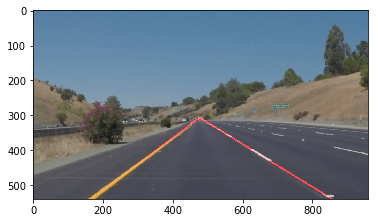

In [21]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

(720, 1280, 3)
795.230864301 412.426500538 0.249248175586 -0.399080998134
 ===== avg ==== 
Coef:  0.249248175586 Intercept:  412.426500538 intersection_x:  590.447536961
line  (590, 559) (960, 651)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.399080998134 Intercept:  795.230864301 intersection_x:  590.447536961
line  (590, 559) (0, 795)
 ===== avg ==== 
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4






  0%|          | 0/251 [00:00<?, ?it/s]

(720, 1280, 3)
795.230864301 412.426500538 0.249248175586 -0.399080998134
 ===== avg ==== 
Coef:  0.249248175586 Intercept:  412.426500538 intersection_x:  590.447536961
line  (590, 559) (960, 651)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.399080998134 Intercept:  795.230864301 intersection_x:  590.447536961
line  (590, 559) (0, 795)
 ===== avg ==== 
(720, 1280, 3)


787.078856355 426.045973896 0.246037133381 -0.407876773114
 ===== avg ==== 
Coef:  0.246037133381 Intercept:  426.045973896 intersection_x:  552.110727226
line  (552, 561) (960, 662)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.407876773114 Intercept:  787.078856355 intersection_x:  552.110727226
line  (552, 561) (0, 787)
 ===== avg ==== 






  1%|          | 2/251 [00:00<00:25,  9.68it/s]



  2%|▏         | 4/251 [00:00<00:21, 11.33it/s]

(720, 1280, 3)
780.730501731 320.198858459 0.340478130534 -0.364308583469
 ===== avg ==== 
Coef:  0.340478130534 Intercept:  320.198858459 intersection_x:  653.434059017
line  (653, 542) (960, 647)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.364308583469 Intercept:  780.730501731 intersection_x:  653.434059017
line  (653, 542) (0, 780)
 ===== avg ==== 
(720, 1280, 3)
786.033149837 418.731323132 0.254855485549 -0.354420653993
 ===== avg ==== 
Coef:  0.254855485549 Intercept:  418.731323132 intersection_x:  602.849517431
line  (602, 572) (960, 663)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.354420653993 Intercept:  786.033149837 intersection_x:  602.849517431
line  (602, 572) (0, 786)
 ===== avg ==== 
(720, 1280, 3)


781.675507569 406.315305847 0.269527492976 -0.342798259605
 ===== avg ==== 
Coef:  0.269527492976 Intercept:  406.315305847 intersection_x:  613.007374164
line  (613, 571) (960, 665)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.342798259605 Intercept:  781.675507569 intersection_x:  613.007374164
line  (613, 571) (0, 781)
 ===== avg ==== 
(720, 1280, 3)
809.956303203 636.513810621 0.059800234095 -0.451313377015
 ===== avg ==== 
Coef:  0.059800234095 Intercept:  636.513810621 intersection_x:  339.3423474
line  (339, 656) (960, 693)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.451313377015 Intercept:  809.956303203 intersection_x:  339.3423474
line  (339, 656) (0, 809)
 ===== avg ==== 
(720, 1280, 3)
885.402223211





  3%|▎         | 7/251 [00:00<00:18, 13.13it/s]

 624.924066917 0.0776692385557 -0.715337769097
 ===== avg ==== 
Coef:  0.0776692385557 Intercept:  624.924066917 intersection_x:  328.468921184
line  (328, 650) (960, 699)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.715337769097 Intercept:  885.402223211 intersection_x:  328.468921184
line  (328, 650) (0, 885)
 ===== avg ==== 
(720, 1280, 3)
810.151408564 296.81596008 0.381390454335 -0.423313891675
 ===== avg ==== 
Coef:  0.381390454335 Intercept:  296.81596008 intersection_x:  637.918076408
line  (637, 540) (960, 662)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.423313891675 Intercept:  810.151408564 intersection_x:  637.918076408
line  (637, 540) (0, 810)
 ===== avg ==== 
(720, 1280, 3)
790.320655456 224.51403439 0.418542085961 -0.392482552746
 ===== avg ==== 
Coef:  0.418542085961 Intercept:  224.51403439 intersection_x:  697.644182509
line  (697, 516) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.392482552746 Intercept:  790.320655456 intersection_x:  697.644182509
line  (6





  4%|▍         | 10/251 [00:00<00:16, 14.66it/s]

(720, 1280, 3)
833.830864519 139.898885636 0.49557351996 -0.516916298346
 ===== avg ==== 
Coef:  0.49557351996 Intercept:  139.898885636 intersection_x:  685.37180951
line  (685, 479) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.516916298346 Intercept:  833.830864519 intersection_x:  685.37180951
line  (685, 479) (0, 833)
 ===== avg ==== 
(720, 1280, 3)






  5%|▌         | 13/251 [00:00<00:14, 16.33it/s]

875.771529864 202.170665268 0.442976209113 -0.694592628915
 ===== avg ==== 
Coef:  0.442976209113 Intercept:  202.170665268 intersection_x:  592.140749709
line  (592, 464) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.694592628915 Intercept:  875.771529864 intersection_x:  592.140749709
line  (592, 464) (0, 875)
 ===== avg ==== 
(720, 1280, 3)
808.338227779 257.903427532 0.390325207261 -0.446581863066
 ===== avg ==== 
Coef:  0.390325207261 Intercept:  257.903427532 intersection_x:  657.701218883
line  (657, 514) (960, 632)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.446581863066 Intercept:  808.338227779 intersection_x:  657.701218883
line  (657, 514) (0, 808)
 ===== avg ==== 
(720, 1280, 3)
774.405546016 391.161750541 0.279116068975 -0.345721100027
 ===== avg ==== 
Coef:  0.279116068975 Intercept:  391.161750541 intersection_x:  613.349868554
line  (613, 562) (960, 659)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.345721100027 Intercept:  774.405546016 intersection_x:  613.349

778.316792993 170.602615825 0.467607052654 -0.338234001671
 ===== avg ==== 
Coef:  0.467607052654 Intercept:  170.602615825 intersection_x:  754.136530903
line  (754, 523) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.338234001671 Intercept:  778.316792993 intersection_x:  754.136530903
line  (754, 523) (0, 778)
 ===== avg ==== 
(720, 1280, 3)
808.966811591 645.261481436 0.042746734699 -0.438223186855
 ===== avg ==== 
Coef:  0.042746734699 Intercept:  645.261481436 intersection_x:  340.365005833
line  (340, 659) (960, 686)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.438223186855 Intercept:  808.966811591 intersection_x:  340.365005833
line  (340, 659) (0, 808)
 ===== avg ==== 






  6%|▌         | 15/251 [00:00<00:13, 17.21it/s]

(720, 1280, 3)
851.789150879 433.726660813 0.234151544179 -0.624325444126
 ===== avg ==== 
Coef:  0.234151544179 Intercept:  433.726660813 intersection_x:  486.981591541
line  (486, 547) (960, 658)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.624325444126 Intercept:  851.789150879 intersection_x:  486.981591541
line  (486, 547) (0, 851)
 ===== avg ==== 
(720, 1280, 3)
807.169338301 643.57375614 0.0492323211377 -0.421547890582
 ===== avg ==== 
Coef:  0.0492323211377 Intercept:  643.57375614 intersection_x:  347.498849969
line  (347, 660) (960, 690)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.421547890582 Intercept:  807.169338301 intersection_x:  347.498849969
line  (347, 660) (0, 807)
 ===== avg ==== 
(720, 1280, 3)
870.493060011 610.287267663 0.0897965603343 -0.638898887334
 ===== avg ==== 
Coef:  0.0897965603343 Intercept:  610.287267663 intersection_x:  357.084421455
line  (357, 642) (960, 696)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.638898887334 Intercept:  870.493060011 interse





  7%|▋         | 18/251 [00:00<00:12, 18.45it/s]

(720, 1280, 3)
811.257492408 318.834331683 0.345709685639 -0.432470022185
 ===== avg ==== 
Coef:  0.345709685639 Intercept:  318.834331683 intersection_x:  632.788488024
line  (632, 537) (960, 650)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.432470022185 Intercept:  811.257492408 intersection_x:  632.788488024
line  (632, 537) (0, 811)
 ===== avg ==== 
(720, 1280, 3)
789.869209741 259.700038715 0.395305402905 -0.387861320338
 ===== avg ==== 
Coef:  0.395305402905 Intercept:  259.700038715 intersection_x:  676.955691925
line  (676, 527) (960, 639)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.387861320338 Intercept:  789.869209741 intersection_x:  676.955691925
line  (676, 527) (0, 789)
 ===== avg ==== 






  8%|▊         | 21/251 [00:01<00:11, 19.53it/s]

(720, 1280, 3)
840.728984806 332.798037602 0.333258167811 -0.560400291706
 ===== avg ==== 
Coef:  0.333258167811 Intercept:  332.798037602 intersection_x:  568.372560898
line  (568, 522) (960, 652)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.560400291706 Intercept:  840.728984806 intersection_x:  568.372560898
line  (568, 522) (0, 840)
 ===== avg ==== 
(720, 1280, 3)
781.38324088 27.7157091048 0.599885474327 -0.409407435043
 ===== avg ==== 
Coef:  0.599885474327 Intercept:  27.7157091048 intersection_x:  746.728253789
line  (746, 475) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.409407435043 Intercept:  781.38324088 intersection_x:  746.728253789
line  (746, 475) (0, 781)
 ===== avg ==== 
(720, 1280, 3)
819.557377681 164.98502443 0.470131355921 -0.496855087459
 ===== avg ==== 
Coef:  0.470131355921 Intercept:  164.98502443 intersection_x:  676.919886242
line  (676, 483) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.496855087459 Intercept:  819.557377681 intersection_





 10%|▉         | 24/251 [00:01<00:11, 20.41it/s]

(720, 1280, 3)
790.525977935 260.733990113 0.392707188297 -0.423919733592
 ===== avg ==== 
Coef:  0.392707188297 Intercept:  260.733990113 intersection_x:  648.756456127
line  (648, 515) (960, 637)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.423919733592 Intercept:  790.525977935 intersection_x:  648.756456127
line  (648, 515) (0, 790)
 ===== avg ==== 
(720, 1280, 3)
796.028683815 219.705121366 0.425365983752 -0.425887126008
 ===== avg ==== 
Coef:  0.425365983752 Intercept:  219.705121366 intersection_x:  677.029611805
line  (677, 507) (960, 628)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.425887126008 Intercept:  796.028683815 intersection_x:  677.029611805
line  (677, 507) (0, 796)
 ===== avg ==== 


(720, 1280, 3)
844.425913673 397.635215274 0.271795870769 -0.640624255072
 ===== avg ==== 
Coef:  0.271795870769 Intercept:  397.635215274 intersection_x:  489.676505094
line  (489, 530) (960, 658)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.640624255072 Intercept:  844.425913673 intersection_x:  489.676505094
line  (489, 530) (0, 844)
 ===== avg ==== 
(720, 1280, 3)
864.574257433 339.099558692 0.320936616848 -0.677258405674
 ===== avg ==== 
Coef:  0.320936616848 Intercept:  339.099558692 intersection_x:  526.424883801
line  (526, 508) (960, 647)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.677258405674 Intercept:  864.574257433 intersection_x:  526.424883801
line  (526, 508) (0, 864)
 ===== avg ==== 






 11%|█         | 27/251 [00:01<00:11, 18.98it/s]

(720, 1280, 3)
849.545892888 610.531116353 0.0783017414913 -0.586968354259
 ===== avg ==== 
Coef:  0.0783017414913 Intercept:  610.531116353 intersection_x:  359.274793895
line  (359, 638) (960, 685)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.586968354259 Intercept:  849.545892888 intersection_x:  359.274793895
line  (359, 638) (0, 849)
 ===== avg ==== 






 12%|█▏        | 29/251 [00:01<00:12, 18.04it/s]

(720, 1280, 3)
802.67276865 303.105807622 0.361224993729 -0.427562290102
 ===== avg ==== 
Coef:  0.361224993729 Intercept:  303.105807622 intersection_x:  633.335464795
line  (633, 531) (960, 649)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.427562290102 Intercept:  802.67276865 intersection_x:  633.335464795
line  (633, 531) (0, 802)
 ===== avg ==== 
(720, 1280, 3)
783.316690605 438.054220946 0.235417411712 -0.408514108604
 ===== avg ==== 
Coef:  0.235417411712 Intercept:  438.054220946 intersection_x:  536.178861829
line  (536, 564) (960, 664)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.408514108604 Intercept:  783.316690605 intersection_x:  536.178861829
line  (536, 564) (0, 783)
 ===== avg ==== 
(720, 1280, 3)
790.171741602 329.090658948 0.33312805891 -0.393467267566
 ===== avg ==== 
Coef:  0.33312805891 Intercept:  329.090658948 intersection_x:  634.57755074
line  (634, 540) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.393467267566 Intercept:  790.171741602 intersection_x





 13%|█▎        | 32/251 [00:01<00:11, 19.17it/s]

(720, 1280, 3)
790.621073098 430.171910965 0.247194367533 -0.414204720696
 ===== avg ==== 
Coef:  0.247194367533 Intercept:  430.171910965 intersection_x:  544.979829196
line  (544, 564) (960, 667)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.414204720696 Intercept:  790.621073098 intersection_x:  544.979829196
line  (544, 564) (0, 790)
 ===== avg ==== 
(720, 1280, 3)






 14%|█▎        | 34/251 [00:01<00:11, 18.21it/s]

775.877171484 287.921679936 0.367081533554 -0.343786495113
 ===== avg ==== 
Coef:  0.367081533554 Intercept:  287.921679936 intersection_x:  686.422052857
line  (686, 539) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.343786495113 Intercept:  775.877171484 intersection_x:  686.422052857
line  (686, 539) (0, 775)
 ===== avg ==== 
(720, 1280, 3)
788.388960036 146.737781548 0.49348227139 -0.400408403927
 ===== avg ==== 
Coef:  0.49348227139 Intercept:  146.737781548 intersection_x:  717.81840465
line  (717, 500) (960, 620)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.400408403927 Intercept:  788.388960036 intersection_x:  717.81840465
line  (717, 500) (0, 788)
 ===== avg ==== 
(720, 1280, 3)
860.374203869 332.806226464 0.327982965862 -0.634861443463
 ===== avg ==== 
Coef:  0.327982965862 Intercept:  332.806226464 intersection_x:  547.926510551
line  (547, 512) (960, 647)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.634861443463 Intercept:  860.374203869 intersection_x:  547.9265105

(720, 1280, 3)
798.579123689 325.251830142 0.339215339071 -0.414896934933
 ===== avg ==== 
Coef:  0.339215339071 Intercept:  325.251830142 intersection_x:  627.661569588
line  (627, 538) (960, 650)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.414896934933 Intercept:  798.579123689 intersection_x:  627.661569588
line  (627, 538) (0, 798)
 ===== avg ==== 






 15%|█▍        | 37/251 [00:01<00:11, 18.96it/s]

(720, 1280, 3)
846.808502474 361.418693693 0.308601837581 -0.594374875946
 ===== avg ==== 
Coef:  0.308601837581 Intercept:  361.418693693 intersection_x:  537.544104416
line  (537, 527) (960, 657)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.594374875946 Intercept:  846.808502474 intersection_x:  537.544104416
line  (537, 527) (0, 846)
 ===== avg ==== 
(720, 1280, 3)
848.254220696 374.293855731 0.292039847897 -0.614004954978
 ===== avg ==== 
Coef:  0.292039847897 Intercept:  374.293855731 intersection_x:  523.109192241
line  (523, 527) (960, 654)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.614004954978 Intercept:  848.254220696 intersection_x:  523.109192241
line  (523, 527) (0, 848)
 ===== avg ==== 
(720, 1280, 3)
791.826110214 662.451571482 0.0371457011323 -0.387121345202
 ===== avg ==== 
Coef:  0.0371457011323 Intercept:  662.451571482 intersection_x:  304.936572024
line  (304, 673) (960, 698)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.387121345202 Intercept:  791.826110214 interse





 16%|█▌        | 39/251 [00:02<00:11, 17.97it/s]

(720, 1280, 3)
797.837232497 228.903396173 0.418585006947 -0.405103061276
 ===== avg ==== 
Coef:  0.418585006947 Intercept:  228.903396173 intersection_x:  690.715160597
line  (690, 518) (960, 630)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.405103061276 Intercept:  797.837232497 intersection_x:  690.715160597
line  (690, 518) (0, 797)
 ===== avg ==== 






 17%|█▋        | 42/251 [00:02<00:11, 18.22it/s]

(720, 1280, 3)
835.089372602 416.555182972 0.2457949481 -0.533834587697
 ===== avg ==== 
Coef:  0.2457949481 Intercept:  416.555182972 intersection_x:  536.837267462
line  (536, 548) (960, 652)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.533834587697 Intercept:  835.089372602 intersection_x:  536.837267462
line  (536, 548) (0, 835)
 ===== avg ==== 
(720, 1280, 3)
854.087828574 320.278480569 0.354028755002 -0.659013977561
 ===== avg ==== 
Coef:  0.354028755002 Intercept:  320.278480569 intersection_x:  526.936654148
line  (526, 506) (960, 660)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659013977561 Intercept:  854.087828574 intersection_x:  526.936654148
line  (526, 506) (0, 854)
 ===== avg ==== 
(720, 1280, 3)
792.828492858 247.521863601 0.41032286577 -0.404279962612
 ===== avg ==== 
Coef:  0.41032286577 Intercept:  247.521863601 intersection_x:  669.414112322
line  (669, 522) (960, 641)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.404279962612 Intercept:  792.828492858 intersection_x:





 18%|█▊        | 44/251 [00:02<00:12, 16.55it/s]



 18%|█▊        | 46/251 [00:02<00:12, 17.03it/s]

796.345949862 378.853990249 0.286686078129 -0.416897252455
 ===== avg ==== 
Coef:  0.286686078129 Intercept:  378.853990249 intersection_x:  593.379549322
line  (593, 548) (960, 654)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.416897252455 Intercept:  796.345949862 intersection_x:  593.379549322
line  (593, 548) (0, 796)
 ===== avg ==== 
(720, 1280, 3)
788.866015249 363.971388374 0.308239315358 -0.382504459168
 ===== avg ==== 
Coef:  0.308239315358 Intercept:  363.971388374 intersection_x:  615.126248755
line  (615, 553) (960, 659)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.382504459168 Intercept:  788.866015249 intersection_x:  615.126248755
line  (615, 553) (0, 788)
 ===== avg ==== 
(720, 1280, 3)
788.31809524 369.141294475 0.293000435476 -0.412956019309
 ===== avg ==== 
Coef:  0.293000435476 Intercept:  369.141294475 intersection_x:  593.771468373
line  (593, 543) (960, 650)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.412956019309 Intercept:  788.31809524 intersection_x:  593.77146





 20%|█▉        | 49/251 [00:02<00:10, 18.41it/s]

(720, 1280, 3)
822.837727498 312.833982226 0.347175455501 -0.488169984273
 ===== avg ==== 
Coef:  0.347175455501 Intercept:  312.833982226 intersection_x:  610.530351863
line  (610, 524) (960, 646)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.488169984273 Intercept:  822.837727498 intersection_x:  610.530351863
line  (610, 524) (0, 822)
 ===== avg ==== 
(720, 1280, 3)
835.851467155 289.344111984 0.366732091269 -0.581738346163
 ===== avg ==== 
Coef:  0.366732091269 Intercept:  289.344111984 intersection_x:  576.198617905
line  (576, 500) (960, 641)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.581738346163 Intercept:  835.851467155 intersection_x:  576.198617905
line  (576, 500) (0, 835)
 ===== avg ==== 
(720, 1280, 3)
842.512220849 417.835233848 0.256590973013 -0.629734404203
 ===== avg ==== 
Coef:  0.256590973013 Intercept:  417.835233848 intersection_x:  479.143436392
line  (479, 540) (960, 664)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.629734404203 Intercept:  842.512220849 intersect





 21%|██        | 52/251 [00:02<00:10, 19.29it/s]



 22%|██▏       | 54/251 [00:02<00:10, 18.45it/s]

(720, 1280, 3)
857.002502191 665.759761916 0.0297380049435 -0.621549433019
 ===== avg ==== 
Coef:  0.0297380049435 Intercept:  665.759761916 intersection_x:  293.637999335
line  (293, 674) (960, 694)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.621549433019 Intercept:  857.002502191 intersection_x:  293.637999335
line  (293, 674) (0, 857)
 ===== avg ==== 
(720, 1280, 3)
781.345471474 395.997922588 0.268215455744 -0.375228976458
 ===== avg ==== 
Coef:  0.268215455744 Intercept:  395.997922588 intersection_x:  598.88240476
line  (598, 556) (960, 653)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.375228976458 Intercept:  781.345471474 intersection_x:  598.88240476
line  (598, 556) (0, 781)
 ===== avg ==== 
(720, 1280, 3)
785.853010215 288.965454483 0.365513105675 -0.394497767653
 ===== avg ==== 
Coef:  0.365513105675 Intercept:  288.965454483 intersection_x:  653.790061656
line  (653, 527) (960, 639)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.394497767653 Intercept:  785.853010215 intersect





 23%|██▎       | 57/251 [00:03<00:10, 19.38it/s]



 24%|██▍       | 60/251 [00:03<00:09, 20.14it/s]

(720, 1280, 3)
794.72854837 351.721167148 0.311637431079 -0.412194947835
 ===== avg ==== 
Coef:  0.311637431079 Intercept:  351.721167148 intersection_x:  612.030345875
line  (612, 542) (960, 650)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.412194947835 Intercept:  794.72854837 intersection_x:  612.030345875
line  (612, 542) (0, 794)
 ===== avg ==== 
(720, 1280, 3)
835.490180058 244.895105939 0.411742425759 -0.5413587699
 ===== avg ==== 
Coef:  0.411742425759 Intercept:  244.895105939 intersection_x:  619.656209444
line  (619, 500) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.5413587699 Intercept:  835.490180058 intersection_x:  619.656209444
line  (619, 500) (0, 835)
 ===== avg ==== 
(720, 1280, 3)
794.841268435 220.264837717 0.433159866475 -0.425353013953
 ===== avg ==== 
Coef:  0.433159866475 Intercept:  220.264837717 intersection_x:  669.269435342
line  (669, 510) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.425353013953 Intercept:  794.841268435 intersection_x:





 25%|██▌       | 63/251 [00:03<00:08, 20.90it/s]

(720, 1280, 3)
833.123847344 363.908377546 0.310658086364 -0.620195265136
 ===== avg ==== 
Coef:  0.310658086364 Intercept:  363.908377546 intersection_x:  504.070237316
line  (504, 520) (960, 662)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.620195265136 Intercept:  833.123847344 intersection_x:  504.070237316
line  (504, 520) (0, 833)
 ===== avg ==== 
(720, 1280, 3)
797.527155046 312.698890082 0.344074471894 -0.426655525577
 ===== avg ==== 
Coef:  0.344074471894 Intercept:  312.698890082 intersection_x:  629.050726655
line  (629, 529) (960, 643)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.426655525577 Intercept:  797.527155046 intersection_x:  629.050726655
line  (629, 529) (0, 797)
 ===== avg ==== 
(720, 1280, 3)
834.348808001 575.141141141 0.108215358215 -0.500738339819
 ===== avg ==== 
Coef:  0.108215358215 Intercept:  575.141141141 intersection_x:  425.66071558
line  (425, 621) (960, 679)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.500738339819 Intercept:  834.348808001 intersecti





 26%|██▋       | 66/251 [00:03<00:09, 19.81it/s]

871.266408281 26.1505910056 0.599316649737 -0.644356766646
 ===== avg ==== 
Coef:  0.599316649737 Intercept:  26.1505910056 intersection_x:  679.531946364
line  (679, 433) (960, 601)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.644356766646 Intercept:  871.266408281 intersection_x:  679.531946364
line  (679, 433) (0, 871)
 ===== avg ==== 
(720, 1280, 3)
774.865152979 312.099889819 0.346049683345 -0.369495634098
 ===== avg ==== 
Coef:  0.346049683345 Intercept:  312.099889819 intersection_x:  646.730894437
line  (646, 535) (960, 644)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.369495634098 Intercept:  774.865152979 intersection_x:  646.730894437
line  (646, 535) (0, 774)
 ===== avg ==== 
(720, 1280, 3)
778.930359872 195.941080524 0.449800662301 -0.378360880284
 ===== avg ==== 
Coef:  0.449800662301 Intercept:  195.941080524 intersection_x:  703.955990915
line  (703, 512) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.378360880284 Intercept:  778.930359872 intersection_x:  703.955





 27%|██▋       | 69/251 [00:03<00:09, 19.40it/s]



 28%|██▊       | 71/251 [00:03<00:09, 19.14it/s]

(720, 1280, 3)
804.454234868 310.348333737 0.343465544875 -0.462062299379
 ===== avg ==== 
Coef:  0.343465544875 Intercept:  310.348333737 intersection_x:  613.39394368
line  (613, 521) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.462062299379 Intercept:  804.454234868 intersection_x:  613.39394368
line  (613, 521) (0, 804)
 ===== avg ==== 
(720, 1280, 3)
783.084311447 378.497442468 0.278978772649 -0.38587210631
 ===== avg ==== 
Coef:  0.278978772649 Intercept:  378.497442468 intersection_x:  608.537766562
line  (608, 548) (960, 646)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.38587210631 Intercept:  783.084311447 intersection_x:  608.537766562
line  (608, 548) (0, 783)
 ===== avg ==== 
(720, 1280, 3)
791.022533019 249.389642296 0.395426277223 -0.427307027676
 ===== avg ==== 
Coef:  0.395426277223 Intercept:  249.389642296 intersection_x:  658.333493367
line  (658, 509) (960, 628)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.427307027676 Intercept:  791.022533019 intersection_





 29%|██▉       | 73/251 [00:03<00:09, 18.37it/s]



 30%|██▉       | 75/251 [00:03<00:09, 18.40it/s]

(720, 1280, 3)
766.169317313 640.044074063 0.0656435487869 -0.336988333022
 ===== avg ==== 
Coef:  0.0656435487869 Intercept:  640.044074063 intersection_x:  313.252002508
line  (313, 660) (960, 703)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.336988333022 Intercept:  766.169317313 intersection_x:  313.252002508
line  (313, 660) (0, 766)
 ===== avg ==== 
(720, 1280, 3)
807.72140627 657.728571429 0.0142857142857 -0.420188486508
 ===== avg ==== 
Coef:  0.0142857142857 Intercept:  657.728571429 intersection_x:  345.22840382
line  (345, 662) (960, 671)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.420188486508 Intercept:  807.72140627 intersection_x:  345.22840382
line  (345, 662) (0, 807)
 ===== avg ==== 
(720, 1280, 3)
809.421384943 643.458400189 0.058552642259 -0.462107034335
 ===== avg ==== 
Coef:  0.058552642259 Intercept:  643.458400189 intersection_x:  318.755210388
line  (318, 662) (960, 699)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.462107034335 Intercept:  809.421384943 intersect





 31%|███       | 77/251 [00:04<00:09, 18.30it/s]



 31%|███▏      | 79/251 [00:04<00:09, 18.00it/s]

(720, 1280, 3)
804.072461629 405.644229266 0.262448198237 -0.484242088233
 ===== avg ==== 
Coef:  0.262448198237 Intercept:  405.644229266 intersection_x:  533.59236029
line  (533, 545) (960, 657)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.484242088233 Intercept:  804.072461629 intersection_x:  533.59236029
line  (533, 545) (0, 804)
 ===== avg ==== 
(720, 1280, 3)
896.033583268 402.066709472 0.2679673852 -0.711819620199
 ===== avg ==== 
Coef:  0.2679673852 Intercept:  402.066709472 intersection_x:  504.157404694
line  (504, 537) (960, 659)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.711819620199 Intercept:  896.033583268 intersection_x:  504.157404694
line  (504, 537) (0, 896)
 ===== avg ==== 
(720, 1280, 3)
751.658015921 192.314847999 0.439650102441 -0.334044743115
 ===== avg ==== 
Coef:  0.439650102441 Intercept:  192.314847999 intersection_x:  722.950619529
line  (722, 510) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.334044743115 Intercept:  751.658015921 intersection_x:





 33%|███▎      | 82/251 [00:04<00:08, 18.86it/s]

(720, 1280, 3)
741.530772509 215.400717701 0.419671472686 -0.350528013034
 ===== avg ==== 
Coef:  0.419671472686 Intercept:  215.400717701 intersection_x:  683.108810851
line  (683, 502) (960, 618)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.350528013034 Intercept:  741.530772509 intersection_x:  683.108810851
line  (683, 502) (0, 741)
 ===== avg ==== 
(720, 1280, 3)
802.401819244 340.804631141 0.287437453051 -0.482594301933
 ===== avg ==== 
Coef:  0.287437453051 Intercept:  340.804631141 intersection_x:  599.452146117
line  (599, 513) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.482594301933 Intercept:  802.401819244 intersection_x:  599.452146117
line  (599, 513) (0, 802)
 ===== avg ==== 
(720, 1280, 3)
740.600040687 304.486775025 0.338412514556 -0.366099641728
 ===== avg ==== 
Coef:  0.338412514556 Intercept:  304.486775025 intersection_x:  619.028730408
line  (619, 513) (960, 629)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.366099641728 Intercept:  740.600040687 intersect





 34%|███▍      | 85/251 [00:04<00:08, 18.74it/s]



 35%|███▍      | 87/251 [00:04<00:09, 17.28it/s]

(720, 1280, 3)
746.018463854 609.099289935 0.0329489694281 -0.332400329842
 ===== avg ==== 
Coef:  0.0329489694281 Intercept:  609.099289935 intersection_x:  374.76238272
line  (374, 621) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.332400329842 Intercept:  746.018463854 intersection_x:  374.76238272
line  (374, 621) (0, 746)
 ===== avg ==== 
(720, 1280, 3)
777.622217412 569.807395655 0.0276694137708 -0.425767491088
 ===== avg ==== 
Coef:  0.0276694137708 Intercept:  569.807395655 intersection_x:  458.310339388
line  (458, 582) (960, 596)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.425767491088 Intercept:  777.622217412 intersection_x:  458.310339388
line  (458, 582) (0, 777)
 ===== avg ==== 
(720, 1280, 3)
744.030642225 599.33479305 0.0470030215411 -0.318221290439
 ===== avg ==== 
Coef:  0.0470030215411 Intercept:  599.33479305 intersection_x:  396.183508129
line  (396, 617) (960, 644)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.318221290439 Intercept:  744.030642225 interse





 35%|███▌      | 89/251 [00:04<00:09, 17.58it/s]



 36%|███▋      | 91/251 [00:04<00:09, 16.66it/s]

746.736389937 331.202627552 0.313435622679 -0.326627862587
 ===== avg ==== 
Coef:  0.313435622679 Intercept:  331.202627552 intersection_x:  649.207105154
line  (649, 534) (960, 632)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.326627862587 Intercept:  746.736389937 intersection_x:  649.207105154
line  (649, 534) (0, 746)
 ===== avg ==== 
(720, 1280, 3)
720.856523452 576.650096481 0.0967355516917 -0.298288900954
 ===== avg ==== 
Coef:  0.0967355516917 Intercept:  576.650096481 intersection_x:  365.056962941
line  (365, 611) (960, 669)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.298288900954 Intercept:  720.856523452 intersection_x:  365.056962941
line  (365, 611) (0, 720)
 ===== avg ==== 
(720, 1280, 3)
745.518752691 612.703845807 0.0634080605303 -0.326423100033
 ===== avg ==== 
Coef:  0.0634080605303 Intercept:  612.703845807 intersection_x:  340.69853906
line  (340, 634) (960, 673)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.326423100033 Intercept:  745.518752691 intersection_x:  340.





 37%|███▋      | 93/251 [00:04<00:09, 17.21it/s]



 38%|███▊      | 95/251 [00:05<00:08, 17.67it/s]

(720, 1280, 3)
689.825070362 616.378045394 0.0638027204876 -0.248856143234
 ===== avg ==== 
Coef:  0.0638027204876 Intercept:  616.378045394 intersection_x:  234.911059594
line  (234, 631) (960, 677)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.248856143234 Intercept:  689.825070362 intersection_x:  234.911059594
line  (234, 631) (0, 689)
 ===== avg ==== 
(720, 1280, 3)
722.045122124 396.968886598 0.256127181736 -0.29556710756
 ===== avg ==== 
Coef:  0.256127181736 Intercept:  396.968886598 intersection_x:  589.232554755
line  (589, 547) (960, 642)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.29556710756 Intercept:  722.045122124 intersection_x:  589.232554755
line  (589, 547) (0, 722)
 ===== avg ==== 
(720, 1280, 3)
669.237616359 452.525433133 0.212841522143 -0.182176421221
 ===== avg ==== 
Coef:  0.212841522143 Intercept:  452.525433133 intersection_x:  548.613517099
line  (548, 569) (960, 656)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.182176421221 Intercept:  669.237616359 intersect





 39%|███▊      | 97/251 [00:05<00:08, 17.57it/s]



 39%|███▉      | 99/251 [00:05<00:08, 18.09it/s]

(720, 1280, 3)
689.006432729 576.747911128 0.114669659991 -0.207893081089
 ===== avg ==== 
Coef:  0.114669659991 Intercept:  576.747911128 intersection_x:  348.020733036
line  (348, 616) (960, 686)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.207893081089 Intercept:  689.006432729 intersection_x:  348.020733036
line  (348, 616) (0, 689)
 ===== avg ==== 
(720, 1280, 3)
698.784377763 617.634735699 0.069839903917 -0.208580144905
 ===== avg ==== 
Coef:  0.069839903917 Intercept:  617.634735699 intersection_x:  291.464793603
line  (291, 637) (960, 684)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.208580144905 Intercept:  698.784377763 intersection_x:  291.464793603
line  (291, 637) (0, 698)
 ===== avg ==== 
(720, 1280, 3)
705.868280204 592.143154667 0.0834292110591 -0.261525405924
 ===== avg ==== 
Coef:  0.0834292110591 Intercept:  592.143154667 intersection_x:  329.681412969
line  (329, 619) (960, 672)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.261525405924 Intercept:  705.868280204 interse





 40%|████      | 101/251 [00:05<00:08, 16.82it/s]

(720, 1280, 3)
714.558078735 633.147562079 0.0433718036037 -0.259082419488
 ===== avg ==== 
Coef:  0.0433718036037 Intercept:  633.147562079 intersection_x:  269.166407475
line  (269, 644) (960, 674)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.259082419488 Intercept:  714.558078735 intersection_x:  269.166407475
line  (269, 644) (0, 714)
 ===== avg ==== 
(720, 1280, 3)
739.728841644 574.419761334 0.0857670322064 -0.328822727879
 ===== avg ==== 
Coef:  0.0857670322064 Intercept:  574.419761334 intersection_x:  398.729289107
line  (398, 608) (960, 656)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.328822727879 Intercept:  739.728841644 intersection_x:  398.729289107
line  (398, 608) (0, 739)
 ===== avg ==== 
(720, 1280, 3)
702.519753499 557.649196794 0.116636114927 -0.247522624996
 ===== avg ==== 
Coef:  0.116636114927 Intercept:  557.649196794 intersection_x:  397.822545013
line  (397, 604) (960, 669)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.247522624996 Intercept:  702.519753499 inter





 41%|████      | 103/251 [00:05<00:09, 15.81it/s]



 42%|████▏     | 105/251 [00:05<00:09, 15.33it/s]

(720, 1280, 3)
720.292781537 205.643368371 0.419494788998 -0.24201891371
 ===== avg ==== 
Coef:  0.419494788998 Intercept:  205.643368371 intersection_x:  777.987532323
line  (777, 532) (960, 608)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.24201891371 Intercept:  720.292781537 intersection_x:  777.987532323
line  (777, 532) (0, 720)
 ===== avg ==== 
(720, 1280, 3)
711.060168102 193.191512378 0.427143894922 -0.296042174628
 ===== avg ==== 
Coef:  0.427143894922 Intercept:  193.191512378 intersection_x:  716.09324008
line  (716, 499) (960, 603)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.296042174628 Intercept:  711.060168102 intersection_x:  716.09324008
line  (716, 499) (0, 711)
 ===== avg ==== 
(720, 1280, 3)
723.257502027 426.346002796 0.239952351108 -0.282516736776
 ===== avg ==== 
Coef:  0.239952351108 Intercept:  426.346002796 intersection_x:  568.285294032
line  (568, 562) (960, 656)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.282516736776 Intercept:  723.257502027 intersection_





 43%|████▎     | 107/251 [00:05<00:09, 15.09it/s]

(720, 1280, 3)
696.545845131 387.891569084 0.278108751646 -0.150752698922
 ===== avg ==== 
Coef:  0.278108751646 Intercept:  387.891569084 intersection_x:  719.706272592
line  (719, 588) (960, 654)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.150752698922 Intercept:  696.545845131 intersection_x:  719.706272592
line  (719, 588) (0, 696)
 ===== avg ==== 
(720, 1280, 3)
742.149413611 370.557082123 0.29714095815 -0.17625737761
 ===== avg ==== 
Coef:  0.29714095815 Intercept:  370.557082123 intersection_x:  784.946425491
line  (784, 603) (960, 655)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.17625737761 Intercept:  742.149413611 intersection_x:  784.946425491
line  (784, 603) (0, 742)
 ===== avg ==== 
(720, 1280, 3)






 43%|████▎     | 109/251 [00:06<00:10, 13.20it/s]



 44%|████▍     | 111/251 [00:06<00:10, 13.54it/s]

719.911849425 443.505879704 0.2157555312 -0.113438561957
 ===== avg ==== 
Coef:  0.2157555312 Intercept:  443.505879704 intersection_x:  839.644378397
line  (839, 624) (960, 650)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.113438561957 Intercept:  719.911849425 intersection_x:  839.644378397
line  (839, 624) (0, 719)
 ===== avg ==== 
(720, 1280, 3)
717.923651073 485.998089214 0.17045947325 -0.122872890634
 ===== avg ==== 
Coef:  0.17045947325 Intercept:  485.998089214 intersection_x:  790.657937598
line  (790, 620) (960, 649)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.122872890634 Intercept:  717.923651073 intersection_x:  790.657937598
line  (790, 620) (0, 717)
 ===== avg ==== 
(720, 1280, 3)
8089.38856732 -inf inf -10.1943156339






 45%|████▌     | 114/251 [00:06<00:09, 15.22it/s]

(720, 1280, 3)
735.97884283 634.565811159 0.0781676315176 -0.187337488153
 ===== avg ==== 
Coef:  0.0781676315176 Intercept:  634.565811159 intersection_x:  381.962622028
line  (381, 664) (960, 709)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.187337488153 Intercept:  735.97884283 intersection_x:  381.962622028
line  (381, 664) (0, 735)
 ===== avg ==== 
(720, 1280, 3)
771.220495581 643.138347719 0.0590721677711 -0.329373859772
 ===== avg ==== 
Coef:  0.0590721677711 Intercept:  643.138347719 intersection_x:  329.729586044
line  (329, 662) (960, 699)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.329373859772 Intercept:  771.220495581 intersection_x:  329.729586044
line  (329, 662) (0, 771)
 ===== avg ==== 
(720, 1280, 3)
759.745761814 591.519766098 0.0883023229843 -0.248560242212
 ===== avg ==== 
Coef:  0.0883023229843 Intercept:  591.519766098 intersection_x:  499.390591583
line  (499, 635) (960, 676)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.248560242212 Intercept:  759.745761814 inter







 46%|████▌     | 116/251 [00:06<00:10, 13.36it/s]



 47%|████▋     | 118/251 [00:06<00:10, 13.12it/s]

 322.746504555 0.287721804839 -0.175656246058
 ===== avg ==== 
Coef:  0.287721804839 Intercept:  322.746504555 intersection_x:  897.519573655
line  (897, 580) (960, 598)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.175656246058 Intercept:  738.637375238 intersection_x:  897.519573655
line  (897, 580) (0, 738)
 ===== avg ==== 
(720, 1280, 3)
750.420317132 495.409278528 0.150694651122 -0.187922158813
 ===== avg ==== 
Coef:  0.150694651122 Intercept:  495.409278528 intersection_x:  753.096217087
line  (753, 608) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.187922158813 Intercept:  750.420317132 intersection_x:  753.096217087
line  (753, 608) (0, 750)
 ===== avg ==== 
(720, 1280, 3)
735.94978286 376.174473064 0.289334000445 -0.19325915037
 ===== avg ==== 
Coef:  0.289334000445 Intercept:  376.174473064 intersection_x:  745.504384363
line  (745, 591) (960, 653)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.19325915037 Intercept:  735.94978286 intersection_x:  745.504384363
line  (745





 48%|████▊     | 120/251 [00:06<00:09, 13.34it/s]

748.523888843 416.142276179 0.265906502098 -0.202779402019
 ===== avg ==== 
Coef:  0.265906502098 Intercept:  416.142276179 intersection_x:  709.177745147
line  (709, 604) (960, 671)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.202779402019 Intercept:  748.523888843 intersection_x:  709.177745147
line  (709, 604) (0, 748)
 ===== avg ==== 
(720, 1280, 3)
745.08339165 557.163126876 0.117810073853 -0.16371624954
 ===== avg ==== 
Coef:  0.117810073853 Intercept:  557.163126876 intersection_x:  667.505128861
line  (667, 635) (960, 670)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.16371624954 Intercept:  745.08339165 intersection_x:  667.505128861
line  (667, 635) (0, 745)
 ===== avg ==== 
(720, 1280, 3)
690.659414284 290.781790768 0.332049154727 -0.0753400406651
 ===== avg ==== 
Coef:  0.332049154727 Intercept:  290.781790768 intersection_x:  981.561681165
line  (981, 616) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.0753400406651 Intercept:  690.659414284 intersection_x:  981.56168





 49%|████▉     | 123/251 [00:06<00:08, 14.72it/s]



 50%|█████     | 126/251 [00:07<00:07, 16.30it/s]

(720, 1280, 3)
651.388333333 321.610944619 0.327538389403 -0.0400915750916
 ===== avg ==== 
Coef:  0.327538389403 Intercept:  321.610944619 intersection_x:  897.036206414
line  (897, 615) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.0400915750916 Intercept:  651.388333333 intersection_x:  897.036206414
line  (897, 615) (0, 651)
 ===== avg ==== 
(720, 1280, 3)
738.638194028 284.016928899 0.377089637 -0.147248510109
 ===== avg ==== 
Coef:  0.377089637 Intercept:  284.016928899 intersection_x:  867.038317992
line  (867, 610) (960, 646)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.147248510109 Intercept:  738.638194028 intersection_x:  867.038317992
line  (867, 610) (0, 738)
 ===== avg ==== 
(720, 1280, 3)
745.683243972 566.587676275 0.0883183236803 -0.158319653536
 ===== avg ==== 
Coef:  0.0883183236803 Intercept:  566.587676275 intersection_x:  726.14756948
line  (726, 630) (960, 651)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.158319653536 Intercept:  745.683243972 intersection





 51%|█████     | 128/251 [00:07<00:07, 16.34it/s]

720.628198755 169.391173928 0.455354690557 -0.220749734027
 ===== avg ==== 
Coef:  0.455354690557 Intercept:  169.391173928 intersection_x:  815.313440917
line  (815, 540) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.220749734027 Intercept:  720.628198755 intersection_x:  815.313440917
line  (815, 540) (0, 720)
 ===== avg ==== 
(720, 1280, 3)
656.033367454 372.446105855 0.248470913349 -0.0907853285833
 ===== avg ==== 
Coef:  0.248470913349 Intercept:  372.446105855 intersection_x:  835.908751403
line  (835, 580) (960, 610)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.0907853285833 Intercept:  656.033367454 intersection_x:  835.908751403
line  (835, 580) (0, 656)
 ===== avg ==== 
(720, 1280, 3)
675.575845411 272.67868595 0.34355613957 -0.05038647343
 ===== avg ==== 
Coef:  0.34355613957 Intercept:  272.67868595 intersection_x:  1022.73058604
line  (1022, 624) (960, 602)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.05038647343 Intercept:  675.575845411 intersection_x:  1022.73058





 52%|█████▏    | 131/251 [00:07<00:07, 16.89it/s]

(720, 1280, 3)
718.010917955 326.305309122 0.342374612434 -0.2340172069
 ===== avg ==== 
Coef:  0.342374612434 Intercept:  326.305309122 intersection_x:  679.582179508
line  (679, 558) (960, 654)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.2340172069 Intercept:  718.010917955 intersection_x:  679.582179508
line  (679, 558) (0, 718)
 ===== avg ==== 
(720, 1280, 3)
721.489099596 360.707306816 0.32377884015 -0.210349085277
 ===== avg ==== 
Coef:  0.32377884015 Intercept:  360.707306816 intersection_x:  675.459521223
line  (675, 579) (960, 671)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.210349085277 Intercept:  721.489099596 intersection_x:  675.459521223
line  (675, 579) (0, 721)
 ===== avg ==== 
(720, 1280, 3)
729.057306609 415.509105149 0.260650647451 -0.339103379892
 ===== avg ==== 
Coef:  0.260650647451 Intercept:  415.509105149 intersection_x:  522.794657752
line  (522, 551) (960, 665)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.339103379892 Intercept:  729.057306609 intersection_x:





 53%|█████▎    | 134/251 [00:07<00:06, 17.30it/s]



 55%|█████▍    | 137/251 [00:07<00:06, 18.52it/s]

(720, 1280, 3)
684.087077467 287.013536663 0.380950711194 -0.202974202198
 ===== avg ==== 
Coef:  0.380950711194 Intercept:  287.013536663 intersection_x:  680.007877207
line  (680, 546) (960, 652)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.202974202198 Intercept:  684.087077467 intersection_x:  680.007877207
line  (680, 546) (0, 684)
 ===== avg ==== 
(720, 1280, 3)
729.948708475 322.577899907 0.304545830531 -0.256279204912
 ===== avg ==== 
Coef:  0.304545830531 Intercept:  322.577899907 intersection_x:  726.37771644
line  (726, 543) (960, 614)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.256279204912 Intercept:  729.948708475 intersection_x:  726.37771644
line  (726, 543) (0, 729)
 ===== avg ==== 
(720, 1280, 3)
704.383935713 408.988256892 0.264568832887 -0.304057660859
 ===== avg ==== 
Coef:  0.264568832887 Intercept:  408.988256892 intersection_x:  519.489826924
line  (519, 546) (960, 662)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.304057660859 Intercept:  704.383935713 intersectio





 55%|█████▌    | 139/251 [00:07<00:06, 18.27it/s]



 56%|█████▌    | 141/251 [00:07<00:06, 17.85it/s]

755.478112994 392.641197107 0.208497998756 -0.389859251362
 ===== avg ==== 
Coef:  0.208497998756 Intercept:  392.641197107 intersection_x:  606.388434025
line  (606, 519) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.389859251362 Intercept:  755.478112994 intersection_x:  606.388434025
line  (606, 519) (0, 755)
 ===== avg ==== 
(720, 1280, 3)
688.389970326 384.222163767 0.215410155971 -0.232792461829
 ===== avg ==== 
Coef:  0.215410155971 Intercept:  384.222163767 intersection_x:  678.639067421
line  (678, 530) (960, 591)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.232792461829 Intercept:  688.389970326 intersection_x:  678.639067421
line  (678, 530) (0, 688)
 ===== avg ==== 
(720, 1280, 3)
725.91054492 514.801852177 0.0805795630576 -0.301477770163
 ===== avg ==== 
Coef:  0.0805795630576 Intercept:  514.801852177 intersection_x:  552.55762522
line  (552, 559) (960, 592)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.301477770163 Intercept:  725.91054492 intersection_x:  552.5576





 57%|█████▋    | 144/251 [00:08<00:05, 18.69it/s]



 58%|█████▊    | 146/251 [00:08<00:05, 18.89it/s]

666.733402226 -inf inf -0.205481188805
(720, 1280, 3)
677.407916798 -inf inf -0.25060938145
(720, 1280, 3)
685.052032113 488.809442179 0.12258121526 -0.203379285814
 ===== avg ==== 
Coef:  0.12258121526 Intercept:  488.809442179 intersection_x:  602.044079844
line  (602, 562) (960, 606)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.203379285814 Intercept:  685.052032113 intersection_x:  602.044079844
line  (602, 562) (0, 685)
 ===== avg ==== 
(720, 1280, 3)
687.423752044 500.179670766 0.124195767405 -0.202145895217
 ===== avg ==== 
Coef:  0.124195767405 Intercept:  500.179670766 intersection_x:  573.767013915
line  (573, 571) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.202145895217 Intercept:  687.423752044 intersection_x:  573.767013915
line  (573, 571) (0, 687)
 ===== avg ==== 
(720, 1280, 3)
701.812498931 558.205449098 0.0820065044489 -0.262308551389
 ===== avg ==== 
Coef:  0.0820065044489 Intercept:  558.205449098 intersection_x:  417.080366945
line  





 59%|█████▉    | 148/251 [00:08<00:05, 18.61it/s]

(417, 592) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.262308551389 Intercept:  701.812498931 intersection_x:  417.080366945
line  (417, 592) (0, 701)
 ===== avg ==== 
(720, 1280, 3)
716.262762976 593.970475198 0.0728557095024 -0.275763110073
 ===== avg ==== 
Coef:  0.0728557095024 Intercept:  593.970475198 intersection_x:  350.790837761
line  (350, 619) (960, 663)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.275763110073 Intercept:  716.262762976 intersection_x:  350.790837761
line  (350, 619) (0, 716)
 ===== avg ==== 
(720, 1280, 3)
714.03221339 613.091528369 0.0687498103008 -0.22882553549
 ===== avg ==== 
Coef:  0.0687498103008 Intercept:  613.091528369 intersection_x:  339.210510713
line  (339, 636) (960, 679)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.22882553549 Intercept:  714.03221339 intersection_x:  339.210510713
line  (339, 636) (0, 714)
 ===== avg ==== 
(720, 1280, 3)






 60%|█████▉    | 150/251 [00:08<00:06, 16.29it/s]



 61%|██████    | 152/251 [00:08<00:06, 15.33it/s]

723.445133284 500.230093277 0.154785455564 -0.235266419751
 ===== avg ==== 
Coef:  0.154785455564 Intercept:  500.230093277 intersection_x:  572.270136702
line  (572, 588) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.235266419751 Intercept:  723.445133284 intersection_x:  572.270136702
line  (572, 588) (0, 723)
 ===== avg ==== 
(720, 1280, 3)
718.760973638 368.794126782 0.276937290711 -0.259682592415
 ===== avg ==== 
Coef:  0.276937290711 Intercept:  368.794126782 intersection_x:  652.168989374
line  (652, 549) (960, 634)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.259682592415 Intercept:  718.760973638 intersection_x:  652.168989374
line  (652, 549) (0, 718)
 ===== avg ==== 
(720, 1280, 3)
777.959328717 287.784643212 0.360276229575 -0.490461333174
 ===== avg ==== 
Coef:  0.360276229575 Intercept:  287.784643212 intersection_x:  576.176140526
line  (576, 495) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.490461333174 Intercept:  777.959328717 intersection_x:  576.176





 62%|██████▏   | 155/251 [00:08<00:05, 16.37it/s]


 ===== avg ==== 
Coef:  0.30460486614 Intercept:  350.43626392 intersection_x:  570.670691899
line  (570, 524) (960, 642)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.371795823213 Intercept:  736.438313314 intersection_x:  570.670691899
line  (570, 524) (0, 736)
 ===== avg ==== 
(720, 1280, 3)
719.674972731 389.743150937 0.273389415887 -0.311185566493
 ===== avg ==== 
Coef:  0.273389415887 Intercept:  389.743150937 intersection_x:  564.396068491
line  (564, 544) (960, 652)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.311185566493 Intercept:  719.674972731 intersection_x:  564.396068491
line  (564, 544) (0, 719)
 ===== avg ==== 
(720, 1280, 3)
740.69376795 388.099455181 0.27216840461 -0.389636705002
 ===== avg ==== 
Coef:  0.27216840461 Intercept:  388.099455181 intersection_x:  532.776655314
line  (532, 533) (960, 649)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.389636705002 Intercept:  740.69376795 intersection_x:  532.776655314
line  (532, 533) (0, 740)
 ===== avg ==== 
(720, 1280, 3)





 63%|██████▎   | 157/251 [00:08<00:05, 15.82it/s]



 63%|██████▎   | 159/251 [00:09<00:05, 15.80it/s]

(720, 1280, 3)
737.380977524 235.456273726 0.425539433298 -0.316550606423
 ===== avg ==== 
Coef:  0.425539433298 Intercept:  235.456273726 intersection_x:  676.36631262
line  (676, 523) (960, 643)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.316550606423 Intercept:  737.380977524 intersection_x:  676.36631262
line  (676, 523) (0, 737)
 ===== avg ==== 
(720, 1280, 3)
746.312789018 633.144988924 0.0515563129167 -0.316788196322
 ===== avg ==== 
Coef:  0.0515563129167 Intercept:  633.144988924 intersection_x:  307.233574155
line  (307, 648) (960, 682)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.316788196322 Intercept:  746.312789018 intersection_x:  307.233574155
line  (307, 648) (0, 746)
 ===== avg ==== 
(720, 1280, 3)
799.374874896 317.144328001 0.386284243427 -0.585152545981
 ===== avg ==== 
Coef:  0.386284243427 Intercept:  317.144328001 intersection_x:  496.409598805
line  (496, 508) (960, 687)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.585152545981 Intercept:  799.374874896 intersect





 64%|██████▍   | 161/251 [00:09<00:05, 16.35it/s]

736.648608368 665.313617065 0.038997618308 -0.335347563958
 ===== avg ==== 
Coef:  0.038997618308 Intercept:  665.313617065 intersection_x:  190.559394595
line  (190, 672) (960, 702)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.335347563958 Intercept:  736.648608368 intersection_x:  190.559394595
line  (190, 672) (0, 736)
 ===== avg ==== 
(720, 1280, 3)
788.992642533 412.33838539 0.254138931558 -0.562080781585
 ===== avg ==== 
Coef:  0.254138931558 Intercept:  412.33838539 intersection_x:  461.461847929
line  (461, 529) (960, 656)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.562080781585 Intercept:  788.992642533 intersection_x:  461.461847929
line  (461, 529) (0, 788)
 ===== avg ==== 
(720, 1280, 3)
776.616544722 276.010661846 0.37182762424 -0.463964389941
 ===== avg ==== 
Coef:  0.37182762424 Intercept:  276.010661846 intersection_x:  598.959878034
line  (598, 498) (960, 632)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.463964389941 Intercept:  776.616544722 intersection_x:  598.9598780





 65%|██████▍   | 163/251 [00:09<00:05, 15.81it/s]



 66%|██████▌   | 166/251 [00:09<00:05, 16.37it/s]

(720, 1280, 3)
791.728724029 118.703205449 0.553309397344 -0.555648968585
 ===== avg ==== 
Coef:  0.553309397344 Intercept:  118.703205449 intersection_x:  606.898815373
line  (606, 454) (960, 649)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.555648968585 Intercept:  791.728724029 intersection_x:  606.898815373
line  (606, 454) (0, 791)
 ===== avg ==== 
(720, 1280, 3)
814.562570301 180.447106013 0.460357624831 -0.58820632342
 ===== avg ==== 
Coef:  0.460357624831 Intercept:  180.447106013 intersection_x:  604.746582548
line  (604, 458) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.58820632342 Intercept:  814.562570301 intersection_x:  604.746582548
line  (604, 458) (0, 814)
 ===== avg ==== 
(720, 1280, 3)
799.363480099 113.102680668 0.530615376248 -0.561496801362
 ===== avg ==== 
Coef:  0.530615376248 Intercept:  113.102680668 intersection_x:  628.379404149
line  (628, 446) (960, 622)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.561496801362 Intercept:  799.363480099 intersectio





 67%|██████▋   | 169/251 [00:09<00:04, 17.51it/s]

(720, 1280, 3)
809.02531646 179.388571745 0.466566960225 -0.578104780565
 ===== avg ==== 
Coef:  0.466566960225 Intercept:  179.388571745 intersection_x:  602.712526942
line  (602, 460) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.578104780565 Intercept:  809.02531646 intersection_x:  602.712526942
line  (602, 460) (0, 809)
 ===== avg ==== 
(720, 1280, 3)
769.69696475 240.32397084 0.417045322477 -0.389697927959
 ===== avg ==== 
Coef:  0.417045322477 Intercept:  240.32397084 intersection_x:  656.185215834
line  (656, 513) (960, 640)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.389697927959 Intercept:  769.69696475 intersection_x:  656.185215834
line  (656, 513) (0, 769)
 ===== avg ==== 
(720, 1280, 3)
784.998631031 329.173471998 0.327469881312 -0.401176980416
 ===== avg ==== 
Coef:  0.327469881312 Intercept:  329.173471998 intersection_x:  625.577605525
line  (625, 534) (960, 643)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.401176980416 Intercept:  784.998631031 intersection_x:





 68%|██████▊   | 171/251 [00:09<00:04, 16.97it/s]



 69%|██████▉   | 173/251 [00:09<00:04, 17.64it/s]

(720, 1280, 3)
756.160122823 325.289204069 0.337907065736 -0.36664947147
 ===== avg ==== 
Coef:  0.337907065736 Intercept:  325.289204069 intersection_x:  611.549103587
line  (611, 531) (960, 649)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.36664947147 Intercept:  756.160122823 intersection_x:  611.549103587
line  (611, 531) (0, 756)
 ===== avg ==== 
(720, 1280, 3)
779.253077845 261.175906947 0.403719390152 -0.407243181179
 ===== avg ==== 
Coef:  0.403719390152 Intercept:  261.175906947 intersection_x:  638.842271164
line  (638, 519) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.407243181179 Intercept:  779.253077845 intersection_x:  638.842271164
line  (638, 519) (0, 779)
 ===== avg ==== 
(720, 1280, 3)
775.167506374 149.330737325 0.491642925976 -0.368385525182
 ===== avg ==== 
Coef:  0.491642925976 Intercept:  149.330737325 intersection_x:  727.69309923
line  (727, 507) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.368385525182 Intercept:  775.167506374 intersection





 70%|██████▉   | 175/251 [00:09<00:04, 17.92it/s]



 71%|███████   | 177/251 [00:10<00:04, 18.05it/s]

(720, 1280, 3)
775.458583615 393.862349169 0.269991465723 -0.368867640709
 ===== avg ==== 
Coef:  0.269991465723 Intercept:  393.862349169 intersection_x:  597.308906776
line  (597, 555) (960, 653)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.368867640709 Intercept:  775.458583615 intersection_x:  597.308906776
line  (597, 555) (0, 775)
 ===== avg ==== 
(720, 1280, 3)
811.386104604 312.819860761 0.349375780879 -0.553421261993
 ===== avg ==== 
Coef:  0.349375780879 Intercept:  312.819860761 intersection_x:  552.246208358
line  (552, 505) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.553421261993 Intercept:  811.386104604 intersection_x:  552.246208358
line  (552, 505) (0, 811)
 ===== avg ==== 
(720, 1280, 3)
772.141434084 184.467879334 0.455419865573 -0.358789308072
 ===== avg ==== 
Coef:  0.455419865573 Intercept:  184.467879334 intersection_x:  721.772210105
line  (721, 513) (960, 621)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.358789308072 Intercept:  772.141434084 intersect





 72%|███████▏  | 180/251 [00:10<00:03, 18.91it/s]



 73%|███████▎  | 182/251 [00:10<00:03, 18.50it/s]

(720, 1280, 3)
844.664608083 162.558456632 0.473215304118 -0.638382705955
 ===== avg ==== 
Coef:  0.473215304118 Intercept:  162.558456632 intersection_x:  613.62663955
line  (613, 452) (960, 616)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.638382705955 Intercept:  844.664608083 intersection_x:  613.62663955
line  (613, 452) (0, 844)
 ===== avg ==== 
(720, 1280, 3)
803.516183897 343.696423607 0.305423050993 -0.430303042638
 ===== avg ==== 
Coef:  0.305423050993 Intercept:  343.696423607 intersection_x:  624.987701634
line  (624, 534) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.430303042638 Intercept:  803.516183897 intersection_x:  624.987701634
line  (624, 534) (0, 803)
 ===== avg ==== 
(720, 1280, 3)
793.193138447 642.514438935 0.0334536577945 -0.423827037138
 ===== avg ==== 
Coef:  0.0334536577945 Intercept:  642.514438935 intersection_x:  329.51030118
line  (329, 653) (960, 674)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.423827037138 Intercept:  793.193138447 intersecti





 74%|███████▎  | 185/251 [00:10<00:03, 18.65it/s]

(720, 1280, 3)
863.297978691 658.622657952 0.032788671024 -0.665398966316
 ===== avg ==== 
Coef:  0.032788671024 Intercept:  658.622657952 intersection_x:  293.152312921
line  (293, 668) (960, 690)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.665398966316 Intercept:  863.297978691 intersection_x:  293.152312921
line  (293, 668) (0, 863)
 ===== avg ==== 
(720, 1280, 3)
860.318398819 277.956399006 0.371764594227 -0.659417719043
 ===== avg ==== 
Coef:  0.371764594227 Intercept:  277.956399006 intersection_x:  564.751734314
line  (564, 487) (960, 634)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.659417719043 Intercept:  860.318398819 intersection_x:  564.751734314
line  (564, 487) (0, 860)
 ===== avg ==== 
(720, 1280, 3)
863.150557868 254.839847465 0.394847489167 -0.666577812674
 ===== avg ==== 
Coef:  0.394847489167 Intercept:  254.839847465 intersection_x:  573.107414481
line  (573, 481) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.666577812674 Intercept:  863.150557868 intersect





 75%|███████▍  | 187/251 [00:10<00:03, 17.86it/s]



 76%|███████▌  | 190/251 [00:10<00:03, 18.52it/s]


line  (693, 544) (0, 793)
 ===== avg ==== 
(720, 1280, 3)
808.881319123 153.838209796 0.482805003617 -0.434158579697
 ===== avg ==== 
Coef:  0.482805003617 Intercept:  153.838209796 intersection_x:  714.361094866
line  (714, 498) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.434158579697 Intercept:  808.881319123 intersection_x:  714.361094866
line  (714, 498) (0, 808)
 ===== avg ==== 
(720, 1280, 3)
809.855960902 276.444871415 0.3633546214 -0.444195748678
 ===== avg ==== 
Coef:  0.3633546214 Intercept:  276.444871415 intersection_x:  660.529806253
line  (660, 516) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.444195748678 Intercept:  809.855960902 intersection_x:  660.529806253
line  (660, 516) (0, 809)
 ===== avg ==== 
(720, 1280, 3)
869.70620232 237.250487095 0.406392940028 -0.67189050097
 ===== avg ==== 
Coef:  0.406392940028 Intercept:  237.250487095 intersection_x:  586.539393242
line  (586, 475) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.6718905009





 77%|███████▋  | 193/251 [00:10<00:03, 19.02it/s]

814.696052493 241.789575476 0.410043471336 -0.444575794325
 ===== avg ==== 
Coef:  0.410043471336 Intercept:  241.789575476 intersection_x:  670.364570561
line  (670, 516) (960, 635)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.444575794325 Intercept:  814.696052493 intersection_x:  670.364570561
line  (670, 516) (0, 814)
 ===== avg ==== 
(720, 1280, 3)
870.242168884 663.872859489 0.0412854797091 -0.639403047085
 ===== avg ==== 
Coef:  0.0412854797091 Intercept:  663.872859489 intersection_x:  303.17729956
line  (303, 676) (960, 703)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.639403047085 Intercept:  870.242168884 intersection_x:  303.17729956
line  (303, 676) (0, 870)
 ===== avg ==== 
(720, 1280, 3)
792.61866684 631.674462924 0.0469507969508 -0.394612071456
 ===== avg ==== 
Coef:  0.0469507969508 Intercept:  631.674462924 intersection_x:  364.487631163
line  (364, 648) (960, 676)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.394612071456 Intercept:  792.61866684 intersection_x:  364.487





 78%|███████▊  | 195/251 [00:10<00:03, 17.97it/s]



 78%|███████▊  | 197/251 [00:11<00:03, 17.57it/s]

(720, 1280, 3)
795.636888239 284.62602683 0.356333625332 -0.410527072868
 ===== avg ==== 
Coef:  0.356333625332 Intercept:  284.62602683 intersection_x:  666.36725889
line  (666, 522) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.410527072868 Intercept:  795.636888239 intersection_x:  666.36725889
line  (666, 522) (0, 795)
 ===== avg ==== 
(720, 1280, 3)
872.692554967 558.041285031 0.115826016236 -0.685715763875
 ===== avg ==== 
Coef:  0.115826016236 Intercept:  558.041285031 intersection_x:  392.557540659
line  (392, 603) (960, 669)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.685715763875 Intercept:  872.692554967 intersection_x:  392.557540659
line  (392, 603) (0, 872)
 ===== avg ==== 
(720, 1280, 3)
818.28411429 198.052743607 0.432213381842 -0.461195803844
 ===== avg ==== 
Coef:  0.432213381842 Intercept:  198.052743607 intersection_x:  694.229901169
line  (694, 498) (960, 612)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.461195803844 Intercept:  818.28411429 intersection_x:





 79%|███████▉  | 199/251 [00:11<00:03, 16.74it/s]



 80%|████████  | 201/251 [00:11<00:02, 16.98it/s]

871.107320324 274.143890836 0.366807642487 -0.681337306854
 ===== avg ==== 
Coef:  0.366807642487 Intercept:  274.143890836 intersection_x:  569.542819306
line  (569, 483) (960, 626)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681337306854 Intercept:  871.107320324 intersection_x:  569.542819306
line  (569, 483) (0, 871)
 ===== avg ==== 
(720, 1280, 3)
810.962217556 308.946057515 0.333731852164 -0.472803718683
 ===== avg ==== 
Coef:  0.333731852164 Intercept:  308.946057515 intersection_x:  622.435238056
line  (622, 516) (960, 629)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.472803718683 Intercept:  810.962217556 intersection_x:  622.435238056
line  (622, 516) (0, 810)
 ===== avg ==== 
(720, 1280, 3)
874.072652478 221.216277271 0.415089671166 -0.660902343773
 ===== avg ==== 
Coef:  0.415089671166 Intercept:  221.216277271 intersection_x:  606.748345845
line  (606, 473) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.660902343773 Intercept:  874.072652478 intersection_x:  606.748





 81%|████████  | 203/251 [00:11<00:02, 17.69it/s]



 82%|████████▏ | 206/251 [00:11<00:02, 18.26it/s]

833.734182062 288.733654344 0.353582804709 -0.474619238871
 ===== avg ==== 
Coef:  0.353582804709 Intercept:  288.733654344 intersection_x:  658.052623683
line  (658, 521) (960, 628)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.474619238871 Intercept:  833.734182062 intersection_x:  658.052623683
line  (658, 521) (0, 833)
 ===== avg ==== 
(720, 1280, 3)
808.854438804 205.235104242 0.427823369021 -0.45179071906
 ===== avg ==== 
Coef:  0.427823369021 Intercept:  205.235104242 intersection_x:  686.231999625
line  (686, 498) (960, 615)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.45179071906 Intercept:  808.854438804 intersection_x:  686.231999625
line  (686, 498) (0, 808)
 ===== avg ==== 
(720, 1280, 3)
874.964255152 335.082401893 0.319082972995 -0.688455152086
 ===== avg ==== 
Coef:  0.319082972995 Intercept:  335.082401893 intersection_x:  535.842604681
line  (535, 506) (960, 641)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.688455152086 Intercept:  874.964255152 intersection_x:  535.84260





 83%|████████▎ | 208/251 [00:11<00:02, 18.56it/s]

894.763443892 340.142480995 0.32488092268 -0.681451223795
 ===== avg ==== 
Coef:  0.32488092268 Intercept:  340.142480995 intersection_x:  551.131119919
line  (551, 519) (960, 652)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.681451223795 Intercept:  894.763443892 intersection_x:  551.131119919
line  (551, 519) (0, 894)
 ===== avg ==== 
(720, 1280, 3)
884.804078224 338.25372362 0.312920747371 -0.65740825748
 ===== avg ==== 
Coef:  0.312920747371 Intercept:  338.25372362 intersection_x:  563.262926153
line  (563, 514) (960, 638)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.65740825748 Intercept:  884.804078224 intersection_x:  563.262926153
line  (563, 514) (0, 884)
 ===== avg ==== 
(720, 1280, 3)
885.837891888 286.445363436 0.355056819754 -0.662725343564
 ===== avg ==== 
Coef:  0.355056819754 Intercept:  286.445363436 intersection_x:  588.920252344
line  (588, 495) (960, 627)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.662725343564 Intercept:  885.837891888 intersection_x:  588.920252344





 84%|████████▍ | 211/251 [00:11<00:02, 18.09it/s]



 85%|████████▍ | 213/251 [00:11<00:02, 17.94it/s]

821.582571845 257.708694002 0.381671618642 -0.452802020122
 ===== avg ==== 
Coef:  0.381671618642 Intercept:  257.708694002 intersection_x:  675.724015295
line  (675, 515) (960, 624)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.452802020122 Intercept:  821.582571845 intersection_x:  675.724015295
line  (675, 515) (0, 821)
 ===== avg ==== 
(720, 1280, 3)
866.005709798 282.205197894 0.366462878979 -0.636159481185
 ===== avg ==== 
Coef:  0.366462878979 Intercept:  282.205197894 intersection_x:  582.273580861
line  (582, 495) (960, 634)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.636159481185 Intercept:  866.005709798 intersection_x:  582.273580861
line  (582, 495) (0, 866)
 ===== avg ==== 
(720, 1280, 3)
834.049430298 405.619789471 0.252018796918 -0.50340558201
 ===== avg ==== 
Coef:  0.252018796918 Intercept:  405.619789471 intersection_x:  567.137694755
line  (567, 548) (960, 647)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.50340558201 Intercept:  834.049430298 intersection_x:  567.13769





 86%|████████▌ | 216/251 [00:12<00:01, 18.80it/s]



 87%|████████▋ | 218/251 [00:12<00:01, 19.04it/s]

(720, 1280, 3)
921.658328679 271.701913067 0.368636687158 -0.768247741233
 ===== avg ==== 
Coef:  0.368636687158 Intercept:  271.701913067 intersection_x:  571.699637518
line  (571, 482) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.768247741233 Intercept:  921.658328679 intersection_x:  571.699637518
line  (571, 482) (0, 921)
 ===== avg ==== 
(720, 1280, 3)
826.952165996 630.824193473 0.0478976448003 -0.440971544867
 ===== avg ==== 
Coef:  0.0478976448003 Intercept:  630.824193473 intersection_x:  401.187018263
line  (401, 650) (960, 676)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.440971544867 Intercept:  826.952165996 intersection_x:  401.187018263
line  (401, 650) (0, 826)
 ===== avg ==== 
(720, 1280, 3)
861.133806953 660.966695028 0.0209223177061 -0.54584821067
 ===== avg ==== 
Coef:  0.0209223177061 Intercept:  660.966695028 intersection_x:  353.171348726
line  (353, 668) (960, 681)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.54584821067 Intercept:  861.133806953 interse





 88%|████████▊ | 220/251 [00:12<00:01, 18.74it/s]

833.969361266 357.421454832 0.287313892948 -0.488372607779
 ===== avg ==== 
Coef:  0.287313892948 Intercept:  357.421454832 intersection_x:  614.35632306
line  (614, 533) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.488372607779 Intercept:  833.969361266 intersection_x:  614.35632306
line  (614, 533) (0, 833)
 ===== avg ==== 
(720, 1280, 3)
840.152872498 654.770680329 0.0205322593382 -0.535335845033
 ===== avg ==== 
Coef:  0.0205322593382 Intercept:  654.770680329 intersection_x:  333.500322669
line  (333, 661) (960, 674)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.535335845033 Intercept:  840.152872498 intersection_x:  333.500322669
line  (333, 661) (0, 840)
 ===== avg ==== 
(720, 1280, 3)
858.055809267 297.102530008 0.342567899358 -0.586766703315
 ===== avg ==== 
Coef:  0.342567899358 Intercept:  297.102530008 intersection_x:  603.607438747
line  (603, 503) (960, 625)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.586766703315 Intercept:  858.055809267 intersection_x:  603.607





 89%|████████▉ | 223/251 [00:12<00:01, 19.92it/s]



 90%|█████████ | 226/251 [00:12<00:01, 20.68it/s]

(720, 1280, 3)
880.429638241 254.591155334 0.3782030587 -0.652616422587
 ===== avg ==== 
Coef:  0.3782030587 Intercept:  254.591155334 intersection_x:  607.127139396
line  (607, 484) (960, 617)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.652616422587 Intercept:  880.429638241 intersection_x:  607.127139396
line  (607, 484) (0, 880)
 ===== avg ==== 
(720, 1280, 3)
891.899374161 290.369800751 0.357097434061 -0.722727949862
 ===== avg ==== 
Coef:  0.357097434061 Intercept:  290.369800751 intersection_x:  557.061893863
line  (557, 489) (960, 633)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.722727949862 Intercept:  891.899374161 intersection_x:  557.061893863
line  (557, 489) (0, 891)
 ===== avg ==== 
(720, 1280, 3)
823.060990643 162.675358414 0.465919516663 -0.466403711301
 ===== avg ==== 
Coef:  0.465919516663 Intercept:  162.675358414 intersection_x:  708.322620762
line  (708, 492) (960, 609)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.466403711301 Intercept:  823.060990643 intersection_





 91%|█████████ | 229/251 [00:12<00:01, 19.91it/s]

(720, 1280, 3)
828.24651752 274.90501436 0.386898328416 -0.470676717172
 ===== avg ==== 
Coef:  0.386898328416 Intercept:  274.90501436 intersection_x:  645.239744332
line  (645, 524) (960, 646)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.470676717172 Intercept:  828.24651752 intersection_x:  645.239744332
line  (645, 524) (0, 828)
 ===== avg ==== 
(720, 1280, 3)
913.597811623 413.674117573 0.25397019056 -0.756381213151
 ===== avg ==== 
Coef:  0.25397019056 Intercept:  413.674117573 intersection_x:  494.801800852
line  (494, 539) (960, 657)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.756381213151 Intercept:  913.597811623 intersection_x:  494.801800852
line  (494, 539) (0, 913)
 ===== avg ==== 
(720, 1280, 3)
901.234858059 183.746657173 0.453953794976 -0.694342273867
 ===== avg ==== 
Coef:  0.453953794976 Intercept:  183.746657173 intersection_x:  624.82857893
line  (624, 467) (960, 619)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.694342273867 Intercept:  901.234858059 intersection_x: 





 92%|█████████▏| 232/251 [00:12<00:00, 19.07it/s]



 93%|█████████▎| 234/251 [00:13<00:00, 19.25it/s]

(720, 1280, 3)
863.716306813 351.225745241 0.295917180103 -0.678337621492
 ===== avg ==== 
Coef:  0.295917180103 Intercept:  351.225745241 intersection_x:  526.033395712
line  (526, 506) (960, 635)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.678337621492 Intercept:  863.716306813 intersection_x:  526.033395712
line  (526, 506) (0, 863)
 ===== avg ==== 
(720, 1280, 3)
830.797761232 317.808968867 0.326616279001 -0.503338970899
 ===== avg ==== 
Coef:  0.326616279001 Intercept:  317.808968867 intersection_x:  618.092110902
line  (618, 519) (960, 631)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.503338970899 Intercept:  830.797761232 intersection_x:  618.092110902
line  (618, 519) (0, 830)
 ===== avg ==== 
(720, 1280, 3)
816.936483064 263.070230988 0.382007818053 -0.468655711381
 ===== avg ==== 
Coef:  0.382007818053 Intercept:  263.070230988 intersection_x:  651.099092546
line  (651, 511) (960, 629)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.468655711381 Intercept:  816.936483064 intersect





 94%|█████████▍| 236/251 [00:13<00:00, 19.28it/s]



 95%|█████████▍| 238/251 [00:13<00:00, 16.56it/s]

(720, 1280, 3)
793.945595422 174.039826514 0.457809975312 -0.39528127736
 ===== avg ==== 
Coef:  0.457809975312 Intercept:  174.039826514 intersection_x:  726.658217356
line  (726, 506) (960, 613)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.39528127736 Intercept:  793.945595422 intersection_x:  726.658217356
line  (726, 506) (0, 793)
 ===== avg ==== 
(720, 1280, 3)
829.362131465 264.293093252 0.37372346529 -0.477698981977
 ===== avg ==== 
Coef:  0.37372346529 Intercept:  264.293093252 intersection_x:  663.676462874
line  (663, 512) (960, 623)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.477698981977 Intercept:  829.362131465 intersection_x:  663.676462874
line  (663, 512) (0, 829)
 ===== avg ==== 
(720, 1280, 3)
925.096427731 656.032786885 0.016393442623 -0.773896846792
 ===== avg ==== 
Coef:  0.016393442623 Intercept:  656.032786885 intersection_x:  340.461782777
line  (340, 661) (960, 671)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.773896846792 Intercept:  925.096427731 intersection_





 96%|█████████▌| 240/251 [00:13<00:00, 16.56it/s]



 97%|█████████▋| 243/251 [00:13<00:00, 18.06it/s]

(720, 1280, 3)
876.13159574 639.295703797 0.0330653849214 -0.661181238943
 ===== avg ==== 
Coef:  0.0330653849214 Intercept:  639.295703797 intersection_x:  341.140862341
line  (341, 650) (960, 671)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.661181238943 Intercept:  876.13159574 intersection_x:  341.140862341
line  (341, 650) (0, 876)
 ===== avg ==== 
(720, 1280, 3)
824.785898937 328.474372955 0.321905670665 -0.487153399504
 ===== avg ==== 
Coef:  0.321905670665 Intercept:  328.474372955 intersection_x:  613.44287986
line  (613, 525) (960, 637)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.487153399504 Intercept:  824.785898937 intersection_x:  613.44287986
line  (613, 525) (0, 824)
 ===== avg ==== 
(720, 1280, 3)
832.757148535 304.731131654 0.346017137274 -0.484420496092
 ===== avg ==== 
Coef:  0.346017137274 Intercept:  304.731131654 intersection_x:  635.840664808
line  (635, 524) (960, 636)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.484420496092 Intercept:  832.757148535 intersectio





 98%|█████████▊| 246/251 [00:13<00:00, 19.18it/s]

Coef:  0.353080014986 Intercept:  295.839329918 intersection_x:  671.775148232
line  (671, 533) (960, 634)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.400159394159 Intercept:  801.846845651 intersection_x:  671.775148232
line  (671, 533) (0, 801)
 ===== avg ==== 
(720, 1280, 3)
862.11611098 356.501056589 0.29896796104 -0.613931710304
 ===== avg ==== 
Coef:  0.29896796104 Intercept:  356.501056589 intersection_x:  553.856102989
line  (553, 522) (960, 643)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.613931710304 Intercept:  862.11611098 intersection_x:  553.856102989
line  (553, 522) (0, 862)
 ===== avg ==== 
(720, 1280, 3)
850.750326527 423.059722016 0.241089195514 -0.648334366394
 ===== avg ==== 
Coef:  0.241089195514 Intercept:  423.059722016 intersection_x:  480.862687732
line  (480, 538) (960, 654)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.648334366394 Intercept:  850.750326527 intersection_x:  480.862687732
line  (480, 538) (0, 850)
 ===== avg ==== 
(720, 1280, 3)
877.364732918 2





 99%|█████████▉| 248/251 [00:13<00:00, 19.12it/s]



100%|█████████▉| 250/251 [00:13<00:00, 17.23it/s]

(720, 1280, 3)
824.677430998 302.246967281 0.349356776024 -0.464164595025
 ===== avg ==== 
Coef:  0.349356776024 Intercept:  302.246967281 intersection_x:  642.18406831
line  (642, 526) (960, 637)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.464164595025 Intercept:  824.677430998 intersection_x:  642.18406831
line  (642, 526) (0, 824)
 ===== avg ==== 
(720, 1280, 3)
809.965427343 325.79993352 0.336554309503 -0.430357645865
 ===== avg ==== 
Coef:  0.336554309503 Intercept:  325.79993352 intersection_x:  631.318224255
line  (631, 538) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.430357645865 Intercept:  809.965427343 intersection_x:  631.318224255
line  (631, 538) (0, 809)
 ===== avg ==== 
(720, 1280, 3)
816.821774277 450.408114712 0.206565072016 -0.453853660929
 ===== avg ==== 
Coef:  0.206565072016 Intercept:  450.408114712 intersection_x:  554.820209188
line  (554, 565) (960, 648)
 ===== avg ==== 
 ===== avg ==== 
Coef:  -0.453853660929 Intercept:  816.821774277 intersection_





100%|██████████| 251/251 [00:14<00:00, 17.92it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 14.2 s, sys: 1.47 s, total: 15.7 s
Wall time: 14.8 s


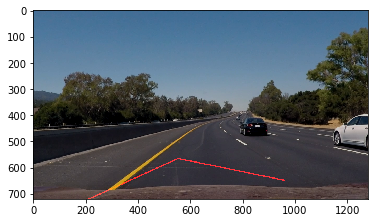

In [29]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))